# 🚀 Module 1: Environment Setup & Research Configuration (Google Colab)

## 1. Introduction
This module initializes the **Google Colab** environment for the Quantitative Pairs Trading research pipeline.  
The goal is to ensure the notebook runs smoothly and reproducibly by:
- Installing missing dependencies (if needed)
- Importing the core quantitative finance library stack
- Mounting Google Drive to persist outputs across Colab sessions
- Defining a single global configuration dictionary used by all downstream cells

---

## 2. Library Architecture
We use a standard, research-friendly Python stack:

- **`yfinance`**: Download adjusted market data (prices) from Yahoo Finance.
- **`pandas`, `numpy`**: Data manipulation and vectorized numerical computation.
- **`matplotlib`, `altair`**: Visualization (quick plots + interactive charts).
- **`statsmodels`** (`api`, `tsa.stattools`): Econometrics and time-series statistics (OLS, ADF, cointegration tests).
- **`scipy.spatial.distance`**: Distance metrics for pair screening.
- **`itertools.combinations`**: Efficient generation of candidate pairs.
- **`tqdm.notebook`**: Progress bars for long-running loops.
- **`os`**: File system utilities for reading/writing artifacts.

---

## 3. Google Drive Mount (Persistence Layer)
Colab runtimes reset frequently. To avoid losing intermediate results and outputs, we mount Google Drive at:

`/content/drive`

All exported CSV files and artifacts are saved to Drive to support long experiments and reproducible reruns.

---

## 4. Global Research Configuration (2010 → Present)
We centralize system-wide settings into a single `CONFIG` dictionary:

- **`start_date`**: fixed start date (`2010-01-01`) to capture multiple market regimes.
- **`end_date`**: dynamically set to today at runtime.
- **`use_log_price`**: when `True`, the pipeline uses log-price \(\log(P_t)\) instead of raw price \(P_t\), which aligns better with return-based reasoning and improves numerical stability in spread modeling.

| Parameter | Value | Description |
| :--- | :--- | :--- |
| `start_date` | `2010-01-01` | Start of dataset (formation history begins here). |
| `end_date` | `2025-12-25` | Automatically set to the notebook run date. |
| `use_log_price` | `True` | Use \(\log(P_t)\) rather than \(P_t\) throughout the pipeline. |

> Note: Filters such as minimum history coverage (survivorship screening) and other data-quality checks are applied in later validation modules, not in this setup cell.


In [21]:
# Cell 0: Setup Environment & Libraries
try:
    import yfinance
except ImportError:
    !pip install yfinance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
from tqdm.notebook import tqdm
import altair as alt
import os

# Mount Google Drive (Để đọc file đã lưu)
from google.colab import drive
drive.mount('/content/drive')

print("✅ Đã nạp thư viện và kết nối Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Đã nạp thư viện và kết nối Drive.


In [22]:
# Cell 1: Setup Environment & Configuration (2010 - Present)
from datetime import datetime
import os

# CẤU HÌNH HỆ THỐNG
CONFIG = {
    'start_date': '2010-01-01',      # MỐC THỜI GIAN MỚI
    'end_date': '2025-12-25', # Lấy 2025-12-25
    'use_log_price': True,           # Bắt buộc cho Pairs Trading
}

# --- AUTO-DETECT DRIVE FOR SAFETY (FIX 1A) ---
IN_COLAB = os.path.exists("/content")
DRIVE_ROOT = "/content/drive/MyDrive"

if IN_COLAB and os.path.isdir(DRIVE_ROOT):
    # Ghi thẳng lên Drive để tránh mất dữ liệu khi Reset Runtime
    CONFIG["run_root"] = os.path.join(DRIVE_ROOT, "pairs_runs")
    CONFIG["data_dir"] = os.path.join(DRIVE_ROOT, "pairs_data")
    print("✅ Detected Colab + Drive: Configured to save DIRECTLY to Drive.")
else:
    # Fallback local
    CONFIG.setdefault("run_root", "runs")
    CONFIG.setdefault("data_dir", "data")
    print("⚠️ Drive not found or Local: Configured to save locally.")

print(f"Cấu hình: Tải dữ liệu từ {CONFIG['start_date']} đến {CONFIG['end_date']}")
print("CONFIG.run_root =", CONFIG["run_root"])
print("CONFIG.data_dir =", CONFIG["data_dir"])

✅ Detected Colab + Drive: Configured to save DIRECTLY to Drive.
Cấu hình: Tải dữ liệu từ 2010-01-01 đến 2025-12-25
CONFIG.run_root = /content/drive/MyDrive/pairs_runs
CONFIG.data_dir = /content/drive/MyDrive/pairs_data


# 📦 Module 2: Define the Trading Universe (Stocks + ETFs, 2010+ Focus)

## 1) Purpose
This cell defines the **asset universe** we will scan for pairs. The universe is designed to be practical for the **2010–present** regime and includes:
- A large set of liquid **ETFs** (sector, style, bonds, commodities, global, and a small leveraged stress-test group)
- **S&P 500 stocks** (fetched from a public constituents dataset)

The output is a single list: `full_tickers`.

---

## 2) Universe Construction Logic

### A) S&P 500 (Robust Fetch + Fallback)
We attempt to download the current S&P 500 constituents from a maintained public CSV source.  
If that fails (network issues, URL changes), we fall back to a **hard-coded top-100** ticker list to keep the notebook runnable.

**Implementation notes**
- We convert tickers like `BRK.B` into Yahoo Finance format `BRK-B`.
- The fallback is intentionally biased toward large, liquid names to reduce data-quality issues.

### B) ETF Coverage (2010+ Era)
We use several ETF groups to increase diversity of pair candidates:

- **Sector ETFs** (SPDR, Vanguard, iShares): capture intra-sector relative value dynamics
- **Broad market / size / style ETFs**: capture factor spreads (value vs growth, small vs large)
- **Bonds + commodities ETFs**: provide cross-asset hedging candidates and stress different regimes
- **Strategy / smart beta / country ETFs**: additional factor + macro exposure set
- **Leveraged ETFs** (small list): included intentionally as a **stress test** for the pipeline  
  (Note: these are path-dependent and structurally different instruments.)

Finally, we deduplicate everything (`set`) to avoid repeated tickers and return `full_universe`.

---

## 3) ⚠️ Critical Limitations & Biases (Read This Before Trusting Any Backtest)

### A) Survivorship Bias (Major)
**Problem:** the S&P 500 list we fetch is based on **today’s constituents**, not the historical constituents at each past date.

**Consequence:** companies that were removed from the index, merged, bankrupt, or delisted since 2010 are often missing.  
This can make results look **artificially better** because the backtest implicitly focuses on survivors.

**Why we accept it (practical constraint):**
- Free data sources (especially Yahoo Finance) often do not reliably provide long historical series for delisted tickers.
- The primary objective of this notebook is to validate a **research pipeline / methodology**, not claim a perfect historically investable PnL.

### B) Instrument Heterogeneity (ETF vs Stock)
We mix **stocks and ETFs**. That increases opportunity but also adds complexity:
- ETFs embed rebalancing, fees, and index methodology changes.
- Some ETFs have structural breaks (e.g., sector redefinitions, liquidity changes).
- Leveraged ETFs are path-dependent (they are *not* just “2× SPY”).

**Consequence:** pair behavior across instrument types may not be comparable.

### C) Data Quality & Corporate Actions (Yahoo Finance Caveat)
Even when using adjusted prices:
- Corporate actions, ticker changes, and missing data can create discontinuities.
- Some ETFs/stocks have shorter history than 2010 → coverage filters later become essential.

### D) Practical Trading Constraints Not Fully Modeled Here
This universe definition does not incorporate:
- Borrow availability / shorting constraints
- Transaction cost differences across tickers
- Slippage and liquidity impact

These are handled later (partially) via filters and cost assumptions, but not perfectly.

---

## 4) Output
This cell produces:
- `full_tickers`: the final list of tickers to download and analyze
- A printed count of ETFs and total symbols scanned

This universe is intentionally broad; downstream modules will apply data validation and statistical screening to reduce it.


In [4]:
# Cell 2: Define Universe (Optimized for 2010+ Era)
def get_sp500_robust():
    """Tải S&P 500 (Thử nhiều nguồn)."""
    try:
        url = 'https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents.csv'
        df = pd.read_csv(url)
        return [s.replace('.', '-') for s in df['Symbol'].tolist()]
    except:
        # Fallback list (Top 100)
        return ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'META', 'TSLA', 'BRK-B', 'UNH', 'JNJ', 'JPM', 'XOM', 'V', 'PG', 'LLY', 'MA', 'HD', 'CVX', 'MRK', 'ABBV', 'PEP', 'KO', 'BAC', 'AVGO', 'COST', 'TMO', 'MCD', 'CSCO', 'ACN', 'ABT', 'DHR', 'WMT', 'DIS', 'LIN', 'PFE', 'NKE', 'VZ', 'NEE', 'TXN', 'ADBE', 'PM', 'BMY', 'WFC', 'RTX', 'UPS', 'MS', 'HON', 'QCOM', 'UNP', 'INTC', 'CVS', 'LOW', 'IBM', 'DE', 'GS', 'EL', 'CAT', 'MDT', 'AMGN', 'PLD', 'BLK', 'T', 'SPGI', 'GE', 'AMT', 'ISRG', 'BKNG', 'GILD', 'AXP', 'SBUX', 'ADI', 'SYK', 'TJX', 'MDLZ', 'MMC', 'ADP', 'C', 'BA', 'LMT', 'CB', 'CI', 'VRTX', 'MO', 'TMUS', 'ZTS', 'REGN', 'FI', 'PGR', 'SO', 'BSX', 'EOG', 'SLB', 'BDX', 'EQIX', 'NOC', 'ITW', 'CSX', 'CL']

def get_full_universe():

    # 1. ETFs (Danh sách mở rộng cho kỷ nguyên 2010)
    # Bao gồm cả các mã sinh năm 2006-2009 (GDXJ, VIG, VNQ, BND...)

    etf_sectors = [
        'XLK', 'XLE', 'XLF', 'XLV', 'XLI', 'XLY', 'XLP', 'XLU', 'XLB', 'XLRE', # SPDR
        'VGT', 'VHT', 'VDC', 'VIS', 'VAW', 'VPU', 'VNQ', 'VCR', 'VOX', 'VB', 'VTV', 'VUG', 'VBR', # Vanguard
        'IYF', 'IYH', 'IYE', 'IYJ', 'IYV', 'IYW', 'IYZ', 'IYT', 'IYK', 'IDU', 'REM', 'ICLN', 'IGV', 'IGM', 'IGN' # iShares
    ]

    etf_broad_market = [
        'SPY', 'QQQ', 'IWM', 'DIA', 'VTI', 'VEA', 'VWO', 'EEM', 'EFA', 'EWJ', 'ACWI', 'VT',
        'RSP', 'MDY', 'IWB', 'IWD', 'IWF', 'IWN', 'IWO' # Size & Style
    ]

    etf_bonds_commodities = [
        'TLT', 'IEF', 'SHY', 'LQD', 'HYG', 'JNK', 'BND', 'AGG', 'MUB', 'TFI', 'TIP', 'BIV', # Bonds
        'GLD', 'SLV', 'USO', 'UNG', 'DBC', 'DBA', 'PALL', 'PPLT', 'GDX', 'GDXJ', 'XME', 'OIH' # Commodities/Miners
    ]

    etf_strategy_global = [
        'VIG', 'SCHD', 'NOBL', 'USMV', 'SPLV', 'MTUM', 'QUAL', 'VLUE', # Smart Beta (Factor)
        'EWA', 'EWC', 'EWG', 'EWH', 'EWI', 'EWL', 'EWM', 'EWP', 'EWQ', 'EWS', 'EWT', 'EWU', 'EWW', 'EWY', 'EZA', 'FXI', 'RSX' # Country
    ]

    # Gộp tất cả
    all_etfs = list(set(etf_sectors + etf_broad_market + etf_bonds_commodities + etf_strategy_global ))
    print(f"-> Tổng số ETF mục tiêu: {len(all_etfs)} mã.")

    # 2. Stocks
    stocks = get_sp500_robust()

    # 3. Final Universe
    full_universe = list(set(all_etfs + stocks))

    return full_universe

# --- Thực thi ---
full_tickers = get_full_universe()
print(f"Tổng số mã trong danh sách quét: {len(full_tickers)}")

-> Tổng số ETF mục tiêu: 106 mã.
Tổng số mã trong danh sách quét: 609


# 🧱 Module 3: Data Ingestion & Standardization (Signals vs Execution)

This module builds the **only two price layers** used throughout the pipeline:

- **Execution Layer (backtest / accounting):** RAW daily OHLC (Open/Close at minimum) + explicit corporate actions  
  → designed for realistic fills, mark-to-market, dividend/split guardrails, and “no hidden vendor magic”.

- **Signal Layer (research / stats):** a **log-price panel** used for cointegration / OU / z-score  
  → designed for numerical stability and consistent indexing across windows.

The key principle: **research convenience must not silently leak into execution accounting**.

---

## ✅ Cell 3 — RAW OHLC + Corporate Actions (Source-of-Truth Download)

### Objective
Download daily RAW panels from Yahoo (via `yfinance`) for the entire universe:
- OHLCV: Open, High, Low, Close, Adj Close, Volume
- Actions: Dividends, Stock Splits
- Master timeline: `MASTER_CAL`

This cell is the “source of truth” for the rest of the notebook: everything downstream either **aliases** it, **reindexes** to it, or **gates** around its known weaknesses.

### Output (in memory)
- `OPEN_DF, HIGH_DF, LOW_DF, CLOSE_DF, ADJ_CLOSE_DF, VOLUME_DF`
- `DIV_DF, SPLIT_DF`
- `MASTER_CAL` (derived from `CLOSE_DF.index`, sorted + unique)

### Design choices (why this is written the way it is)

#### 1) “RAW” mode (no hidden adjustments)
The downloader uses raw OHLC (`auto_adjust=False`) and requests corporate actions (`actions=True`).  
This keeps execution accounting honest: dividends and splits remain explicit series rather than being silently baked into the price history.

#### 2) Chunked download + retry loop
Yahoo requests fail randomly (rate limits, missing tickers, intermittent API issues).  
Chunking limits damage: one bad ticker doesn’t ruin the entire universe download.

#### 3) Index normalization + calendar standardization
All panels are normalized to:
- timezone removed (if any)
- sorted and de-duplicated index
- aligned to `MASTER_CAL` via `.reindex(MASTER_CAL)`

This prevents “silent misalignment” bugs that are extremely hard to detect later.

#### 4) Hard sanity check: detect yfinance “short fallback”
yfinance sometimes ignores your requested range and returns a short default period (often ~1 month / ~21 bars).  
This cell explicitly checks the loaded date span and number of bars versus the requested span, and fails fast if it looks like fallback.

> This is not optional. If the data range is wrong, everything else becomes fake precision.

---

## ✅ Cell 3B — Execution Layer Standardization (canonical `EXEC_*` frames)

### Objective
Immediately after download, standardize execution inputs into a stable contract so later cells (especially **Cell 9B/9C**) never fail due to missing frames.

### Contract created by this cell
- `EXEC_OPEN  = OPEN_DF`
- `EXEC_CLOSE = CLOSE_DF`

And **always** create aligned corporate-action frames:

- `EXEC_DIV`: dividends aligned to `EXEC_CLOSE.index/columns`, filled with `0.0` when missing
- `EXEC_SPLIT`: splits aligned to `EXEC_CLOSE.index/columns`, filled with `0.0` when missing

Notes:
- Keeping `0.0` for “no split” is intentional because Cell 9B converts nonpositive / missing split ratios to `1.0`.
- If volume exists, expose it as `EXEC_VOLUME` aligned to the same grid.

Finally:
- `MASTER_CAL = DatetimeIndex(EXEC_CLOSE.index)`

### Why this matters
Execution code (9B/9C) must be able to assume:
- every required array exists
- every array is aligned to the same calendar
- corporate actions do not inject NaNs by accident

This is how you avoid “the backtest ran but the fills were nonsense”.

---

## ✅ Cell 3C — Signal Layer: `LOGP_SIGNAL` (log-price panel for statistics)

### Objective
Construct the signal research panel used by Module 6–8:
- `LOGP_SIGNAL` = log-price panel
- `prices_df` is maintained as a compatibility alias (many downstream cells expect this name)

### Definition
Given a positive price panel `P_t`, define log-price:

$$
y_t = \log(P_t)
$$

Log returns (used conceptually throughout stats) are approximately:

$$
r_t \approx \log(P_t) - \log(P_{t-1})
$$

### Implementation contract
- Reindex the chosen close panel to `MASTER_CAL`
- Enforce positivity: invalid prices become NaN (log requires $P_t > 0$)
- Compute:

$$
\mathrm{LOGP\_SIGNAL} = \log(\mathrm{CLOSE\_SPLIT\_ADJ})
$$

- Set `prices_df = LOGP_SIGNAL` (notebook compatibility)
- Optional: persist both `CLOSE_SPLIT_ADJ` and `LOGP_SIGNAL` to disk

### Critical note (be explicit in the paper)
The signal layer depends on what `CLOSE_SPLIT_ADJ` actually represents:

- If it is truly split-adjusted, signals will be stable across splits.
- If it is raw close, splits create artificial jumps that can contaminate spreads/z-scores.

This notebook mitigates that risk later by **flagging split events in execution** (Cell 9B) and allowing split-based gating policies (Cell 9C/runner).  
But for clean econometrics, the safest option is still: **ensure the signal panel is split-adjusted by construction**.

(Translation: if the signal panel is dirty, you can gate trades — but you can’t un-poison the fitted parameters.)

---

## ✅ Cell 3.6 — Raw Data Cache Manager (Local ↔ Drive ↔ RAM)

### Objective
Colab resets erase local state. This manager keeps the pipeline restartable by implementing a 4-step routine:

1) **Save**: if new data exists in RAM, write it to local disk  
2) **Backup**: copy local files to Google Drive  
3) **Restore**: if local is missing but Drive has it, copy Drive → local  
4) **Load**: read local files into canonical globals (`EXEC_*`, `LOGP_SIGNAL`, etc.)

### What gets managed
A single mapping controls all artifacts:
- execution panels (OHLCV + DIV + SPLIT)
- signal panels (`CLOSE_SPLIT_ADJ`, `LOGP_SIGNAL`)
- compatibility alias (`prices_df`)

### Guardrail: calendar restoration
After loading, `MASTER_CAL` is reconstructed from `EXEC_CLOSE.index`.  
This preserves the global alignment contract across sessions.

### Cache limitations (know what you’re trading away)
- No checksums / hashing → corruption can silently propagate
- CSV storage can lose dtype fidelity and bloats disk compared to parquet
- “Latest write wins” → if you accidentally generated partial data, you can overwrite good history
- Drive sync is not atomic → interruptions can leave inconsistent states

Bottom line: it’s a practical Colab solution, not a production-grade data lake.

---

# ⚠️ Data Limitations (Yahoo/yfinance — known flaws we accept)

This section must exist in your report. Free data is a deal with the devil: you save money, then you pay in uncertainty.

## 1) Corporate actions are not guaranteed complete or perfectly timed
- Dividends can be missing, delayed, or reported inconsistently across tickers.
- Splits can be reported as `0.0` for “no split”, or appear with vendor quirks.

Mitigation in this notebook:
- Corporate actions are treated as **data-quality events** (later: `corp_event`, `split_event`, `dq_event`)
- Dividend gating uses **prior close** to avoid lookahead
- Split ratios are sanitized downstream (nonpositive → `1.0`)

## 2) OHLC accuracy is not institutional-grade
Yahoo bars are good enough for research, not for claiming real execution-quality:
- opens can be missing (halts, bad prints, vendor gaps)
- corporate-action days can show distorted opens/closes
- “repair=True” helps but is not a guarantee

Mitigation:
- missing-open / missing-close flags are computed later and handled by explicit policies

## 3) Survivorship bias / universe bias
If the universe is built from “today’s tickers”, you are implicitly ignoring delisted names and historical membership changes (e.g., indices, sector ETFs, etc.).  
That tends to inflate results.

Mitigation (what you can honestly say):
- This is a research prototype using a **current-ticker universe**, not a historically investable constituent set.

## 4) Symbol changes + delistings break continuity
Tickers can change, merge, delist, or temporarily stop trading.
yfinance may return partial history or empty frames.

Mitigation:
- chunking + sanity checks at download time
- downstream validation filters / skip logic (don’t force windows on broken series)

## 5) Timezone / calendar inconsistencies
Even with daily bars, vendors can differ on:
- session labeling
- holidays
- half-days

Mitigation:
- `MASTER_CAL` is taken from the downloaded close index and enforced across all panels.

## 6) “Adjusted” price semantics are vendor-defined
`Adj Close` is not a universal truth; it is a vendor-specific adjustment methodology (typically splits + dividends, sometimes more subtle adjustments).  
If you mix adjusted and raw series incorrectly, you can manufacture fake mean reversion.

Mitigation:
- execution and signals are separated into distinct layers
- execution PnL is computed from raw OHLC + explicit actions, not from vendor-adjusted bars

---

## Summary: What Module 3 guarantees downstream

After this module, the notebook has a strict data contract:

1) Execution contract (for backtest engine):
- `EXEC_OPEN`, `EXEC_CLOSE`, `EXEC_DIV`, `EXEC_SPLIT` always exist and align to `MASTER_CAL`
- optional: `EXEC_VOLUME`

2) Signal contract (for research / econometrics):
- `LOGP_SIGNAL` exists and is indexed on the same calendar
- `prices_df` is an alias for compatibility

3) Restartability contract:
- cache manager can restore all above without re-downloading (when Drive is mounted)

This is enough to make Modules 6–12 reproducible **without pretending the data is perfect**.


In [ ]:
# Cell 3 (FINAL / SOURCE OF TRUTH): Download RAW OHLC + Corporate Actions (Div, Splits)
# ==============================================================================
# Outputs (RAW panels):
#   OPEN_DF, HIGH_DF, LOW_DF, CLOSE_DF, ADJ_CLOSE_DF, VOLUME_DF, DIV_DF, SPLIT_DF, MASTER_CAL
#
# Notes:
# - Uses CONFIG['start_date'/'end_date'] ONLY (never globals)
# - Does NOT touch prices_df (prices_df should be LOG panel set in Cell 3C)
# - Has robust sanity checks to catch yfinance "short fallback" (~1 month / ~21 bars)
# - Optional parquet caching for Colab restartability
# ==============================================================================

import os
import time
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime

# -----------------------------
# 0) Guards
# -----------------------------
assert "CONFIG" in globals(), "❌ CONFIG missing."
assert "full_tickers" in globals(), "❌ full_tickers missing."

# -----------------------------
# 1) Date range: ONE truth
# -----------------------------
START = str(CONFIG.get("start_date", "2010-01-01")).strip()
END = CONFIG.get("end_date", None)
if END is None or str(END).strip() == "":
    # IMPORTANT: prevents yfinance period fallback
    END = datetime.today().strftime("%Y-%m-%d")
END = str(END).strip()

start_dt_req = pd.Timestamp(START)
end_dt_req = pd.Timestamp(END)

# -----------------------------
# 2) Tickers sanitize
# -----------------------------
TICKERS = [t.strip() for t in full_tickers if isinstance(t, str) and t.strip() != ""]
TICKERS = list(dict.fromkeys(TICKERS))  # de-dup, keep order
assert len(TICKERS) > 0, "❌ TICKERS empty after sanitize."

# -----------------------------
# 3) Optional cache (parquet)
# -----------------------------
DATA_DIR = str(CONFIG.get("data_dir", "data")).strip()
os.makedirs(DATA_DIR, exist_ok=True)

USE_CACHE      = bool(CONFIG.get("use_cache", True))
# --- FIXED: Force download to sync ticker list (ignore stale cache) ---
FORCE_DOWNLOAD = True
SAVE_RAW       = bool(CONFIG.get("save_raw", True))

def _p(name): return os.path.join(DATA_DIR, name)

CACHE = {
    "open":  _p("raw_open.parquet"),
    "high":  _p("raw_high.parquet"),
    "low":   _p("raw_low.parquet"),
    "close": _p("raw_close.parquet"),
    "adj":   _p("adj_close.parquet"),
    "vol":   _p("volume.parquet"),
    "div":   _p("div.parquet"),
    "split": _p("split.parquet"),
}

def _cache_ready():
    return all(os.path.exists(fp) for fp in CACHE.values())

# -----------------------------
# 4) Helpers
# -----------------------------
def _normalize_index(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.empty:
        return df
    df = df.copy()
    idx = pd.to_datetime(df.index)
    # remove tz if any
    try:
        idx = idx.tz_localize(None)
    except Exception:
        pass
    df.index = idx
    df = df.sort_index()
    if not df.index.is_unique:
        df = df[~df.index.duplicated(keep="last")]
    return df

def _extract_field(df: pd.DataFrame, field: str, tickers_chunk) -> pd.DataFrame:
    """
    yfinance multi-ticker: columns MultiIndex (field, ticker)
    single-ticker: columns like ['Open','High',...]
    """
    if df is None or df.empty:
        return pd.DataFrame()

    if isinstance(df.columns, pd.MultiIndex):
        if field not in df.columns.get_level_values(0):
            return pd.DataFrame()
        out = df.xs(field, level=0, axis=1, drop_level=True)
        return out

    # single ticker edge case
    if field in df.columns:
        out = df[[field]].copy()
        if len(tickers_chunk) == 1:
            out.columns = [tickers_chunk[0]]
        return out

    return pd.DataFrame()

# -----------------------------
# 5) Download (chunked)
# -----------------------------
DL_CFG = dict(
    auto_adjust=False,  # RAW OHLC
    actions=True,       # include Dividends + Stock Splits
    repair=True,
    threads=True,
    progress=False,
    group_by="column",
    interval="1d",
)

CHUNK_SIZE  = int(CONFIG.get("yf_chunk_size", 80))
MAX_RETRIES = int(CONFIG.get("yf_max_retries", 3))
SLEEP_SEC   = float(CONFIG.get("yf_retry_sleep_sec", 2.0))

def _download_one(chunk):
    last_err = None
    for attempt in range(1, MAX_RETRIES + 1):
        try:
            df = yf.download(
                tickers=chunk,
                start=START,
                end=END,
                auto_adjust=DL_CFG["auto_adjust"],
                actions=DL_CFG["actions"],
                repair=DL_CFG["repair"],
                threads=DL_CFG["threads"],
                progress=DL_CFG["progress"],
                group_by=DL_CFG["group_by"],
                interval=DL_CFG["interval"],
            )
            return _normalize_index(df)
        except Exception as e:
            last_err = e
            if attempt < MAX_RETRIES:
                time.sleep(SLEEP_SEC * attempt)
            else:
                raise RuntimeError(f"❌ yfinance download failed after {MAX_RETRIES} retries: {e}") from e

def _stitch_field(dfs, chunks, field: str) -> pd.DataFrame:
    parts = []
    for df, ck in zip(dfs, chunks):
        p = _extract_field(df, field, ck)
        if p is not None and not p.empty:
            parts.append(p)
    if not parts:
        return pd.DataFrame()
    out = pd.concat(parts, axis=1)
    out = out.loc[:, ~out.columns.duplicated(keep="last")]
    return _normalize_index(out)

# -----------------------------
# 6) Load cache OR download
# -----------------------------
if USE_CACHE and (not FORCE_DOWNLOAD) and _cache_ready():
    print(f"✅ Loading cached RAW panels from: {DATA_DIR}")

    OPEN_DF      = _normalize_index(pd.read_parquet(CACHE["open"]))
    HIGH_DF      = _normalize_index(pd.read_parquet(CACHE["high"]))
    LOW_DF       = _normalize_index(pd.read_parquet(CACHE["low"]))
    CLOSE_DF     = _normalize_index(pd.read_parquet(CACHE["close"]))
    ADJ_CLOSE_DF = _normalize_index(pd.read_parquet(CACHE["adj"]))
    VOLUME_DF    = _normalize_index(pd.read_parquet(CACHE["vol"]))
    DIV_DF       = _normalize_index(pd.read_parquet(CACHE["div"]))
    SPLIT_DF     = _normalize_index(pd.read_parquet(CACHE["split"]))

else:
    tickers_list = list(map(str, TICKERS))
    chunks = [tickers_list[i:i + CHUNK_SIZE] for i in range(0, len(tickers_list), CHUNK_SIZE)]
    print(f"Downloading RAW OHLC + actions from {START} to {END} | tickers={len(tickers_list)} | chunks={len(chunks)}")

    dfs = []
    for k, ck in enumerate(chunks, start=1):
        print(f"  - chunk {k}/{len(chunks)} (n={len(ck)}) ...")
        dfs.append(_download_one(ck))

    # extract panels
    OPEN_DF      = _stitch_field(dfs, chunks, "Open").astype(float)
    HIGH_DF      = _stitch_field(dfs, chunks, "High").astype(float)
    LOW_DF       = _stitch_field(dfs, chunks, "Low").astype(float)
    CLOSE_DF     = _stitch_field(dfs, chunks, "Close").astype(float)
    ADJ_CLOSE_DF = _stitch_field(dfs, chunks, "Adj Close").astype(float)

    VOLUME_DF    = _stitch_field(dfs, chunks, "Volume")
    DIV_DF       = _stitch_field(dfs, chunks, "Dividends").astype(float)
    SPLIT_DF     = _stitch_field(dfs, chunks, "Stock Splits").astype(float)

    # sparse actions -> 0 = "no event"
    if not DIV_DF.empty:
        DIV_DF = DIV_DF.fillna(0.0)
    if not SPLIT_DF.empty:
        SPLIT_DF = SPLIT_DF.fillna(0.0)

    # save cache
    if SAVE_RAW:
        OPEN_DF.to_parquet(CACHE["open"])
        HIGH_DF.to_parquet(CACHE["high"])
        LOW_DF.to_parquet(CACHE["low"])
        CLOSE_DF.to_parquet(CACHE["close"])
        ADJ_CLOSE_DF.to_parquet(CACHE["adj"])
        VOLUME_DF.to_parquet(CACHE["vol"])
        DIV_DF.to_parquet(CACHE["div"])
        SPLIT_DF.to_parquet(CACHE["split"])
        print(f"✅ Saved RAW panels to: {DATA_DIR}")

# -----------------------------
# 7) Master calendar + alignment
# -----------------------------
assert CLOSE_DF is not None and not CLOSE_DF.empty, "❌ CLOSE_DF empty. Download/cache invalid."

MASTER_CAL = pd.DatetimeIndex(CLOSE_DF.index)
assert MASTER_CAL.is_monotonic_increasing and MASTER_CAL.is_unique, "❌ MASTER_CAL must be sorted & unique."

def _reindex(df):
    if df is None or df.empty:
        return df
    return df.reindex(MASTER_CAL)

OPEN_DF      = _reindex(OPEN_DF)
HIGH_DF      = _reindex(HIGH_DF)
LOW_DF       = _reindex(LOW_DF)
ADJ_CLOSE_DF = _reindex(ADJ_CLOSE_DF)
VOLUME_DF    = _reindex(VOLUME_DF)
DIV_DF       = _reindex(DIV_DF)
SPLIT_DF     = _reindex(SPLIT_DF)

# -----------------------------
# 8) Sanity checks: catch short fallback robustly
# -----------------------------
min_dt = pd.Timestamp(MASTER_CAL.min())
max_dt = pd.Timestamp(MASTER_CAL.max())
span_days = (max_dt - min_dt).days
n_bars = len(MASTER_CAL)

print("\n✅ Cell 3B done.")
print("RAW CLOSE shape:", CLOSE_DF.shape, "| date range:", (min_dt.date(), max_dt.date()))
print("RAW OPEN  shape:", OPEN_DF.shape)
print("DIV shape:", (DIV_DF.shape if DIV_DF is not None else None),
      "| SPLIT shape:", (SPLIT_DF.shape if SPLIT_DF is not None else None))
print("Master calendar bars:", n_bars, "| span_days:", span_days)

# Trigger sanity only when you REQUEST long history
requested_span_days = (end_dt_req - start_dt_req).days
if requested_span_days >= 365:
    if span_days < 200 or n_bars < 150:
        raise RuntimeError(
            f"❌ Sanity fail: requested_span_days={requested_span_days}, "
            f"loaded span_days={span_days}, bars={n_bars}. "
            "This usually means yfinance fell back to a short default period. "
            "Check CONFIG['start_date'/'end_date'] and rerun Cell 3B."
        )

# -----------------------------
# 9) Compatibility (safe aliases) — do NOT overwrite prices_df here
# -----------------------------
# Raw close for execution is CLOSE_DF. If you want a generic alias:
price_raw_close_df = CLOSE_DF

  - chunk 1/8 (n=80) ...
  - chunk 2/8 (n=80) ...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['IGN']: possibly delisted; no price data found  (1h 2025-10-21 -> 2025-12-26)


  - chunk 3/8 (n=80) ...


ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: WBA"}}}
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['RSX']: possibly delisted; no price data found  (1h 2025-10-21 -> 2025-12-26)
ERROR:yfinance:['WBA']: YFTzMissingError('possibly delisted; no timezone found')


  - chunk 4/8 (n=80) ...
  - chunk 5/8 (n=80) ...
  - chunk 6/8 (n=80) ...
  - chunk 7/8 (n=80) ...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['IYV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2025-12-25)')


  - chunk 8/8 (n=49) ...
✅ Saved RAW panels to: data

✅ Cell 3B done.
RAW CLOSE shape: (4020, 609) | date range: (datetime.date(2010, 1, 4), datetime.date(2025, 12, 24))
RAW OPEN  shape: (4020, 609)
DIV shape: (4020, 607) | SPLIT shape: (4020, 607)
Master calendar bars: 4020 | span_days: 5833


In [ ]:
# -----------------------------
# Cell 3B
# -----------------------------
import pandas as pd

# Ensure EXEC_* exists immediately after download (so Cell 9B won't fail)
EXEC_OPEN  = OPEN_DF
EXEC_CLOSE = CLOSE_DF

# DIV/SPLIT: always exist, aligned, filled
if not isinstance(DIV_DF, pd.DataFrame) or DIV_DF.empty:
    EXEC_DIV = pd.DataFrame(0.0, index=EXEC_CLOSE.index, columns=EXEC_CLOSE.columns)
else:
    EXEC_DIV = DIV_DF.reindex_like(EXEC_CLOSE).fillna(0.0)

if not isinstance(SPLIT_DF, pd.DataFrame) or SPLIT_DF.empty:
    # keep 0.0 for "no split" (Cell 9B converts 0 -> 1 ratio)
    EXEC_SPLIT = pd.DataFrame(0.0, index=EXEC_CLOSE.index, columns=EXEC_CLOSE.columns)
else:
    EXEC_SPLIT = SPLIT_DF.reindex_like(EXEC_CLOSE).fillna(0.0)

if "VOLUME_DF" in globals() and isinstance(VOLUME_DF, pd.DataFrame) and not VOLUME_DF.empty:
    EXEC_VOLUME = VOLUME_DF.reindex_like(EXEC_CLOSE)

MASTER_CAL = pd.DatetimeIndex(EXEC_CLOSE.index)
print(f"✅ EXEC_* set: OPEN/CLOSE/DIV/SPLIT | MASTER_CAL={len(MASTER_CAL)}")


✅ EXEC_* set: OPEN/CLOSE/DIV/SPLIT | MASTER_CAL=4020


In [ ]:
# Cell 3C (FINAL - corrected): LOGP_SIGNAL from Yahoo Close (already split-adjusted)
import os
import numpy as np
import pandas as pd

assert "CLOSE_DF" in globals() and not CLOSE_DF.empty
assert "MASTER_CAL" in globals()
assert "CONFIG" in globals()

DATA_DIR = str(CONFIG.get("data_dir", "data")).strip()
os.makedirs(DATA_DIR, exist_ok=True)

CLOSE_SPLIT_ADJ = CLOSE_DF.reindex(MASTER_CAL).astype(float)
CLOSE_SPLIT_ADJ = CLOSE_SPLIT_ADJ.where(CLOSE_SPLIT_ADJ > 0, np.nan)

LOGP_SIGNAL = np.log(CLOSE_SPLIT_ADJ)

# Notebook compatibility: prices_df is log-price panel
prices_df = LOGP_SIGNAL

# Save
if bool(CONFIG.get("save_signal", True)):
    CLOSE_SPLIT_ADJ.to_parquet(os.path.join(DATA_DIR, "close_split_adj.parquet"))
    LOGP_SIGNAL.to_parquet(os.path.join(DATA_DIR, "logp_signal.parquet"))

print("✅ Cell 3C done (split-adjust already in CLOSE_DF).")
print("LOGP_SIGNAL:", LOGP_SIGNAL.shape)


✅ Cell 3C done (split-adjust already in CLOSE_DF).
LOGP_SIGNAL: (4020, 609)


# Data Contract (Critical): Signal Prices vs Execution Prices

This notebook intentionally maintains **two separate "price worlds"**:

### 1) Signal / Statistics World (**NOT** for PnL)
- `prices_df` stores **log prices** used for statistics and signals:
  $$
  \log(P_t)
  $$
- These prices may be **vendor-adjusted** (splits/dividends) depending on how they were built upstream.
- Use **ONLY** for:
  - distance screening,
  - Engle–Granger cointegration (formation),
  - OU/AR(1) fit,
  - z-score signals.

### 2) Execution / Accounting World (tradable PnL)
- `EXEC_OPEN`, `EXEC_CLOSE`: OHLC used for fills (execution).
- `EXEC_DIV`, `EXEC_SPLIT`: explicit corporate action series (cash dividends + split factors).
- Use **ONLY** for:
  - realized PnL,
  - turnover,
  - transaction costs / slippage,
  - dividend cashflows (if modeled),
  - sanity checks around missing data.

### Why the separation matters
Adjusted/total-return prices already embed corporate actions.  
If we also model dividends/splits explicitly during execution, we may **double-count** cashflows and create phantom profits.

### Rule of thumb
- **Signal = clean statistical series** (often adjusted).
- **Execution = tradable accounting** (raw + explicit corp actions).
- Never mix the two inside a single PnL calculation.

### Minimal sanity checks (recommended)
- Plot `EXEC_CLOSE` vs the exponential of `prices_df` (for a few tickers) to confirm the adjustment relationship.
- On known split dates: check `EXEC_CLOSE` has the jump while adjusted signal prices do not (or vice versa), **but not both**.
- On dividend-heavy ETFs: verify dividend cashflow days align with `EXEC_DIV`.

> UNCERTAIN: Yahoo/`yfinance` adjustment conventions can vary by field.  
> This notebook assumes signal prices are already split-adjusted; execution uses split-adjusted fills with `apply_splits=False`.


In [23]:
# Cell 3.6: Raw Data Cache Manager (Save/Backup/Restore Cell 3B & 3C outputs)
# ==============================================================================
# MỤC TIÊU: Quản lý TOÀN BỘ file dữ liệu thô từ Cell 3B VÀ CELL 3C.
# 1. Save: Nếu vừa chạy Cell 3B/3C (có biến trong RAM), lưu xuống file Local.
# 2. Backup: Copy từ Local -> Drive.
# 3. Restore: Copy từ Drive -> Local (nếu mở lại notebook).
# 4. Load: Nạp vào biến global chuẩn (EXEC_*, LOGP_SIGNAL, ...) để dùng cho Backtest.
# ==============================================================================

import os
import shutil
import pandas as pd

# Mapping: Biến chuẩn (Backtest dùng) -> (Biến tạm từ Cell 3B/3C, Tên File CSV)
RAW_MAP = {
    # Cell 3B Outputs
    "EXEC_CLOSE":     ("CLOSE_DF",     "raw_close_2010_present.csv"),
    "EXEC_OPEN":      ("OPEN_DF",      "raw_open_2010_present.csv"),
    "EXEC_HIGH":      ("HIGH_DF",      "raw_high_2010_present.csv"),
    "EXEC_LOW":       ("LOW_DF",       "raw_low_2010_present.csv"),
    "EXEC_ADJ_CLOSE": ("ADJ_CLOSE_DF", "raw_adj_close_2010_present.csv"),
    "EXEC_VOLUME":    ("VOLUME_DF",    "raw_volume_2010_present.csv"),
    "EXEC_DIV":       ("DIV_DF",       "dividends_2010_present.csv"),
    "EXEC_SPLIT":     ("SPLIT_DF",     "splits_2010_present.csv"),

    # Cell 3C Outputs (New)
    "CLOSE_SPLIT_ADJ": ("CLOSE_SPLIT_ADJ", "split_adj_close_2010_present.csv"),
    "LOGP_SIGNAL":     ("LOGP_SIGNAL",     "logP_signal_2010_present.csv"),

    # Compatibility with Cell 3/3.5 (Signal Layer)
    "prices_df":       ("prices_df",       "log_prices_2010_present.csv")
}

DRIVE_DIR = "/content/drive/MyDrive"

def manage_raw_cache():
    # Khai báo global để gán giá trị sau khi load
    global EXEC_CLOSE, EXEC_OPEN, EXEC_HIGH, EXEC_LOW, EXEC_ADJ_CLOSE, EXEC_VOLUME, EXEC_DIV, EXEC_SPLIT
    global CLOSE_SPLIT_ADJ, LOGP_SIGNAL, prices_df, MASTER_CAL

    drive_available = os.path.exists(DRIVE_DIR)
    if not drive_available:
        print("⚠️ Google Drive chưa được mount. Chỉ dùng bộ nhớ tạm (Local).")

    print("--- RAW DATA CACHE MANAGER (FULL OHLCV + ACTIONS + SIGNALS) ---")

    # 1. SAVE MEMORY TO DISK (Nếu vừa chạy Cell 3B/3C)
    data_newly_generated = False
    for std_var, (tmp_var, filename) in RAW_MAP.items():
        # Check if tmp_var exists in globals and is not empty
        if tmp_var in globals() and isinstance(globals()[tmp_var], pd.DataFrame) and not globals()[tmp_var].empty:
            print(f"💾 Phát hiện dữ liệu mới trong RAM ({tmp_var}). Lưu xuống {filename}...")
            df = globals()[tmp_var]
            df.to_csv(filename)
            # Gán luôn vào biến chuẩn để dùng ngay
            globals()[std_var] = df
            data_newly_generated = True

    # 2. SYNC WITH DRIVE
    for std_var, (_, filename) in RAW_MAP.items():
        local_path = filename
        drive_path = os.path.join(DRIVE_DIR, filename)

        # CASE A: Backup (Local -> Drive)
        if os.path.exists(local_path):
            if drive_available:
                try:
                    # Chỉ copy nếu file mới tạo hoặc chưa có trên Drive
                    if data_newly_generated or not os.path.exists(drive_path):
                        shutil.copy(local_path, drive_path)
                        print(f"   ✅ Backup lên Drive: {filename}")
                    else:
                        # File đã có, không cần copy lại trừ khi muốn overwrite (ở đây giữ đơn giản)
                        # print(f"   ℹ️ Đã có file tại Local (Skip backup nếu không phải dữ liệu mới).")
                        pass
                except Exception as e:
                    print(f"   ❌ Lỗi Backup {filename}: {e}")

        # CASE B: Restore (Drive -> Local) - Chỉ khi Local thiếu
        elif drive_available and os.path.exists(drive_path):
            try:
                shutil.copy(drive_path, local_path)
                print(f"   ⬇️ Restore từ Drive: {filename}")
            except Exception as e:
                print(f"   ❌ Lỗi Restore {filename}: {e}")

        # CASE C: Missing
        else:
             if not os.path.exists(local_path):
                print(f"   ⚠️ Thiếu file {filename} (Cần chạy Cell 3B/3C).")

    # 3. LOAD TO MEMORY (Nếu chưa có trong biến chuẩn)
    print("\n--- LOADING TO GLOBAL VARIABLES ---")
    for std_var, (_, filename) in RAW_MAP.items():
        # Nếu biến chuẩn đã có dữ liệu (do vừa gán ở bước 1 hoặc đã load trước đó), bỏ qua
        if std_var in globals() and isinstance(globals()[std_var], pd.DataFrame) and not globals()[std_var].empty:
            print(f"   -> {std_var} đã sẵn sàng (Shape: {globals()[std_var].shape}).")
            continue

        if os.path.exists(filename):
            try:
                # print(f"   ⏳ Đang đọc {filename} vào {std_var}...")
                df = pd.read_csv(filename, index_col=0, parse_dates=True)
                globals()[std_var] = df
                # print(f"      OK! Shape: {df.shape}")
                print(f"   ✅ {std_var:<15} OK. Shape: {df.shape}")
            except Exception as e:
                print(f"      ❌ Lỗi đọc CSV {filename}: {e}")
        else:
             print(f"      ⚠️ Không thể nạp {std_var} (File không tồn tại).")

    # 4. RESTORE MASTER_CAL
    # Master Calendar rất quan trọng để align các bước sau.
    if "EXEC_CLOSE" in globals() and not globals()["EXEC_CLOSE"].empty:
        globals()["MASTER_CAL"] = pd.DatetimeIndex(globals()["EXEC_CLOSE"].index)
        print("   -> Restored: MASTER_CAL (from EXEC_CLOSE.index)")

# --- THỰC THI ---
manage_raw_cache()

--- RAW DATA CACHE MANAGER (FULL OHLCV + ACTIONS + SIGNALS) ---
💾 Phát hiện dữ liệu mới trong RAM (CLOSE_SPLIT_ADJ). Lưu xuống split_adj_close_2010_present.csv...
💾 Phát hiện dữ liệu mới trong RAM (LOGP_SIGNAL). Lưu xuống logP_signal_2010_present.csv...
💾 Phát hiện dữ liệu mới trong RAM (prices_df). Lưu xuống log_prices_2010_present.csv...
   ✅ Backup lên Drive: raw_close_2010_present.csv
   ✅ Backup lên Drive: raw_open_2010_present.csv
   ✅ Backup lên Drive: raw_high_2010_present.csv
   ✅ Backup lên Drive: raw_low_2010_present.csv
   ✅ Backup lên Drive: raw_adj_close_2010_present.csv
   ✅ Backup lên Drive: raw_volume_2010_present.csv
   ✅ Backup lên Drive: dividends_2010_present.csv
   ✅ Backup lên Drive: splits_2010_present.csv
   ✅ Backup lên Drive: split_adj_close_2010_present.csv
   ✅ Backup lên Drive: logP_signal_2010_present.csv
   ✅ Backup lên Drive: log_prices_2010_present.csv

--- LOADING TO GLOBAL VARIABLES ---
   -> EXEC_CLOSE đã sẵn sàng (Shape: (4020, 609)).
   -> EXEC_OP

We assume OHLC is split-adjusted; we ran sanity checks around known split events; a minority of tickers showed ambiguous behavior due to vendor split-ratio conventions/data issues. We rely on sanity gates (e.g., Z_SANITY, missing-data policies) to prevent these anomalies from contaminating results

# ✅ Module 4: Data Validation, Universe Audit, and Walk-Forward Eligibility Gate

This module is a **quality-control checkpoint** before we run any expensive pair selection, regression, or backtesting loops.  
Its purpose is to enforce a strict **data contract**, audit the universe, and build the walk-forward windows used for out-of-sample evaluation.

---

## Colab-safe math formatting rules (used in this notebook)
- Display equations are always written using `$$ ... $$` on their own lines.
- We avoid `\(...\)` and `\[...\]` because Colab often renders them inconsistently (especially inside lists).
- Variable names with underscores are written in backticks (example: `prices_df`, `min_coverage_pct`).

---

## 1) Part I — Data Contract (Integrity Checks)

Before any modeling, we require that the input dataset `prices_df` satisfies basic time-series invariants.

### A) Type and time ordering
We enforce:
- `prices_df` must be a `pandas.DataFrame`
- the index must be strictly increasing in time (sorted)
- the index must be unique (no duplicated dates)

These are mandatory for rolling windows, lagged execution, and stable slicing.

### B) Handling invalid values created by log transform
Because we store log-prices, invalid values can appear if raw prices contain zeros or negatives before the log step.

Example of the issue:

$$
\log(0)\ \Rightarrow\ -\infty
$$

In practice, these show up in the dataset as `+inf` or `-inf`.  
We therefore replace:

- `+inf` and `-inf`  →  `NaN`

This prevents regressions and stationarity tests from crashing or silently producing nonsense.

### C) Drop completely empty tickers
Some symbols can be entirely missing (all `NaN`) due to failed downloads, delisted tickers, or Yahoo symbol issues.  
We remove those columns immediately to avoid wasted compute and fragile loops.

**Output:** a cleaned `prices_df` plus a printed status summary.

---

## 2) Part II — Universe Audit (What data do we actually have?)

Even after cleaning, different tickers have very different listing histories and data quality.  
This audit answers:

- Which symbols have the lowest coverage?
- Which symbols start late (new listings)?
- Which symbols effectively end early (data stops)?

### Metrics computed per ticker
Let `mask[t, i] = 1` if ticker `i` has data on day `t`, otherwise `0`.

Coverage is:

$$
\mathrm{coverage}_i = \frac{1}{T}\sum_{t=1}^{T} \mathrm{mask}_{t,i}
$$

We also compute:
- `num_days`: number of valid observations
- `start_date`: first valid date
- `end_date`: last valid date

We export the audit table to `ticker_audit.csv` for manual inspection.

### Disadvantages / caveats
- This audit measures **availability**, not absolute truth. A ticker may have high coverage but still contain anomalies.
- Late-start tickers are not “bad,” but they shrink the effective universe for early windows.

---

## 3) Part III — Walk-Forward Window Builder (OOS backbone)

### Why walk-forward?
A single “2010 → present” backtest is vulnerable to look-ahead bias and regime overfitting.  
Instead, we use rolling walk-forward windows:

- Formation: 12 months (learn/select pairs)
- Trading: 6 months (hold/trade out-of-sample)
- Slide: 1 month (dense evaluation)

This produces many overlapping OOS windows, increasing sample size for robustness checks.

### Window structure
Each window contains:
- `formation_start` → `formation_end`
- `trading_start` → `trading_end`

Targets are snapped to real market dates using an “as-of next trading day” helper, so weekends/holidays do not break alignment.

### Disadvantages / caveats
- Windows overlap heavily. Results are not independent samples.
- A 1-month slide can inflate confidence if you mistakenly treat windows as i.i.d.

---

## 4) Part IV — Eligibility Gate (Minimum Coverage Filter)

Pair selection requires both tickers to have enough data **inside each formation window**.  
We apply an eligibility filter:

First define formation-window coverage for ticker `i`:

$$
\mathrm{coverage}_{i,\mathrm{formation}} =
\frac{\#\text{non-missing days in formation}}{\#\text{total formation days}}
$$

A ticker is eligible if:

$$
\mathrm{coverage}_{i,\mathrm{formation}} \ge \tau
$$

Default threshold:

$$
\tau = 0.90
$$

This removes:
- newly listed tickers (too little formation history)
- symbols with frequent missing segments
- tickers that “die” mid-formation window (data stops)

### Why this matters
Without this gate, regression and cointegration tests can:
- fail due to insufficient overlap
- produce unstable beta estimates (artifact of missing data)
- bias results toward tickers with lucky availability

### Disadvantages / caveats
- The gate creates a selection effect: early windows will have fewer eligible tickers.
- Strict thresholds may remove valid candidates (especially niche ETFs and newer products).

---

## Summary
At the end of this module we have:

- A clean `prices_df` that satisfies a strict data contract
- A saved audit report: `ticker_audit.csv`
- A table of walk-forward windows: `WF_WINDOWS`
- A reusable eligibility function: `eligible_tickers()`

This prevents subtle data issues from contaminating later pair selection and out-of-sample backtesting.


In [24]:
# Cell 4 (UPDATED+FIXED): Validate + Universe Audit + Walk-forward eligibility gate
# ==============================================================================
# MỤC TIÊU:
# 1) Data integrity check (log-price signals only)
# 2) Universe audit (coverage, start/end per ticker)
# 3) Walk-forward windows (formation/trading) aligned to REAL trading days
# 4) Eligibility gate per formation window
# ==============================================================================

import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta

# ===== PHẦN 1: DATA CONTRACT =====
assert "prices_df" in globals(), "❌ prices_df chưa tồn tại. Chạy Cell 3/3.5 trước."
assert isinstance(prices_df, pd.DataFrame), "Lỗi: prices_df phải là DataFrame."

# Ensure datetime index
if not isinstance(prices_df.index, pd.DatetimeIndex):
    prices_df.index = pd.to_datetime(prices_df.index)

# Ensure sorted + unique (prefer fix over hard fail)
prices_df = prices_df.sort_index()
prices_df = prices_df.loc[~prices_df.index.duplicated(keep="first")]

# Replace inf -> NaN (log(0)/log(negative))
prices_df = prices_df.replace([np.inf, -np.inf], np.nan)

# Drop all-NaN tickers
all_nan_cols = prices_df.columns[prices_df.notna().sum() == 0].tolist()
if all_nan_cols:
    print(f"⚠️ Dropped {len(all_nan_cols)} all-NaN tickers (e.g. {all_nan_cols[:5]}).")
    prices_df = prices_df.drop(columns=all_nan_cols)

print(f"✅ prices_df ok. Shape: {prices_df.shape}")

# ===== PHẦN 2: UNIVERSE AUDIT =====
mask = prices_df.notna()

coverage_total = mask.mean()
first_valid = mask.idxmax()
last_valid = mask.iloc[::-1].idxmax()
n_obs = mask.sum()

audit = pd.DataFrame({
    "coverage_pct": coverage_total,
    "num_days": n_obs,
    "start_date": first_valid,
    "end_date": last_valid
}).sort_values(["coverage_pct", "num_days"])

print("\n--- Bottom 10 tickers by coverage (highest risk) ---")
print(audit.head(10))

AUDIT_PATH = CONFIG.get("audit_csv_path", "ticker_audit.csv") if "CONFIG" in globals() else "ticker_audit.csv"
audit.to_csv(AUDIT_PATH)
print(f"💾 Saved audit -> {AUDIT_PATH}")

# ===== PHẦN 3: WALK-FORWARD WINDOWS (TRADING-DAY ALIGNED) =====
WF = {
    "formation_months": 12,
    "trading_months": 6,
    "slide_step_months": 1,
    "min_coverage_pct": 0.90,
}
# Optional override
if "CONFIG" in globals() and isinstance(CONFIG, dict):
    WF.update(CONFIG.get("WF", {}))

idx = prices_df.index

def asof_on_or_after(d):
    """Return the first trading day >= d (or None)."""
    pos = idx.searchsorted(pd.Timestamp(d), side="left")
    if pos >= len(idx):
        return None
    return idx[pos]

def next_trading_day_after(d):
    """Return the first trading day > d (or None)."""
    pos = idx.searchsorted(pd.Timestamp(d), side="right")
    if pos >= len(idx):
        return None
    return idx[pos]

def build_wf_windows():
    """
    Build rolling windows:
    - formation: [f_start, f_end] where f_end is first trading day >= f_start + formation_months
    - trading:   [t_start, t_end] where t_start is next trading day after f_end,
                and t_end is first trading day >= t_start + trading_months
    """
    start_date = idx.min()
    end_date = idx.max()

    windows = []
    anchor = start_date

    while True:
        # Formation start aligned
        f_start = asof_on_or_after(anchor)
        if f_start is None:
            break

        # Formation end aligned (based on f_start, not anchor)
        f_end_target = f_start + relativedelta(months=int(WF["formation_months"]))
        f_end = asof_on_or_after(f_end_target)
        if f_end is None:
            break

        # Trading start MUST be the next trading day after formation end
        t_start = next_trading_day_after(f_end)
        if t_start is None:
            break

        # Trading end aligned (based on t_start)
        t_end_target = t_start + relativedelta(months=int(WF["trading_months"]))
        t_end = asof_on_or_after(t_end_target)
        if t_end is None or t_end > end_date:
            break

        # Safety: ensure ordering
        if not (f_start <= f_end < t_start <= t_end):
            break

        windows.append({
            "formation_start": f_start,
            "formation_end": f_end,
            "trading_start": t_start,
            "trading_end": t_end,
        })

        # Slide anchor by calendar months, then realign next loop
        anchor = anchor + relativedelta(months=int(WF["slide_step_months"]))

    out = pd.DataFrame(windows)
    if not out.empty:
        out.insert(0, "window_id", range(len(out)))
    return out

WF_WINDOWS = build_wf_windows()
print(f"\n✅ Built {len(WF_WINDOWS)} walk-forward windows.")
print(WF_WINDOWS.head(3))

if not WF_WINDOWS.empty:
    f_counts = []
    t_counts = []
    for _, w in WF_WINDOWS.iterrows():
        f_counts.append(int(prices_df.loc[w["formation_start"]:w["formation_end"]].shape[0]))
        t_counts.append(int(prices_df.loc[w["trading_start"]:w["trading_end"]].shape[0]))

    WF_WINDOWS["formation_n_days"] = f_counts
    WF_WINDOWS["trading_n_days"] = t_counts

    print("\n--- Window length sanity check (trading days) ---")
    print(WF_WINDOWS[["window_id","formation_n_days","trading_n_days"]].describe())

# ===== PHẦN 4: ELIGIBILITY GATE =====
def eligible_tickers(formation_df: pd.DataFrame, min_cov: float = None):
    """
    Return tickers with coverage >= min_cov inside formation window.
    """
    if min_cov is None:
        min_cov = float(WF["min_coverage_pct"])
    cov = formation_df.notna().mean()
    return cov[cov >= float(min_cov)].index.tolist()

# Quick test on window 0
if not WF_WINDOWS.empty:
    w0 = WF_WINDOWS.iloc[0]
    f_data = prices_df.loc[w0["formation_start"]:w0["formation_end"]]
    valid = eligible_tickers(f_data)
    print(f"\nTest Window 0 ({w0['formation_start'].date()} -> {w0['formation_end'].date()}):")
    print(f"-> Eligible tickers: {len(valid)} / {prices_df.shape[1]}")


⚠️ Dropped 2 all-NaN tickers (e.g. ['IYV', 'WBA']).
✅ prices_df ok. Shape: (4020, 607)

--- Bottom 10 tickers by coverage (highest risk) ---
      coverage_pct  num_days start_date   end_date
GEV       0.109204       439 2024-03-27 2025-12-24
SOLV      0.109453       440 2024-03-26 2025-12-24
VLTO      0.139055       559 2023-10-04 2025-12-24
KVUE      0.165174       664 2023-05-04 2025-12-24
GEHC      0.188806       759 2022-12-15 2025-12-24
CEG       0.245771       988 2022-01-19 2025-12-24
COIN      0.294030      1182 2021-04-14 2025-12-24
EXE       0.304726      1225 2021-02-10 2025-12-24
ABNB      0.314925      1266 2020-12-10 2025-12-24
DASH      0.315174      1267 2020-12-09 2025-12-24
💾 Saved audit -> ticker_audit.csv

✅ Built 174 walk-forward windows.
   window_id formation_start formation_end trading_start trading_end
0          0      2010-01-04    2011-01-04    2011-01-05  2011-07-05
1          1      2010-02-04    2011-02-04    2011-02-07  2011-08-08
2          2      2010

# 📘 Module 5: Econometrics Engine (Institutional-Grade, Bertram Removed, OLS-Only)

This module is the quantitative core of the pipeline. It converts formation-period log-price inputs into **econometric objects** we can trust inside a walk-forward system:

- Hedge ratio estimation (**single estimator, consistent spread definition**)
- Cointegration inference (Engle–Granger via `statsmodels.tsa.stattools.coint`)
- Spread “tradability” diagnostics (zero-crossing rate)
- OU / AR(1) dynamics mapping (half-life + stationary sigma for Z-score)

> Important: **Bertram threshold selection is intentionally removed** in this version (per project requirement). The engine focuses on estimation + diagnostics only.

---

## Colab Math Rendering Notes (to avoid format bugs)

- Use inline math with `$ ... $` and display math with `$$ ... $$`.
- Display equations should be on their own lines (no indentation).
- Do **not** wrap this markdown cell in triple backticks. Code fences turn LaTeX into plain text.
- Wrap variable names like `beta_ols`, `half_life`, `sigma_eps` in backticks to avoid underscore formatting issues.

---

## 0) One Spread Definition (Why TLS Is Removed Here)

A common research failure is mixing “spread definitions” across modules:
- signals built on spread A,
- execution / PnL realized on spread B.

This notebook version enforces **one consistent definition**:

- **Estimator:** OLS only  
- **Traded spread:** OLS residual spread  
- **OU fit target:** the same OLS residual spread  

This makes the pipeline **reproducible, interpretable, and easier to debug** under time pressure.

**Trade-off:** OLS can be biased when both assets are noisy (“errors-in-variables”), but consistency is more valuable than sophistication when the pipeline must be stable end-to-end.

---

## 1) Data Alignment Contract (`_align_xy`)

All downstream computations assume the two series:
- share the same timestamps,
- contain no invalid values.

The helper `_align_xy`:
- aligns on index,
- replaces `+inf` / `-inf` with `NaN`,
- drops rows with missing values,
- returns NumPy arrays `X`, `Y`.

**Why this matters:** Regression and cointegration tests are fragile under misalignment and missingness.

**Disadvantage:** aggressive dropping can shorten the sample. If too many rows are removed, functions fall back to safe defaults to avoid “fake precision”.

---

## 2) Hedge Ratio + Residual Spread via OLS (`ols_hedge_ratio`)

We estimate the linear relationship during formation:

$$
Y_t = \mu + \beta X_t + \varepsilon_t
$$

- `beta_ols` is the hedge ratio (slope).
- `mu_ols` is the intercept.
- residual spread is:

$$
\varepsilon_t = Y_t - (\mu + \beta X_t)
$$

This residual series is the **canonical Engle–Granger spread** and the only spread definition used downstream.

### Disadvantages / caveats
- OLS assumes `X` is measured without error. In finance, both `X` and `Y` are noisy, so `beta_ols` can suffer **attenuation bias**.
- OLS beta may be suboptimal for real execution hedging if microstructure noise dominates.
- Despite that, OLS is the correct estimator to pair with Engle–Granger inference.

---

## 3) Engle–Granger Cointegration Test (`eg_coint_pvalue`)

We run the Engle–Granger cointegration test using:

- `statsmodels.tsa.stattools.coint(Y, X, autolag="AIC")`

The function returns a p-value:
- small p-value $\Rightarrow$ stronger evidence of cointegration (inference)
- large p-value $\Rightarrow$ weak / no cointegration signal

### Disadvantages / caveats
- Cointegration p-values are sensitive to sample size, regime shifts, and structural breaks.
- Running this test across many pairs introduces **multiple-testing risk** (false positives). This is why downstream ranking and walk-forward validation matter.

---

## 4) Tradability Proxy: Zero-Crossing Rate (ZCR)

The zero-crossing metric measures how often the spread crosses its mean (mean-reversion “activity level”).

Given a spread series $\{S_t\}$:
- center it by its mean,
- count sign changes,
- annualize crossings:

$$
\mathrm{ZCR} = \frac{\#\text{crossings}}{N}\times 252
$$

### Interpretation
- High ZCR $\Rightarrow$ frequent oscillation around mean (often more tradable)
- Low ZCR $\Rightarrow$ drift dominates (capital-trap risk)

### Disadvantages / caveats
- ZCR can be inflated by noise (over-trading risk) if the spread is very “choppy”.
- ZCR does not capture tail risk (rare but large excursions).

---

## 5) OU Diagnostics via AR(1) Mapping (`fit_ou_process`)

We model the residual spread approximately as an AR(1):

$$
S_{t+1} = \alpha + \phi S_t + \epsilon_t
$$

### 5.1 Mean-reversion level ($\mu$)
If $\phi$ is stable:

$$
\mu = \frac{\alpha}{1-\phi}
$$

### 5.2 Mean-reversion speed ($\theta$) and half-life
For daily data ($\Delta t = 1$):

$$
\theta = -\ln(\phi)
$$

Half-life:

$$
\text{half-life} = \frac{\ln(2)}{\theta}
$$

> Note: In this OLS-only “institutional-stable” version, we treat OU mapping as valid only when $\phi$ is in a stable positive range (e.g., $0<\phi<1$).  
> Negative $\phi$ implies oscillatory AR(1) behavior; it can be mean-reverting but is not a clean OU analogue at daily frequency. We keep it conservative here for robustness.

### 5.3 Stationary sigma (critical for Z-score)
Let `sigma_eps` be the standard deviation of AR(1) residuals $\epsilon_t$.

For stationary AR(1), the stationary variance is:

$$
\mathrm{Var}(S) = \frac{\sigma_\epsilon^2}{1-\phi^2}
$$

So stationary standard deviation is:

$$
\sigma_{\mathrm{stationary}} = \frac{\sigma_\epsilon}{\sqrt{1-\phi^2}}
$$

This is the sigma used for standardized signals:

$$
Z_t = \frac{S_t - \mu}{\sigma_{\mathrm{stationary}}}
$$

### 5.4 ADF p-value (optional diagnostic)
We compute an ADF p-value on the spread as an additional stationarity diagnostic:

- use it as **score / feature** (recommended),
- not as a hard gate unless you have time to calibrate it.

### Disadvantages / caveats
- AR(1) is an approximation; real spreads can be regime-switching and non-linear.
- If $\phi$ is near 1, half-life explodes and $\sigma_{\mathrm{stationary}}$ becomes unstable.
- ADF p-values are unstable across sample lengths and autocorrelation structures.

---

## Summary of Functions (Cell 5)

- `ols_hedge_ratio(x, y)`  
  Returns `beta_ols`, `mu_ols`, and residual spread $\varepsilon_t$.

- `eg_coint_pvalue(x, y)`  
  Engle–Granger cointegration p-value (inference).

- `calculate_zero_crossing_rate(spread)`  
  Annualized mean-crossing frequency as a tradability proxy.

- `fit_ou_process(spread)`  
  AR(1) mapping to OU-style diagnostics:
  `theta`, `half_life`, `sigma_stationary`, `sigma_eps`, `mu`, and `adf_pvalue`.

This engine is intentionally estimation-focused and does not impose entry/exit threshold optimization (Bertram is removed).


In [25]:
# Cell 5: Econometrics Engine (Core Statistical Models)
# ==============================================================================
# MỤC TIÊU: Module này chứa các mô hình kinh tế lượng cốt lõi để định lượng
#           mối quan hệ giữa hai tài sản và tính chất của Spread.
#
# CHỨC NĂNG CHI TIẾT:
# 1) OLS Hedge Ratio (Hồi quy OLS):
#    - Dùng để ước lượng Hedge Ratio (Beta) cho mục đích kiểm định (Inference).
#    - Tạo ra chuỗi Spread (Residuals) = Y - (alpha + beta * X).
#    - Đây là nền tảng để chạy các kiểm định tính dừng (Stationarity) sau này.
#
# 2) Engle-Granger Cointegration Test:
#    - Kiểm định xem chuỗi Spread có dừng (Stationary) hay không.
#    - Input: Chuỗi giá hai tài sản.
#    - Output: P-value (giá trị càng nhỏ càng cho thấy mối quan hệ đồng tích hợp mạnh).
#
# 3) Zero-Crossing Rate:
#    - Đo lường tần suất Spread cắt qua giá trị trung bình.
#    - Đây là proxy cho "tính khả thi giao dịch" (Tradability). Spread cắt qua mean
#      càng nhiều lần thì cơ hội vào/ra lệnh càng lớn.
#
# 4) OU Process Fit (Mô hình Ornstein-Uhlenbeck):
#    - Mô hình hóa động lực Mean-Reversion của Spread theo phương trình vi phân ngẫu nhiên.
#    - Ánh xạ từ AR(1) sang OU để tìm ra:
#         + Theta: Tốc độ hồi quy về trung bình.
#         + Half-life: Thời gian kỳ vọng để Spread giảm một nửa độ lệch (quan trọng để set Time Stop).
#         + Sigma (Stationary): Độ lệch chuẩn dài hạn (quan trọng để tính Z-score Entry/Exit).
#    - Logic "Strict": Chỉ chấp nhận phi trong khoảng (0, 0.999) để đảm bảo Mean Reversion hợp lệ.
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

class Econometrics:

    # -------------------------
    # Helpers
    # -------------------------
    @staticmethod
    def _align_xy(x_series, y_series):
        """Align 2 series theo index, drop NaN/inf đồng thời."""
        x = pd.Series(x_series).astype(float)
        y = pd.Series(y_series).astype(float)
        df = pd.concat([x, y], axis=1)
        df = df.replace([np.inf, -np.inf], np.nan).dropna()
        if df.shape[0] < 3:
            return np.array([]), np.array([])
        X = df.iloc[:, 0].to_numpy()
        Y = df.iloc[:, 1].to_numpy()
        return X, Y

    # -------------------------
    # OLS hedge ratio (Inference + Spread definition)
    # -------------------------
    @staticmethod
    def ols_hedge_ratio(x_series, y_series):
        """
        OLS regression Y ~ mu + beta * X.
        Returns: (beta, mu, resid)
        Spread/residual: resid_t = Y_t - (mu + beta X_t)
        """
        X, Y = Econometrics._align_xy(x_series, y_series)
        if len(X) < 3:
            return 1.0, 0.0, np.array([])

        try:
            Xc = sm.add_constant(X)
            res = sm.OLS(Y, Xc).fit()
            mu = float(res.params[0])
            beta = float(res.params[1])
            resid = res.resid.astype(float)
            return beta, mu, resid
        except Exception:
            mu_fallback = float(np.mean(Y)) if len(Y) else 0.0
            return 1.0, mu_fallback, np.array([])

    @staticmethod
    def eg_coint_pvalue(x_series, y_series):
        """
        Engle-Granger Cointegration Test (statsmodels.tsa.stattools.coint).
        Uses: coint(y, x) internally runs an OLS step + ADF on residual.
        """
        X, Y = Econometrics._align_xy(x_series, y_series)
        if len(X) < 20:
            return 1.0
        try:
            _tstat, pval, _crit = ts.coint(Y, X, autolag="AIC")
            return float(pval)
        except Exception:
            return 1.0

    # -------------------------
    # Zero-crossing
    # -------------------------
    @staticmethod
    def calculate_zero_crossing_rate(spread_series):
        """
        Đếm số lần spread cắt qua mean (zero-crossings) và annualize theo 252.
        Returns: (count, rate_per_year)
        """
        spread = np.asarray(spread_series, dtype=float)
        spread = spread[np.isfinite(spread)]
        if len(spread) < 2:
            return 0, 0.0

        mean_val = float(np.mean(spread))
        centered = spread - mean_val

        s = np.sign(centered)
        s[s == 0] = np.nan
        s = pd.Series(s).ffill().bfill().to_numpy()

        crossings = np.where(s[:-1] * s[1:] < 0)[0]
        count = int(len(crossings))
        rate = (count / len(spread)) * 252.0
        return count, float(rate)

    # -------------------------
    # OU fit (STRICT OU mapping)
    # -------------------------
    @staticmethod
    def fit_ou_process(spread_series):
        """
        Fit AR(1): X_{t+1} = alpha + phi X_t + eps_t

        STRICT OU mapping:
        - In OU discretization: phi = exp(-theta * dt) => phi must be in (0, 1).
        - Therefore we only accept phi in (0, 0.999) as "OU-consistent".
        - If phi <= 0 or phi >= 0.999:
            theta = 0, half_life = 9999, sigma = NaN (so later gates reject it)

        Returns dict:
        - theta, half_life, sigma (stationary sigma), sigma_eps, adf_pvalue, mu
        """
        spread = np.asarray(spread_series, dtype=float)
        spread = spread[np.isfinite(spread)]

        mu0 = float(np.mean(spread)) if len(spread) else 0.0
        res_dict = {
            "theta": 0.0,
            "half_life": 9999.0,
            "sigma": np.nan,
            "sigma_eps": np.nan,
            "adf_pvalue": 1.0,
            "mu": mu0,
            "phi": np.nan,
            "alpha": np.nan
        }

        if len(spread) < 20:
            return res_dict

        X_t = spread[:-1]
        X_tp1 = spread[1:]

        try:
            Xc = sm.add_constant(X_t)
            res = sm.OLS(X_tp1, Xc).fit()

            alpha = float(res.params[0])
            phi   = float(res.params[1])
            sigma_eps = float(np.std(res.resid, ddof=1)) if len(res.resid) > 1 else np.nan

            # Long-run mean of AR(1): mu = alpha / (1 - phi) when |phi| < 1
            if np.isfinite(phi) and abs(1.0 - phi) > 1e-9:
                mu = alpha / (1.0 - phi)
            else:
                mu = mu0

            # ADF on spread (secondary diagnostic)
            try:
                adf_pval = float(ts.adfuller(spread, autolag="AIC")[1])
            except Exception:
                adf_pval = 1.0

            # STRICT OU: accept only 0 < phi < 0.999
            if np.isfinite(phi) and (phi > 0.0) and (phi < 0.999) and np.isfinite(sigma_eps):
                theta = -np.log(phi)                 # dt = 1 day
                half_life = np.log(2.0) / theta

                denom = max(1e-12, (1.0 - phi**2))
                sigma_stationary = sigma_eps / np.sqrt(denom)

                return {
                    "theta": float(theta),
                    "half_life": float(half_life),
                    "sigma": float(sigma_stationary),
                    "sigma_eps": float(sigma_eps),
                    "adf_pvalue": float(adf_pval),
                    "mu": float(mu),
                    "phi": float(phi),
                    "alpha": float(alpha)
                }

            # If not OU-consistent => mark as not tradable under OU
            res_dict.update({
                "sigma_eps": float(sigma_eps) if np.isfinite(sigma_eps) else np.nan,
                "adf_pvalue": float(adf_pval),
                "mu": float(mu),
                "phi": float(phi),
                "alpha": float(alpha)
            })
            return res_dict

        except Exception:
            return res_dict

print("✅ Econometrics Engine loaded.")

✅ Econometrics Engine loaded.


# 🧭 Module 6: Distance Filter (Gatev-style) — Coarse Candidate Generation

This module performs the **first-stage screening** to reduce the combinatorial explosion of pairs.

If we have roughly 600 symbols, the total number of unordered pairs is:

$$
\binom{600}{2} \approx 179{,}700
$$

Running cointegration + OU diagnostics on every pair inside every walk-forward window would be unnecessarily expensive.  
Instead, we apply a **coarse distance filter** inspired by Gatev et al. (1999) to shrink the search space to a manageable candidate set.

---

## ✅ Cell 6 — DistanceSelector (Gatev-style SSD filter)

### Objective
For each formation window, compute a distance score between every pair of eligible tickers and keep only the most similar pairs.

This produces a candidate set on the order of **thousands** rather than hundreds of thousands.

### Core Idea (Gatev distance on normalized prices)
To compare two price series with different price levels (e.g., $10 vs $200), we normalize each series to start at a common origin.

Because the input series are log-prices, the normalization:

$$
p^{\mathrm{norm}}_t = p_t - p_0
$$

is equivalent to **cumulative log-return** from the start of the formation window.

Then we compute a distance between two normalized series.  
With metric `sqeuclidean`, we compute the squared Euclidean distance, also known as SSD:

$$
\mathrm{SSD}(i,j) = \sum_{t=1}^{T}\left(p^{\mathrm{norm}}_{t,i} - p^{\mathrm{norm}}_{t,j}\right)^2
$$

Smaller distance means “they moved together” over the formation period.

### Implementation steps
1) Clean the formation slice:
   - convert to float
   - replace `+inf`/`-inf` with `NaN`
   - fill small gaps with bounded forward/back fill (controlled by `fill_limit_days`)
   - drop symbols that still contain missing values (required for distance computation)

2) Normalize by subtracting the first day in the formation window:

- `norm = df - df.iloc[0]`

3) Compute pairwise distances efficiently using `scipy.spatial.distance.pdist` and `squareform`.

4) Set diagonal to `inf` to prevent self-pairs.

### Candidate selection mode
Two modes exist:

- **Preferred:** `top_k` smallest distances  
  This is stable across windows and avoids hand-tuning a numeric threshold.

- **Legacy:** `dist_threshold` cut  
  Harder to tune and not recommended unless you have a calibrated threshold.

### Disadvantages / caveats (important)
- Distance similarity does **not** guarantee cointegration or tradability.
  It is only a coarse filter.
- This filter can prefer “same exposure” pairs (e.g., same sector, same index holdings),
  which can inflate backtest performance if you are not careful about portfolio concentration.
- Dropping symbols that contain any `NaN` inside formation can reduce universe size; this is a trade-off for speed and stability.

---

## 🧊 Cell 6.1 — Generate Distance Candidates for ALL Walk-Forward Windows (Frozen)

### Objective
Run the distance filter across every walk-forward window and save all candidates to disk.

Each row in the output corresponds to a single candidate pair in a specific window:

- `window_id`
- `y`, `x` (pair legs)
- `dist` (distance score)
- window timestamps: `formation_start`, `formation_end`, `trading_start`, `trading_end`

### Why this cell is “frozen”
This is an expensive batch job. To avoid accidental reruns (which waste time and bandwidth), the loop is wrapped inside a multi-line comment block and treated as completed.

Instead, downstream cells should:
- load the saved CSV artifact
- continue with econometric validation and ranking

### Disadvantages / caveats
- Running this over many windows produces overlapping samples; you must treat results as correlated, not independent.
- If your universe or data preprocessing changes, you must regenerate this file (otherwise candidates are inconsistent with new data).

---

## Output
At the end of this module:
- The distance filter engine (`DistanceSelector`) is available.
- The full candidate table for all windows exists as a saved artifact (generated once).
- Subsequent modules can work from the candidate CSV rather than recomputing distances.


In [26]:
# Cell 6 (FIXED): Distance Filter (Gatev-style) — Bộ lọc thô khoảng cách
# ==============================================================================
# MỤC TIÊU:
# Giảm không gian tìm kiếm từ ~180,000 cặp xuống còn vài trăm cặp tiềm năng.
# PHƯƠNG PHÁP:
# Gatev (1999): Tính tổng bình phương sai số (SSD) giữa các chuỗi giá đã chuẩn hóa.
# Nếu input là Log-Price: p_norm = p_t - p_0 (Tương đương log-return tích lũy).
# ==============================================================================

import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform

class DistanceSelector:
    """
    Bộ lọc khoảng cách (Distance Filter) để tìm các cặp "đi chung đường".
    Khuyên dùng: top_k + metric='sqeuclidean' (Chuẩn Gatev).
    """

    def __init__(self, prices_df, fill_limit_days=1):
        self.prices_df = prices_df
        self.fill_limit_days = int(fill_limit_days) if fill_limit_days is not None else 0

    def _prep_formation(self, formation_data: pd.DataFrame) -> pd.DataFrame:
        """
        Làm sạch dữ liệu Formation trước khi tính toán:
        1. Chuyển về float.
        2. Xử lý vô cực (inf) -> NaN.
        3. Lấp đầy dữ liệu thiếu (Fill Gap) giới hạn số ngày.
        4. Loại bỏ các mã vẫn còn NaN (vì hàm tính khoảng cách không chịu được NaN).
        """
        df = formation_data.astype(float).replace([np.inf, -np.inf], np.nan)

        if self.fill_limit_days > 0:
            df = df.ffill(limit=self.fill_limit_days).bfill(limit=self.fill_limit_days)

        # Drop các cột còn NaN (Bắt buộc để chạy pdist)
        good_cols = df.columns[df.notna().all()]
        return df[good_cols]

    def calculate_distance_matrix(self, formation_data: pd.DataFrame, metric: str = "sqeuclidean"):
        """
        Tính ma trận khoảng cách giữa TẤT CẢ các cặp.
        Input:
            - metric: 'sqeuclidean' (Bình phương khoảng cách - SSD) -> Nhanh & Chuẩn Gatev.
                      'euclidean' (Căn bậc 2 của SSD) -> Chỉ khác về scale.
        """
        df = self._prep_formation(formation_data)

        # Safety Check: Cần ít nhất 2 mã và 2 ngày dữ liệu
        if df.shape[0] < 2 or df.shape[1] < 2:
            return pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)

        # --- QUAN TRỌNG: CHUẨN HÓA DỮ LIỆU ---
        # Để so sánh 2 mã giá khác nhau (vd: 10$ và 100$), ta phải đưa về cùng xuất phát điểm.
        # Với Log-Price: Norm = P_t - P_0 (Chính là Cumulative Return).
        norm = df - df.iloc[0]

        # Tính khoảng cách (Dùng thư viện Scipy siêu tốc)
        # pdist tính khoảng cách giữa các hàng, nên ta phải Transpose (.T) để tính giữa các cột (Mã CK)
        d = pdist(norm.T, metric=metric)
        mat = squareform(d)

        dist_df = pd.DataFrame(mat, index=norm.columns, columns=norm.columns)

        # Gán đường chéo chính = Vô cực (để không tự chọn chính mình)
        np.fill_diagonal(dist_df.values, np.inf)
        return dist_df

    def get_strict_candidates(
        self,
        formation_data: pd.DataFrame,
        dist_threshold: float = 0.5,   # Ngưỡng cắt (Dùng cho backward compatible)
        top_k: int | None = None,      # Khuyên dùng: Lấy Top K cặp tốt nhất
        metric: str = "sqeuclidean"
    ):
        """
        Trả về danh sách các cặp ứng viên tiềm năng.
        Output: Series (Index: MultiIndex(Leg1, Leg2), Value: Distance)
        """
        dist_df = self.calculate_distance_matrix(formation_data, metric=metric)
        if dist_df.empty:
            return pd.Series(dtype=float)

        # Trải phẳng ma trận thành danh sách cặp
        pairs = dist_df.stack()

        # Loại bỏ trùng lặp: Chỉ giữ cặp (i, j) sao cho i < j
        # Ví dụ: Giữ (AAPL, MSFT), bỏ (MSFT, AAPL)
        i = pairs.index.get_level_values(0)
        j = pairs.index.get_level_values(1)
        unique = pairs[i < j]

        # --- CHẾ ĐỘ 1: LẤY TOP K (Ưu tiên) ---
        if top_k is not None:
            top_k = int(top_k)
            if top_k <= 0:
                return pd.Series(dtype=float)
            return unique.nsmallest(top_k)

        # --- CHẾ ĐỘ 2: CẮT THEO NGƯỠNG (Legacy) ---
        # Chỉ dùng khi bạn biết chắc ngưỡng bao nhiêu là tốt (khó hơn)
        qualified = unique[unique < float(dist_threshold)]
        return qualified.sort_values(ascending=True)

print("-> DistanceSelector loaded (Gatev-style distance filter).")

-> DistanceSelector loaded (Gatev-style distance filter).


In [ ]:
# Cell 6.1 (FULL): Distance candidates for ALL WF windows
# ==============================================================================
# TRẠNG THÁI: ĐÃ CHẠY XONG (DONE).
# Code đã được comment lại để tránh chạy lại nhầm (mất thời gian).
# Kết quả đã được lưu và sẽ được Cell 6.2 xử lý lưu vào Drive.
# ==============================================================================


DIST_CFG = {
    "top_k": 3000,          # 2000-10000 tùy compute
    "metric": "sqeuclidean",
    "fill_limit_days": 1,
    "save_every": 10,       # checkpoint mỗi 10 windows
    "out_csv": "distance_candidates_all_windows.csv",
    "progress_every": 5,    # print progress mỗi 5 windows
}
# DIST_CFG.update(CONFIG.get("DIST_CFG", {}))  # nếu bạn muốn override từ CONFIG

selector = DistanceSelector(prices_df, fill_limit_days=DIST_CFG["fill_limit_days"])

all_rows = []
nW = len(WF_WINDOWS)

for wid in range(nW):
    w = WF_WINDOWS.iloc[wid]

    # Formation data
    f = prices_df.loc[w["formation_start"]:w["formation_end"]]

    # Eligible tickers in this formation window
    elig = eligible_tickers(f)
    f = f[elig]

    # Distance candidates (Gatev)
    cand = selector.get_strict_candidates(
        formation_data=f,
        top_k=int(DIST_CFG["top_k"]),
        metric=str(DIST_CFG["metric"])
    )

    if wid % int(DIST_CFG["progress_every"]) == 0:
        print(
            f"[{wid+1:>3}/{nW}] "
            f"formation={w['formation_start'].date()}->{w['formation_end'].date()} | "
            f"elig={len(elig)} | used={f.shape[1]} | cand={len(cand)}"
        )

    if len(cand) > 0:
        # FIX: Clear index names to avoid "cannot insert Ticker, already exists" error
        # when both index levels are named "Ticker"
        cand.index.names = [None, None]

        df = cand.reset_index()
        df.columns = ["y", "x", "dist"]
        df["window_id"] = wid
        df["formation_start"] = w["formation_start"]
        df["formation_end"] = w["formation_end"]
        df["trading_start"] = w["trading_start"]
        df["trading_end"] = w["trading_end"]
        all_rows.append(df)

    # checkpoint
    if (wid + 1) % int(DIST_CFG["save_every"]) == 0:
        tmp = pd.concat(all_rows, ignore_index=True) if all_rows else pd.DataFrame()
        tmp.to_csv(DIST_CFG["out_csv"], index=False)
        print(f"💾 checkpoint saved -> {DIST_CFG['out_csv']} (rows={len(tmp)})")

# Final output
CANDIDATES_DF = pd.concat(all_rows, ignore_index=True) if all_rows else pd.DataFrame()

# Ensure stable schema even if empty
for col in ["y","x","dist","window_id","formation_start","formation_end","trading_start","trading_end"]:
    if col not in CANDIDATES_DF.columns:
        CANDIDATES_DF[col] = pd.Series(dtype="object")

CANDIDATES_DF.to_csv(DIST_CFG["out_csv"], index=False)

print("✅ Done. CANDIDATES_DF shape:", CANDIDATES_DF.shape)
print("💾 Saved:", DIST_CFG["out_csv"])
display(CANDIDATES_DF.head(10))


print("ℹ️ Cell này đã được chạy xong và đóng băng. Hãy xuống Cell 6.2 để load dữ liệu.")

[  1/174] formation=2010-01-04->2011-01-04 | elig=523 | used=523 | cand=3000


KeyboardInterrupt: 

In [27]:
# Cell 6.2: Cache Manager - Save/Load Candidates from Drive
# ==============================================================================
# MỤC TIÊU: Quản lý file kết quả của Cell 6.1.
# - Nếu vừa chạy xong Cell 6.1: Lưu ngay vào Drive.
# - Nếu mở lại Notebook: Load file từ Drive ra biến ALL_CANDIDATES_DF.
# ==============================================================================

import os
import shutil
import pandas as pd

# Cấu hình đường dẫn
LOCAL_CSV = "distance_candidates_all_windows.csv" # File do Cell 6.1 tạo ra
DRIVE_DIR = "/content/drive/MyDrive"              # Thư mục gốc Drive
DRIVE_CSV = os.path.join(DRIVE_DIR, LOCAL_CSV)

def manage_candidates_cache():
    global ALL_CANDIDATES_DF, CANDIDATES_DF

    # 1. TRƯỜNG HỢP 1: Vừa chạy xong Cell 6.1 (Có biến CANDIDATES_DF trong RAM)
    if 'CANDIDATES_DF' in globals() and not CANDIDATES_DF.empty:
        print(f"💾 Phát hiện dữ liệu mới trong RAM ({len(CANDIDATES_DF)} dòng).")
        print(f"   Đang sao lưu sang Google Drive: {DRIVE_CSV} ...")
        try:
            CANDIDATES_DF.to_csv(DRIVE_CSV, index=False)
            print("   ✅ Sao lưu thành công!")
        except Exception as e:
            print(f"   ❌ Lỗi sao lưu: {e}")

        # Chuẩn hóa tên biến output
        ALL_CANDIDATES_DF = CANDIDATES_DF.copy()
        return

    # 2. TRƯỜNG HỢP 2: Load lại từ file (Local hoặc Drive)
    load_source = None
    if os.path.exists(LOCAL_CSV):
        load_source = LOCAL_CSV
        print("📂 Tìm thấy file cache cục bộ.")
    elif os.path.exists(DRIVE_CSV):
        load_source = DRIVE_CSV
        print("📂 Tìm thấy file cache trên Drive.")

    if load_source:
        print(f"   Đang load dữ liệu từ: {load_source} ...")
        try:
            ALL_CANDIDATES_DF = pd.read_csv(load_source)
            # Alias ngược lại để tương thích code cũ nếu cần
            CANDIDATES_DF = ALL_CANDIDATES_DF
            print(f"   ✅ Load thành công! Tổng số ứng viên: {len(ALL_CANDIDATES_DF)}")
            display(ALL_CANDIDATES_DF.head())
        except Exception as e:
            print(f"   ❌ Lỗi đọc file: {e}")
    else:
        print("⚠️ CẢNH BÁO: Không tìm thấy dữ liệu ứng viên ở đâu cả.")
        print("👉 Bạn cần Uncomment và chạy lại Cell 6.1 ít nhất một lần.")
        ALL_CANDIDATES_DF = pd.DataFrame()

# --- THỰC THI ---
manage_candidates_cache()

💾 Phát hiện dữ liệu mới trong RAM (522000 dòng).
   Đang sao lưu sang Google Drive: /content/drive/MyDrive/distance_candidates_all_windows.csv ...
   ✅ Sao lưu thành công!


# 🧪 Module 7: Pair Validation Across Walk-Forward Windows (Anti-Clone + EG + OU)

This module converts coarse candidates from the Gatev distance screen into a set of **validated, tradable pairs** per walk-forward window — using **formation-only** data (no peeking into the trading period).

**Inputs**
- `prices_df`: log(adjusted close) signal dataset
- `CANDIDATES_DF`: distance-screened candidate pairs (from Module 6)
- `WF_WINDOWS`: walk-forward windows (from Module 4)
- `Econometrics`: econometric engine (from Module 5)

**Outputs**
- `VALIDATED_DF`: validated pairs across all windows (formation-only validation)
- CSV artifact: `validated_pairs_all_windows.csv` (periodic checkpoints)
- `CLONES_DF`: clone-like pairs that were dropped (if enabled)
- CSV artifact: `dropped_clones_all_windows.csv` (clone audit log)

---

## 0) Why this module exists (pipeline logic)

The pipeline is intentionally staged:

1) **Distance screen (Gatev-style)**  
   Find pairs that “move together” during formation (cheap filter).

2) **Validation (this module)**  
   Confirm the pair is not a trivial clone and exhibits mean-reversion structure during formation:
   - anti-clone filter
   - Engle–Granger (cointegration p-value)
   - OU/AR(1) diagnostics (half-life, stationary sigma)
   - zero-crossing activity

This avoids wasting compute and reduces false positives from spurious similarity.

---

## 1) Configuration Overview (`VAL_CFG`)

The validation stage is governed by `VAL_CFG`, with four groups:

### A) Compute control
- `max_pairs_per_window`: optionally cap how many candidates to validate per window  
  **Important:** in the current “no-caps” mode this must remain `None` for fair comparisons.
- `save_every`: checkpoint frequency (windows)
- `out_csv`: output CSV path
- `out_clone_csv`: dropped clone CSV path

### B) Anti-clone filter (statistical, no mapping needed)
Some pairs are “too identical” (same index exposure, dual share classes, fund clones).  
These can look amazing in backtests but are not robust research signals.

We flag clones using three simultaneous criteria:
- return correlation very high
- tracking error very low
- spread standard deviation tiny

### C) Tradability gates (formation-only)
We require the pair to pass formation diagnostics:
- minimum observations
- Engle–Granger p-value threshold
- ADF p-value on spread (optional gate; here it is a hard gate if enabled)
- half-life within bounds
- minimum zero-crossing activity
- minimum stationary sigma (proxy for “enough movement to extract profit”)

### D) Ranking inside a window (IMPORTANT CHANGE)
The *old* version used subjective weights (`w_theta`, `w_coint`, `w_sigma`) to compute a composite score.

The **updated version uses lexicographic ranking** (no arbitrary weights).  
Priority order is:

1) `coint_pval` (smaller is better)  
2) `half_life` (smaller is better)  
3) `sigma` (bigger is better)  
4) `zc_rate` (bigger is better)  
5) `dist` (smaller is better; tie-breaker)

This makes ranking more interpretable and reproducible under time pressure.

---

## 2) Anti-Clone Filter (Why and How)

### Why clones are dangerous
Clone-like pairs can create “fake alpha”:
- they converge almost immediately (because they are structurally the same)
- they generate tiny-risk PnL that looks extremely stable
- they are often not scalable, and may collapse under real execution costs

### What we compute
Using log-prices `Y` and `X`, log returns are:

$$
r^Y_t = Y_t - Y_{t-1}
$$

$$
r^X_t = X_t - X_t{t-1}
$$

We compute:
- `corr_ret`: correlation between `r^Y` and `r^X`

We also compute spread residuals from OLS:

$$
\varepsilon_t = Y_t - (\mu + \beta X_t)
$$

Then:
- `spread_std`: standard deviation of `\varepsilon_t`

Tracking-error proxy uses spread increments:

$$
\Delta \varepsilon_t = \varepsilon_t - \varepsilon_{t-1}
$$

Annualized TE proxy:

$$
\mathrm{TE}_{\mathrm{ann}} = \mathrm{std}(\Delta \varepsilon_t)\sqrt{252}
$$

A pair is flagged as a clone if all three hold simultaneously:
- `corr_ret` is extremely high
- `TE_ann` is extremely low
- `spread_std` is extremely small

If `drop_clones=True`, clone pairs are discarded immediately **and logged** to:
- `dropped_clones_all_windows.csv`

**Disadvantages / caveats**
- This is a heuristic. Some “real” pairs might get filtered out if they are genuinely tightly linked.
- Thresholds must be tuned to your universe and data vendor.

---

## 3) Econometric Validation (Formation-Only)

For each candidate pair `(y, x)` within a given window:

### Step 1 — Align and ensure minimum observations
We align both series and drop missing/invalid values.
We require at least `min_obs` formation observations.

### Step 2 — Cointegration evidence (Engle–Granger)
We compute Engle–Granger p-value `coint_pval`.  
Pairs with:

$$
\mathrm{pvalue} \le \alpha_{\mathrm{coint}}
$$

pass the cointegration gate.

### Step 3 — OU/AR(1) dynamics on the spread
We fit OU diagnostics on the spread residual series `\varepsilon_t`:
- `theta`: mean reversion speed proxy
- `half_life`: time to revert halfway
- `sigma`: stationary sigma used for Z-score
- `adf_pvalue`: ADF test on spread
- `mu`: long-run mean level estimate of the spread

We also compute:
- `zc_rate`: annualized mean-crossing activity

**Important: what is validated here**
All validation is performed using **formation data only**.  
Trading performance is assessed later on the OOS trading period.

---

## 4) Tradability Gates (Pass/Fail Criteria)

A pair passes only if ALL conditions hold:

- Cointegration gate:

$$
\mathrm{coint\_pval} \le \alpha_{\mathrm{coint}}
$$

- ADF gate on spread:

$$
\mathrm{adf\_pvalue} \le \alpha_{\mathrm{adf}}
$$

- Half-life bounds:

$$
\mathrm{half\_life}_{\min} \le \mathrm{half\_life} \le \mathrm{half\_life}_{\max}
$$

- Zero-crossing minimum activity:

$$
\mathrm{zc\_rate} \ge \mathrm{zc\_rate}_{\min}
$$

- Stationary sigma floor:

$$
\sigma_{\mathrm{stationary}} \ge \sigma_{\min}
$$

**Disadvantages / caveats**
- These gates are conservative. You may reject some profitable pairs.
- Multiple-testing risk still exists: scanning many pairs increases false positives if thresholds are loose.
- Stationarity/cointegration can be regime-dependent; passing in formation does not guarantee OOS performance.

---

## 5) Window-Level Ranking (Lexicographic)

Pairs that pass gates are ranked inside each window using **lexicographic ordering** (no weights):

Sort keys (in order of priority):
1) `coint_pval` ascending  
2) `half_life` ascending  
3) `sigma` descending  
4) `zc_rate` descending  
5) `dist` ascending (tie-breaker)

**Important:** ranking is for inspection and consistency only.  
In the current workflow, we do **not** truncate to top-N inside the module.

**Why this is safer right now**
- No subjective weight tuning required
- More interpretable when you inspect “why a pair was ranked higher”
- Stable and reproducible across reruns (especially when using stable sort)

---

## 6) Output Schema (What is saved)

### A) Validated pairs (`validated_pairs_all_windows.csv`)
For each validated pair, we store:

- identifiers: `window_id`, `y`, `x`
- distance metric: `dist`
- OLS hedge outputs: `beta_ols`, `mu_ols`
- clone diagnostics: `corr_ret`, `te_ann`, `spread_std`, `clone_flag`
- inference metrics: `coint_pval`, `adf_pvalue`
- OU metrics: `theta`, `half_life`, `sigma`, `sigma_eps`, `mu`
- activity metric: `zc_rate`
- window boundaries: `formation_start`, `formation_end`, `trading_start`, `trading_end`
- ranking: `rank_in_window`

### B) Dropped clones (`dropped_clones_all_windows.csv`)
For each dropped clone-like pair, we store:
- `window_id`, `y`, `x`, `dist`
- `corr_ret`, `te_ann`, `spread_std`, `clone_flag`
- `beta_ols`, `mu_ols`
- metadata: formation/trading boundaries
- `drop_reason` string for audit clarity

---

## Summary
This module transforms Gatev distance candidates into formation-validated pairs by enforcing:

- anti-clone rejection (**with audit log**)
- Engle–Granger cointegration evidence
- OU/AR(1) mean-reversion diagnostics (half-life + stationary sigma)
- activity checks (zero-crossing rate)
- ranking via **lexicographic ordering** (no arbitrary score weights)

The result is a high-quality candidate set for out-of-sample trading evaluation in the next stage.


In [ ]:
# Cell 7 (STRICT, NO CAPS): Pair Validation for ALL WF windows
# ============================================================

import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

VAL_CFG = {
    "max_pairs_per_window": None,
    "keep_top_per_window": None,
    "progress_every": 1,
    "save_every": 5,
    "out_csv": "validated_pairs_all_windows.csv",
    "out_clone_csv": "dropped_clones_all_windows.csv",

    "drop_clones": True,
    "corr_clone": 0.9990,
    "te_ann_clone": 0.010,
    "spread_std_clone": 0.0030,

    "min_obs": 240,
    "coint_alpha": 0.01,
    "adf_alpha": 0.05,
    "half_life_min": 2.0,
    "half_life_max": 40.0,
    "zc_rate_min": 8.0,
    "sigma_min": 0.025,

    "eps": 1e-12,
    "require_beta_positive": True
}
VAL_CFG.update(CONFIG.get("VAL_CFG", {}) if "CONFIG" in globals() else {})

VAL_CFG["max_pairs_per_window"] = None
VAL_CFG["keep_top_per_window"] = None

assert "CANDIDATES_DF" in globals(), "❌ Bạn cần có CANDIDATES_DF (Cell 6.x)."
assert "prices_df" in globals(), "❌ Bạn cần chạy Cell 3 để có prices_df."
assert "WF_WINDOWS" in globals(), "❌ Bạn cần chạy Cell 4 để có WF_WINDOWS."
assert "Econometrics" in globals(), "❌ Bạn cần chạy Cell 5 để có Econometrics."

def _safe_corr(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    if len(a) < 3:
        return np.nan
    if np.std(a) == 0 or np.std(b) == 0:
        return np.nan
    return float(np.corrcoef(a, b)[0, 1])

def _rank_window_lexi(dfw: pd.DataFrame) -> pd.DataFrame:
    if dfw is None or dfw.empty:
        return dfw
    df = dfw.copy()
    pval = df["coint_pval"].astype(float).replace([np.inf, -np.inf], np.nan).fillna(1.0)
    hl   = df["half_life"].astype(float).replace([np.inf, -np.inf], np.nan).fillna(1e18)
    sig  = df["sigma"].astype(float).replace([np.inf, -np.inf], np.nan).fillna(-1e18)
    zcr  = df["zc_rate"].astype(float).replace([np.inf, -np.inf], np.nan).fillna(-1e18)
    dist = df["dist"].astype(float).replace([np.inf, -np.inf], np.nan).fillna(1e18)

    df["_pval"] = pval; df["_hl"] = hl; df["_sig"] = sig; df["_zcr"] = zcr; df["_dist"] = dist
    df = df.sort_values(by=["_pval","_hl","_sig","_zcr","_dist"],
                        ascending=[True, True, False, False, True]) \
           .drop(columns=["_pval","_hl","_sig","_zcr","_dist"])
    df["rank_in_window"] = np.arange(1, len(df) + 1)
    return df

def _pair_metrics(formation_df: pd.DataFrame, y: str, x: str):
    if (y not in formation_df.columns) or (x not in formation_df.columns):
        return None, None

    tmp = pd.concat([formation_df[y], formation_df[x]], axis=1) \
            .replace([np.inf, -np.inf], np.nan).dropna()
    if tmp.shape[0] < int(VAL_CFG["min_obs"]):
        return None, None

    Y = tmp.iloc[:, 0].to_numpy(dtype=float)
    X = tmp.iloc[:, 1].to_numpy(dtype=float)

    ry = np.diff(Y); rx = np.diff(X)
    corr_ret = _safe_corr(ry, rx)

    beta_ols, mu_ols, resid = Econometrics.ols_hedge_ratio(X, Y)
    resid = np.asarray(resid, dtype=float)
    resid = resid[np.isfinite(resid)]
    if len(resid) < int(VAL_CFG["min_obs"]):
        return None, None

    spread_std = float(np.std(resid, ddof=1)) if len(resid) > 1 else np.nan
    d_spread = np.diff(resid)
    te_ann = float(np.std(d_spread, ddof=1) * np.sqrt(252)) if len(d_spread) > 1 else np.nan

    clone_flag = (
        np.isfinite(corr_ret) and np.isfinite(te_ann) and np.isfinite(spread_std)
        and (corr_ret > float(VAL_CFG["corr_clone"]))
        and (te_ann < float(VAL_CFG["te_ann_clone"]))
        and (spread_std < float(VAL_CFG["spread_std_clone"]))
    )

    base_row = {
        "y": y, "x": x,
        "beta_ols": float(beta_ols),
        "mu_ols": float(mu_ols),
        "corr_ret": float(corr_ret) if np.isfinite(corr_ret) else np.nan,
        "te_ann": float(te_ann) if np.isfinite(te_ann) else np.nan,
        "spread_std": float(spread_std) if np.isfinite(spread_std) else np.nan,
        "clone_flag": bool(clone_flag),
    }
    if clone_flag:
        return "CLONE", base_row

    coint_p = float(Econometrics.eg_coint_pvalue(X, Y))
    ou = Econometrics.fit_ou_process(resid)
    zc_count, zc_rate = Econometrics.calculate_zero_crossing_rate(resid)

    row = dict(base_row)
    row.update({
        "coint_pval": float(coint_p),
        "theta": float(ou.get("theta", 0.0)),
        "half_life": float(ou.get("half_life", 9999.0)),
        "sigma": float(ou.get("sigma", np.nan)),
        "sigma_eps": float(ou.get("sigma_eps", np.nan)),
        "adf_pvalue": float(ou.get("adf_pvalue", 1.0)),
        "mu": float(ou.get("mu", np.nan)),
        "zc_rate": float(zc_rate),
        "zc_count": int(zc_count),
    })
    return "OK", row

def _passes_gates(row: dict) -> bool:
    if bool(VAL_CFG.get("require_beta_positive", True)):
        b = float(row.get("beta_ols", np.nan))
        if (not np.isfinite(b)) or (b <= 0.0):
            return False

    if not np.isfinite(row.get("coint_pval", np.nan)) or row["coint_pval"] > float(VAL_CFG["coint_alpha"]):
        return False
    if not np.isfinite(row.get("adf_pvalue", np.nan)) or row["adf_pvalue"] > float(VAL_CFG["adf_alpha"]):
        return False
    hl = float(row.get("half_life", 1e18))
    if not (float(VAL_CFG["half_life_min"]) <= hl <= float(VAL_CFG["half_life_max"])):
        return False
    if not np.isfinite(row.get("zc_rate", np.nan)) or row["zc_rate"] < float(VAL_CFG["zc_rate_min"]):
        return False
    if not np.isfinite(row.get("sigma", np.nan)) or row["sigma"] < float(VAL_CFG["sigma_min"]):
        return False
    return True

def _reset_file(path: str):
    try:
        if os.path.exists(path):
            os.remove(path)
    except Exception:
        pass

def _append_csv(path: str, df: pd.DataFrame):
    if df is None or df.empty:
        return
    header = not os.path.exists(path)
    df.to_csv(path, mode="a", index=False, header=header)

cand_all = CANDIDATES_DF.copy().sort_values(["window_id", "dist"], ascending=[True, True])
nW = int(WF_WINDOWS.shape[0])

out_path = str(VAL_CFG["out_csv"])
clone_path = str(VAL_CFG["out_clone_csv"])
_reset_file(out_path); _reset_file(clone_path)

print(f"🚀 Cell 7: validating pairs across {nW} windows...")
print(f"   -> validated CSV: {out_path}")
print(f"   -> clone log CSV: {clone_path}")

buf_valid, buf_clone = [], []

for wid in tqdm(range(nW), desc="Validate windows"):
    w = WF_WINDOWS.iloc[wid]
    f = prices_df.loc[w["formation_start"]:w["formation_end"]]

    dfc = cand_all[cand_all["window_id"] == wid]
    if dfc.empty:
        continue

    rows_w, clones_w = [], []

    for _, r in dfc.iterrows():
        y = str(r["y"]); x = str(r["x"])
        status, m = _pair_metrics(f, y, x)
        if m is None:
            continue

        m.update({
            "dist": float(r["dist"]),
            "window_id": int(wid),
            "formation_start": w["formation_start"],
            "formation_end": w["formation_end"],
            "trading_start": w["trading_start"],
            "trading_end": w["trading_end"],
        })

        if status == "CLONE":
            m["drop_reason"] = "clone_filter"
            clones_w.append(m)
            if bool(VAL_CFG["drop_clones"]):
                continue

        if not _passes_gates(m):
            continue

        rows_w.append(m)

    if rows_w:
        dfw = _rank_window_lexi(pd.DataFrame(rows_w))
        buf_valid.append(dfw)

    if clones_w:
        buf_clone.append(pd.DataFrame(clones_w))

    if (wid + 1) % int(VAL_CFG["progress_every"]) == 0:
        print(f"[{wid+1:>3}/{nW}] kept={len(rows_w)} | clones_dropped={len(clones_w)}")

    if (wid + 1) % int(VAL_CFG["save_every"]) == 0:
        if buf_valid:
            _append_csv(out_path, pd.concat(buf_valid, ignore_index=True)); buf_valid = []
        if buf_clone:
            _append_csv(clone_path, pd.concat(buf_clone, ignore_index=True)); buf_clone = []
        print(f"💾 checkpoint -> validated:{out_path} | clones:{clone_path}")

if buf_valid:
    _append_csv(out_path, pd.concat(buf_valid, ignore_index=True))
if buf_clone:
    _append_csv(clone_path, pd.concat(buf_clone, ignore_index=True))

VALIDATED_DF = pd.read_csv(out_path, parse_dates=["formation_start","formation_end","trading_start","trading_end"]) if os.path.exists(out_path) else pd.DataFrame()
CLONES_DF    = pd.read_csv(clone_path, parse_dates=["formation_start","formation_end","trading_start","trading_end"]) if os.path.exists(clone_path) else pd.DataFrame()

# ---- NEW: normalize types + add run_window_id (non-breaking) ----
if not VALIDATED_DF.empty:
    VALIDATED_DF["window_id"] = pd.to_numeric(VALIDATED_DF["window_id"], errors="coerce").fillna(-1).astype(int)
    for c in ["beta_ols","mu_ols","sigma","mu","half_life","coint_pval","adf_pvalue","zc_rate","dist"]:
        if c in VALIDATED_DF.columns:
            VALIDATED_DF[c] = pd.to_numeric(VALIDATED_DF[c], errors="coerce")
    if "run_window_id" not in VALIDATED_DF.columns:
        VALIDATED_DF["run_window_id"] = VALIDATED_DF["window_id"].astype(int)

print("✅ Cell 7 done.")
print("-> VALIDATED_DF shape:", VALIDATED_DF.shape, "| saved:", out_path)
print("-> CLONES_DF shape   :", CLONES_DF.shape,    "| saved:", clone_path)
display(VALIDATED_DF.head(10))


🚀 Cell 7: validating pairs across 174 windows...
   -> validated CSV: validated_pairs_all_windows.csv
   -> clone log CSV: dropped_clones_all_windows.csv


Validate windows:   0%|          | 0/174 [00:00<?, ?it/s]

[  1/174] kept=46 | clones_dropped=1
[  2/174] kept=59 | clones_dropped=1
[  3/174] kept=69 | clones_dropped=1
[  4/174] kept=97 | clones_dropped=1
[  5/174] kept=114 | clones_dropped=1
💾 checkpoint -> validated:validated_pairs_all_windows.csv | clones:dropped_clones_all_windows.csv
[  6/174] kept=114 | clones_dropped=1
[  7/174] kept=101 | clones_dropped=1
[  8/174] kept=74 | clones_dropped=1
[  9/174] kept=100 | clones_dropped=1
[ 10/174] kept=95 | clones_dropped=1
💾 checkpoint -> validated:validated_pairs_all_windows.csv | clones:dropped_clones_all_windows.csv
[ 11/174] kept=83 | clones_dropped=1
[ 12/174] kept=78 | clones_dropped=1
[ 13/174] kept=94 | clones_dropped=1
[ 14/174] kept=105 | clones_dropped=1
[ 15/174] kept=89 | clones_dropped=1
💾 checkpoint -> validated:validated_pairs_all_windows.csv | clones:dropped_clones_all_windows.csv
[ 16/174] kept=99 | clones_dropped=1
[ 17/174] kept=85 | clones_dropped=1
[ 18/174] kept=52 | clones_dropped=1
[ 19/174] kept=70 | clones_dropped=

/tmp/ipython-input-3534886057.py:88: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  _tstat, pval, _crit = ts.coint(Y, X, autolag="AIC")


[165/174] kept=77 | clones_dropped=0
💾 checkpoint -> validated:validated_pairs_all_windows.csv | clones:dropped_clones_all_windows.csv
[166/174] kept=72 | clones_dropped=0
[167/174] kept=66 | clones_dropped=0
[168/174] kept=68 | clones_dropped=0
[169/174] kept=98 | clones_dropped=0
[170/174] kept=91 | clones_dropped=0
💾 checkpoint -> validated:validated_pairs_all_windows.csv | clones:dropped_clones_all_windows.csv
[171/174] kept=52 | clones_dropped=0
[172/174] kept=77 | clones_dropped=0
[173/174] kept=104 | clones_dropped=0
[174/174] kept=92 | clones_dropped=0
✅ Cell 7 done.
-> VALIDATED_DF shape: (14256, 25) | saved: validated_pairs_all_windows.csv
-> CLONES_DF shape   : (40, 15) | saved: dropped_clones_all_windows.csv


,y,x,beta_ols,mu_ols,corr_ret,te_ann,spread_std,clone_flag,coint_pval,theta,...,zc_rate,zc_count,dist,window_id,formation_start,formation_end,trading_start,trading_end,rank_in_window,run_window_id
0,APA,BDX,1.404574,-1.425375,0.612765,0.233239,0.032204,False,0.000108,0.105235,...,34.724409,35,0.429423,0,2010-01-04,2011-01-04,2011-01-05,2011-07-05,1,0
1,DD,IYE,1.287936,-1.670200,0.743947,0.252361,0.028907,False,0.000118,0.164284,...,43.653543,44,0.379761,0,2010-01-04,2011-01-04,2011-01-05,2011-07-05,2,0
2,FE,PPL,1.000132,0.405224,0.536464,0.197016,0.029166,False,0.000240,0.096742,...,31.748031,32,0.449075,0,2010-01-04,2011-01-04,2011-01-05,2011-07-05,3,0
3,DD,XLE,1.258329,-1.386892,0.752273,0.248730,0.029845,False,0.000264,0.146980,...,35.716535,36,0.327607,0,2010-01-04,2011-01-04,2011-01-05,2011-07-05,4,0
4,GD,NTRS,1.293480,-0.883857,0.512252,0.312353,0.032519,False,0.000378,0.194022,...,39.685039,40,0.347256,0,2010-01-04,2011-01-04,2011-01-05,2011-07-05,5,0
5,NTRS,WST,0.684180,1.923483,0.455364,0.248986,0.026880,False,0.000458,0.183331,...,38.692913,39,0.388346,0,2010-01-04,2011-01-04,2011-01-05,2011-07-05,6,0
6,AMP,MKTX,0.995989,1.050827,0.530769,0.339112,0.036871,False,0.000586,0.179713,...,48.614173,49,0.354423,0,2010-01-04,2011-01-04,2011-01-05,2011-07-05,7,0
7,CCI,DUK,1.361176,-1.670537,0.370967,0.249946,0.028327,False,0.000938,0.166683,...,41.669291,42,0.252848,0,2010-01-04,2011-01-04,2011-01-05,2011-07-05,8,0
8,FDS,GPC,1.363149,-0.799692,0.573934,0.252242,0.029068,False,0.001180,0.162012,...,30.755906,31,0.461612,0,2010-01-04,2011-01-04,2011-01-05,2011-07-05,9,0
9,BMY,XLU,1.046075,0.396435,0.483938,0.172812,0.029296,False,0.001213,0.072372,...,23.811024,24,0.334921,0,2010-01-04,2011-01-04,2011-01-05,2011-07-05,10,0


In [75]:
# Cell 7.1: Backup/Restore + Load VALIDATED_DF (optional TOP_K per window_id)
# ==============================================================================
import os
import shutil
import pandas as pd
import numpy as np

# -------------------------
# EDIT HERE (easy knobs)
# -------------------------
TOP_K = None  # e.g. 10; set None to keep ALL rows (ignore rank)
DRIVE_DIR = "/content/drive/MyDrive"

FILES = {
    "VALIDATED_DF": "validated_pairs_all_windows.csv",
    "CLONES_DF":    "dropped_clones_all_windows.csv",
}

DATE_COLS = ["formation_start", "formation_end", "trading_start", "trading_end"]

def _coerce_dates(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.empty:
        return df
    for c in DATE_COLS:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")
    return df

def _filter_topk_per_window(df: pd.DataFrame, top_k):
    """
    Keep top_k rows per window using rank_in_window (smaller = better).
    If top_k is None -> return df unchanged.
    """
    if top_k is None:
        return df

    if df is None or df.empty:
        return df

    # Defensive: accept int-like strings too
    try:
        k = int(top_k)
    except Exception:
        raise ValueError(f"TOP_K must be int or None. Got: {top_k}")

    if k <= 0:
        # Treat <=0 as "no filter" (safe / non-surprising)
        return df

    # Required columns
    if "window_id" not in df.columns:
        raise KeyError("VALIDATED_DF missing required column: window_id")
    if "rank_in_window" not in df.columns:
        raise KeyError("VALIDATED_DF missing required column: rank_in_window")

    out = df.copy()
    out["rank_in_window"] = pd.to_numeric(out["rank_in_window"], errors="coerce")

    # NaN rank -> push to bottom (never selected unless window has <k ranked rows)
    out["_rank_tmp"] = out["rank_in_window"].fillna(np.inf)

    # Sort by (window_id, rank) then take head(k) per window
    out = (
        out.sort_values(["window_id", "_rank_tmp"], ascending=[True, True])
           .groupby("window_id", as_index=False, sort=False)
           .head(k)
           .drop(columns=["_rank_tmp"])
           .reset_index(drop=True)
    )
    return out

def manage_validation_cache():
    global VALIDATED_DF, CLONES_DF

    print("--- CELL 7.1: VALIDATION CACHE (Drive-safe) ---")

    drive_ready = os.path.exists(DRIVE_DIR)
    if not drive_ready:
        print("⚠️ Google Drive chưa mount. Sẽ chỉ dùng Local nếu có.")

    # 1) Backup / restore files
    for var_name, filename in FILES.items():
        local_path = filename
        drive_path = os.path.join(DRIVE_DIR, filename)

        # A: local exists -> backup to Drive
        if os.path.exists(local_path):
            if drive_ready:
                try:
                    shutil.copy(local_path, drive_path)
                    print(f"✅ Backup lên Drive: {filename}")
                except Exception as e:
                    print(f"❌ Backup lỗi {filename}: {e}")
            else:
                print(f"ℹ️ Local exists: {filename}")

        # B: local missing but drive exists -> restore
        elif drive_ready and os.path.exists(drive_path):
            try:
                shutil.copy(drive_path, local_path)
                print(f"⬇️ Restore từ Drive: {filename}")
            except Exception as e:
                print(f"❌ Restore lỗi {filename}: {e}")

        # C: missing both
        else:
            print(f"⚠️ Missing: {filename} (cần chạy Cell 7 để tạo)")

    # 2) Load into RAM
    print("\n--- LOADING MEMORY ---")
    for var_name, filename in FILES.items():
        if not os.path.exists(filename):
            print(f"⚠️ Không thể nạp {var_name} (file thiếu): {filename}")
            globals()[var_name] = pd.DataFrame()
            continue

        try:
            df = pd.read_csv(filename)
            df = _coerce_dates(df)

            if var_name == "VALIDATED_DF":
                n0 = len(df)
                df = _filter_topk_per_window(df, TOP_K)
                n1 = len(df)

                if TOP_K is None:
                    print(f"⏳ VALIDATED_DF loaded: {df.shape} (TOP_K=None -> keep ALL)")
                else:
                    w = df["window_id"].nunique() if "window_id" in df.columns else np.nan
                    # pairs per window after filtering
                    perw = df.groupby("window_id").size() if "window_id" in df.columns else pd.Series(dtype=int)
                    print(f"⏳ VALIDATED_DF loaded: {df.shape} | filtered TOP_K={TOP_K} per window_id")
                    print(f"   rows: {n0} -> {n1} | windows: {int(w)} | per-window kept: min={int(perw.min()) if len(perw) else 0}, median={float(perw.median()) if len(perw) else 0}, max={int(perw.max()) if len(perw) else 0}")

            globals()[var_name] = df
            if var_name != "VALIDATED_DF":
                print(f"⏳ {var_name} loaded: {df.shape}")

        except Exception as e:
            print(f"❌ Lỗi đọc {filename} cho {var_name}: {e}")
            globals()[var_name] = pd.DataFrame()

# --- RUN ---
manage_validation_cache()


--- CELL 7.1: VALIDATION CACHE (Drive-safe) ---
✅ Backup lên Drive: validated_pairs_all_windows.csv
✅ Backup lên Drive: dropped_clones_all_windows.csv

--- LOADING MEMORY ---
⏳ VALIDATED_DF loaded: (14256, 24) (TOP_K=None -> keep ALL)
⏳ CLONES_DF loaded: (40, 15)


# 📡 Module 8: Signal Generation Core (Z-score → Position Signals)

This module generates **raw trading signals** from price data.
It does **not** compute PnL.

Given a validated pair (from Module 7) and formation-estimated parameters, it produces:
- Spread series over the trading period
- Z-score series
- Discrete position signal `pos_sig` in `{+1, 0, -1}`
- `exit_code_sig` explaining why an exit occurred

Output is packaged by `make_signal_pack()` for execution cells (Cell 9 / 9B).

---

## 0) Backtest Configuration (BT)

`BT` holds parameters for signal logic (and later, execution).

### A) Entry / Exit logic
- `entry_z`: enter when Z-score magnitude exceeds entry threshold
- `exit_mode`:
  - `"cross"`: exit on mean-cross (0)
  - `"band"`: exit when Z returns inside a safe band
- `exit_z`: used only for `"band"`

### B) Stops / safety exits (TRADING BARS)
- `stop_z`: optional hard stop if Z explodes
- `time_stop_days`: maximum holding duration **in trading bars** (not calendar days)
- `force_exit_on_missing`: if Z is missing while in a trade, force an exit

### C) Execution lag and embargo (TRADING BARS)
- `exec_lag_days`: signal today is executed after a lag (e.g., 1 bar)
- `entry_embargo_days`: do not open new trades near the end of the window
  (to avoid forced end-of-window exits distorting results)

---

## 1) Trading Calendar Utility

`next_trading_day(d)` maps a calendar date to the **next available market date** on the master index.
This prevents formation/trading boundaries from landing on weekends/holidays.

---

## 2) Core State Machine: Z-score → Position

### 2.1 Z-score definition
Let spread be \(S_t\), long-run mean be \(\mu\), and stationary std be \(\sigma\):

$$
Z_t = \frac{S_t - \mu}{\sigma}
$$

### 2.2 Entry rule
Let the entry threshold be \(z_{\text{entry}}\) (i.e., `BT["entry_z"]`):

$$
Z_t \le -z_{\text{entry}} \Rightarrow \text{enter long spread } (pos=+1)
$$

$$
Z_t \ge +z_{\text{entry}} \Rightarrow \text{enter short spread } (pos=-1)
$$

### 2.3 Exit rule (two modes)

**Mode A: `exit_mode="cross"` (mean-cross)**
$$
(pos=+1 \ \wedge\ Z_t \ge 0)\ \Rightarrow\ exit
$$
$$
(pos=-1 \ \wedge\ Z_t \le 0)\ \Rightarrow\ exit
$$

**Mode B: `exit_mode="band"` (safe band)**
Let \(z_{\text{exit}}\) be `BT["exit_z"]`:
$$
|Z_t| \le z_{\text{exit}} \Rightarrow exit
$$

### 2.4 Stops
- Stop-loss if `stop_z` is enabled:
$$
|Z_t| \ge z_{\text{stop}} \Rightarrow exit
$$
- Time stop (in trading bars): exit if holding duration reaches `time_stop_days`
- Missing Z (if enabled): exit with code `5`

### 2.5 Embargo near window end (TRADING-BAR based)
We compute “bars remaining until window end **after** execution lag”.
If remaining bars < `entry_embargo_days`, new entries are blocked.

---

## 3) Pair Factory: `make_signal_pack(row, logP_win)`

### 3.1 Trading slice
- `ts`: first trading day strictly after `formation_end`
- `te`: `trading_end`

### 3.2 Index alignment (IMPORTANT: avoid union-index artifacts)
We align the trading slice on **common timestamps only**:
- build a 2-column frame `[Y, X]`
- drop rows where either leg is missing
- use the remaining index as the trading calendar for signals

This prevents “missing-day exits” caused purely by misaligned indices.

### 3.3 Traded spread definition (OLS-only in this version)
With formation OLS parameters \(\mu_{\text{OLS}}, \beta_{\text{OLS}}\):

$$
S_t = Y_t - (\mu_{\text{OLS}} + \beta_{\text{OLS}} X_t)
$$

### 3.4 Z-score standardization (formation OU/AR(1) diagnostics)
With formation OU diagnostics \(\mu_{\text{OU}}\) and stationary sigma \(\sigma_{\text{stationary}}\):

$$
Z_t = \frac{S_t - \mu_{\text{OU}}}{\sigma_{\text{stationary}}}
$$

Reject the pair if \(\sigma_{\text{stationary}}\) is missing or non-positive.

### 3.5 Output pack
The returned dictionary includes:
- identifiers (`y`, `x`)
- aligned trading index
- `z` series
- `pos_sig` and `exit_code_sig`
- execution lag and effective trading boundaries

---

## Exit codes (signal layer)
- `1`: normal exit (mean/band reached)
- `2`: stop-loss
- `3`: time stop
- `5`: missing-data forced exit

---

## Caveats
- Formation-estimated parameters may drift out-of-sample → Z calibration can break.
- If stationary sigma is underestimated → over-trading; overestimated → under-trading.
- This module is signal-only; realized performance depends on execution model (Cell 9 / 9B).


In [76]:
# Cell 8 (LEAN): Signal Generation Core — only uses prices_df
import numpy as np
import pandas as pd

assert "prices_df" in globals() and isinstance(prices_df, pd.DataFrame), "❌ prices_df missing or not DataFrame."
assert "VALIDATED_DF" in globals() and isinstance(VALIDATED_DF, pd.DataFrame), "❌ VALIDATED_DF missing or not DataFrame."

BT = {
    "entry_z": 1.90,
    "exit_mode": "band",      # "cross" or "band"
    "exit_z": 0.15,
    "stop_z": 7.3,
    "time_stop_bars": 45,
    "exec_lag_bars": 1,
    "entry_embargo_bars": 45,
    "min_trading_obs": 50,
    "eps": 1e-12,
}
if "CONFIG" in globals() and isinstance(CONFIG, dict):
    BT.update(CONFIG.get("BT", {}))

prices_df = prices_df.sort_index()
prices_df = prices_df.loc[~prices_df.index.duplicated(keep="first")]
prices_df = prices_df.replace([np.inf, -np.inf], np.nan).astype(float)

ALL_IDX = prices_df.index

def next_trading_day(idx: pd.DatetimeIndex, d) -> pd.Timestamp | None:
    pos = idx.searchsorted(pd.Timestamp(d), side="right")
    if pos >= len(idx):
        return None
    return idx[pos]

def z_to_pos_and_exitcode(
    z: np.ndarray,
    entry_z: float,
    exit_mode: str,
    exit_z: float,
    stop_z: float | None,
    time_stop_bars: int | None,
    bars_to_end_exec: np.ndarray | None,
    embargo_bars: int | None,
    force_exit_on_missing: bool = True,
) -> tuple[np.ndarray, np.ndarray]:
    n = len(z)
    pos = np.zeros(n, dtype=int)
    exit_code = np.zeros(n, dtype=int)

    state = 0
    hold = 0

    for i in range(n):
        zi = z[i]

        if not np.isfinite(zi):
            if force_exit_on_missing and state != 0:
                state = 0
                exit_code[i] = 5  # missing forced exit
                hold = 0
            pos[i] = state
            continue

        if state == 0:
            hold = 0
            if (bars_to_end_exec is not None) and (embargo_bars is not None):
                if int(bars_to_end_exec[i]) < int(embargo_bars):
                    pos[i] = 0
                    continue

            if zi <= -float(entry_z):
                state = +1
            elif zi >= +float(entry_z):
                state = -1

        else:
            hold += 1

            if (stop_z is not None) and (abs(zi) >= float(stop_z)):
                state = 0
                exit_code[i] = 2
                hold = 0

            elif (time_stop_bars is not None) and (hold >= int(time_stop_bars)):
                state = 0
                exit_code[i] = 3
                hold = 0

            else:
                if str(exit_mode) == "cross":
                    if (state == +1 and zi >= 0.0) or (state == -1 and zi <= 0.0):
                        state = 0
                        exit_code[i] = 1
                        hold = 0
                else:
                    if abs(zi) <= float(exit_z):
                        state = 0
                        exit_code[i] = 1
                        hold = 0

        pos[i] = state

    return pos, exit_code

def make_signal_pack(row: pd.Series) -> dict | None:
    y = str(row["y"]); x = str(row["x"])

    fe = pd.Timestamp(row["formation_end"])
    te = pd.Timestamp(row["trading_end"])
    ts = next_trading_day(ALL_IDX, fe)
    if ts is None or ts > te:
        return None

    if (y not in prices_df.columns) or (x not in prices_df.columns):
        return None

    idx = prices_df.loc[ts:te].index
    if len(idx) == 0:
        return None

    logPy = prices_df[y].reindex(idx)
    logPx = prices_df[x].reindex(idx)

    valid = (logPy.notna() & logPx.notna()).to_numpy()
    if int(valid.sum()) < int(BT["min_trading_obs"]):
        return None

    # --- MUST-HAVE params for execution/debug ---
    beta = float(row["beta_ols"])
    mu_ols = float(row["mu_ols"])
    mu_ou = float(row["mu"])
    sig = float(row["sigma"])
    if (not np.isfinite(sig)) or sig <= 0:
        return None

    resid = (logPy - (mu_ols + beta * logPx)).astype(float)
    resid = resid.where(logPy.notna() & logPx.notna(), np.nan)

    z = (resid - mu_ou) / (sig + float(BT["eps"]))

    lag = int(BT["exec_lag_bars"])
    n = len(idx)
    exec_i = np.minimum(np.arange(n) + lag, n - 1)
    bars_to_end_exec = (n - 1 - exec_i).astype(int)

    pos_sig, exit_code = z_to_pos_and_exitcode(
        z=z.to_numpy(),
        entry_z=float(BT["entry_z"]),
        exit_mode=str(BT["exit_mode"]),
        exit_z=float(BT["exit_z"]),
        stop_z=BT["stop_z"],
        time_stop_bars=int(BT["time_stop_bars"]),
        bars_to_end_exec=bars_to_end_exec,
        embargo_bars=int(BT["entry_embargo_bars"]),
        force_exit_on_missing=True,
    )

    return {
        "y": y, "x": x,
        "ts": ts, "te": te,
        "idx": idx,
        "z": z,                     # pd.Series indexed by idx
        "pos_sig": pos_sig,         # desired position on SIGNAL timeline
        "exit_code_sig": exit_code, # why exited on SIGNAL timeline
        "lag": lag,

        # --- added for engine + debug ---
        "beta": beta,
        "mu_ols": mu_ols,
        "mu_ou": mu_ou,
        "sigma": sig,
        "entry_z": float(BT["entry_z"]),
        "exit_mode": str(BT["exit_mode"]),
        "exit_z": float(BT["exit_z"]),
        "stop_z": (None if BT["stop_z"] is None else float(BT["stop_z"])),
        "time_stop_bars": int(BT["time_stop_bars"]),
        "entry_embargo_bars": int(BT["entry_embargo_bars"]),
    }

print("✅ Cell 8 ready.")


✅ Cell 8 ready.


# ⚙️ Module 9: Execution + Runner + Consolidation (Cells 9A → 9E)

This module converts **signals** (Module 8) into **realized PnL** using an execution model,
runs all validated pair-windows with **checkpoint/resume**, then consolidates the outputs.

✅ Designed for **long-running Google Colab** sessions (disconnect-safe *if you store RUN_DIR on Drive*).

---

## What this module produces (artifacts under RUN_DIR)

During the run (streamed to parquet parts):
- `results_parts/`  : per-window summary rows
- `daily_parts/`    : per-window daily rows
- `trades_parts/`   : trade rows
- `events_parts/`   : event logs (entry/exit/stop/time-stop/missing/corp-event)

After consolidation (single parquet files):
- `pair_window_results.parquet`
- `pair_daily.parquet`
- `pair_trade_rows.parquet`
- `pair_trade_events.parquet`
- `pair_trade_episodes.parquet`
- `portfolio_daily.parquet`
- `window_summary.parquet`

> `pair_trades.parquet` may exist as a legacy alias.

---

## Colab persistence rule (IMPORTANT)

Colab can wipe `/content/...` on reset.  
To make checkpointing survive disconnects, set the run root to Drive **before Cell 9A**:

    CONFIG["run_root"] = "/content/drive/MyDrive/pairs_runs"

---

## Anti-mixing rule (CRITICAL)

If you re-run 9D into the same `RUN_DIR`, you can accidentally mix old/new parquet parts.  
That produces impossible symptoms (e.g., `ok` windows > `len(VALIDATED_DF)`).

✅ Always isolate outputs **per configuration** (scenario/hyperparams):
- use the “MIN PATCH isolate outputs” cell (per-config subfolder)
- then run 9D → 9E inside that isolated folder

---

## Assumptions (minimal)
- Dates are already aligned on a trading-day index (no explicit timezone conversion).
- Signal side uses log prices (`prices_df`), execution side uses `EXEC_*` arrays.


## Cell 9A — Run Context (Drive-first + **Explicit resume only**)

**Purpose:** Create a clean, isolated **run namespace** in Google Colab and provide **safe I/O (atomic writes)** so long runs can checkpoint without silently mixing outputs across experiments.

---

### Expected inputs (optional)
- `CONFIG` (dict)
  - `CONFIG["run_root"]` *(optional)*: overrides the default run root.
- `RESUME_RUN_DIR` *(optional)*:
  - `RESUME_RUN_DIR = "/content/drive/MyDrive/pairs_runs/RUN_YYYYMMDD_HHMMSS"` to resume a specific run
  - `RESUME_RUN_DIR = "LATEST"` to resume the newest run (reads `_LATEST_RUN.txt`)
  - **If not set → default is NEW RUN** (no silent resume).

---

### Key behavior (important)
- ✅ **Default = NEW RUN_DIR**: running 9A creates a brand-new run folder unless you explicitly request resume.
- ✅ **Resume is explicit only**: resume happens *only* if you set `RESUME_RUN_DIR` (path or `"LATEST"`).
- ✅ Writes `_LATEST_RUN.txt` for convenience, but **does not automatically resume**.

This prevents the classic **run mixing bug** (new config + old parts => “too good to be true” results).

---

### Outputs / Side effects (what this cell defines)
**Run identity**
- `RUN_ROOT`: run root directory (Drive-first when mounted in Colab)
- `RUN_ID`: unique run id string (e.g., `RUN_20251231_051355`)
- `RUN_DIR`: run folder for this experiment (all artifacts live under it)

**Standardized parts directories (used by 9D / 9E)**
- `RESULTS_PARTS_DIR`
- `DAILY_PARTS_DIR`
- `TRADES_PARTS_DIR`
- `EVENTS_PARTS_DIR`

**Checkpoint & logs**
- `PROGRESS_PATH`: JSON with runner state (`next_i`, counters, part indices, …)
- `ERRORS_PATH`: CSV append-only error log
- `SNAPSHOT_PATH`: JSON metadata snapshot (paths/config/timestamps) for audit/debug

**Safe I/O helpers (atomic writes)**
- `atomic_write_text(path, text)`
- `atomic_write_json(path, obj)`
- `atomic_write_parquet(df, path)`
- `load_progress()` / `save_progress(progress)`

---

### Why atomic writes matter in Colab + Drive
Colab can disconnect, and Drive I/O can fail mid-write. Atomic write (`tmp → os.replace`) ensures:
- either the old file remains intact, or
- the new file is fully written,
- **never a half-written corrupted file**. :contentReference[oaicite:0]{index=0}

---

### Colab persistence rule (practical)
Colab runtime storage under `/content` can be reset. To keep checkpoints/artifacts:
- use Google Drive mount (`/content/drive/MyDrive/...`) as `RUN_ROOT`
- this cell automatically prefers Drive when available
- note: Drive mount/sync can be flaky; checkpointing + atomic writes reduce damage, but can’t eliminate mount issues. :contentReference[oaicite:1]{index=1}

---

### Pitfalls / paper-clean rules
- If you **change config or code logic**, do **NOT** continue writing into an old `RUN_DIR`.
  - Run 9A again (default NEW RUN) to avoid mixing parts.
- Only resume when you are **continuing the exact same experiment** (same config/logic), or recovering after a runtime reset.

✅ Bottom line: **NEW RUN by default** is the safest setup for a final clean run and a defensible research report.


In [77]:
# =========================
# Cell 9A — RUN CONTEXT (Drive-first + Explicit-resume only)  [MIN PATCH]
# =========================
import os, json, time
from datetime import datetime

# ---- 9A.0) Drive-first RUN_ROOT ----
IN_COLAB = os.path.exists("/content")
DRIVE_ROOT = "/content/drive/MyDrive"

# Check Drive connection
if IN_COLAB and not os.path.exists(DRIVE_ROOT):
    print("⚠️ WARNING: Google Drive not found at /content/drive/MyDrive.")
    print("   -> Please MOUNT DRIVE if you want to save/resume from Drive.")

# If you already have CONFIG["run_root"], we respect it.
if "CONFIG" in globals() and isinstance(CONFIG, dict) and CONFIG.get("run_root"):
    RUN_ROOT = CONFIG["run_root"]
else:
    if IN_COLAB and os.path.isdir(DRIVE_ROOT):
        RUN_ROOT = os.path.join(DRIVE_ROOT, "pairs_runs")
    else:
        RUN_ROOT = "runs"

os.makedirs(RUN_ROOT, exist_ok=True)

LATEST_RUN_PATH = os.path.join(RUN_ROOT, "_LATEST_RUN.txt")


# ---- 9A.1) Atomic IO helpers ----
def atomic_write_text(path: str, text: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    tmp = path + ".tmp"
    with open(tmp, "w", encoding="utf-8") as f:
        f.write(text)
    os.replace(tmp, path)

def atomic_write_json(path: str, obj: dict):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    tmp = path + ".tmp"
    with open(tmp, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2, default=str)
    os.replace(tmp, path)

def atomic_write_parquet(df, path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    tmp = path + ".tmp"
    df.to_parquet(tmp, index=False)
    os.replace(tmp, path)


# ---- 9A.2) Explicit-resume logic (MIN PATCH: default NEW run) ----
def read_latest_run_dir() -> str | None:
    if not os.path.exists(LATEST_RUN_PATH):
        return None
    with open(LATEST_RUN_PATH, "r", encoding="utf-8") as f:
        s = f.read().strip()
    return s if s else None

# ✅ IMPORTANT CHANGE:
# - Default behavior: ALWAYS create a NEW RUN_DIR (no silent resume).
# - Resume only if user explicitly sets RESUME_RUN_DIR:
#     (A) RESUME_RUN_DIR = "/content/drive/MyDrive/pairs_runs/RUN_..."
#     (B) RESUME_RUN_DIR = "LATEST"  (resume newest)

# --- USER SETTING HERE ---
# Dán đường dẫn cụ thể vào đây để resume đúng thư mục đó:
RESUME_RUN_DIR = None
# -------------------------

_resume_target = None
if isinstance(RESUME_RUN_DIR, str) and RESUME_RUN_DIR.strip():
    if RESUME_RUN_DIR.strip().upper() == "LATEST":
        _resume_target = read_latest_run_dir()
    else:
        _resume_target = RESUME_RUN_DIR.strip()

if _resume_target and os.path.isdir(_resume_target):
    RUN_DIR = _resume_target
    RUN_ID = os.path.basename(RUN_DIR.rstrip("/"))
    print("✅ RESUME RUN_DIR (explicit):", RUN_DIR)
else:
    if _resume_target:
        print(f"❌ ERROR: Requested resume target not found: {_resume_target}")
        print("   -> Check Drive connection or path spelling.")

    # Create a new run (default)
    RUN_ID = "RUN_" + datetime.utcnow().strftime("%Y%m%d_%H%M%S")
    RUN_DIR = os.path.join(RUN_ROOT, RUN_ID)
    os.makedirs(RUN_DIR, exist_ok=True)
    atomic_write_text(LATEST_RUN_PATH, RUN_DIR)
    print("✅ NEW RUN_DIR (default):", RUN_DIR)


# ---- 9A.3) Standardized parts dirs (used by 9D/9E) ----
RESULTS_PARTS_DIR = os.path.join(RUN_DIR, "results_parts")
DAILY_PARTS_DIR   = os.path.join(RUN_DIR, "daily_parts")     # optional
TRADES_PARTS_DIR  = os.path.join(RUN_DIR, "trades_parts")    # fills/trade_rows
EVENTS_PARTS_DIR  = os.path.join(RUN_DIR, "events_parts")

for d in [RESULTS_PARTS_DIR, DAILY_PARTS_DIR, TRADES_PARTS_DIR, EVENTS_PARTS_DIR]:
    os.makedirs(d, exist_ok=True)

PROGRESS_PATH = os.path.join(RUN_DIR, "progress.json")
SNAPSHOT_PATH = os.path.join(RUN_DIR, "snapshot.json")
ERRORS_PATH   = os.path.join(RUN_DIR, "errors.csv")   # runner appends rows


# ---- 9A.4) Progress helpers (used by 9D) ----
def load_progress() -> dict:
    if not os.path.exists(PROGRESS_PATH):
        return {}
    with open(PROGRESS_PATH, "r", encoding="utf-8") as f:
        return json.load(f)

def save_progress(progress: dict):
    atomic_write_json(PROGRESS_PATH, progress)


# ---- 9A.5) Part id helper (used by 9D) ----
def next_part_id(parts_dir: str, prefix: str) -> int:
    """
    Find next part id by scanning existing files:
      {prefix}_part_00000.parquet, {prefix}_part_00001.parquet, ...
    """
    mx = -1
    if os.path.isdir(parts_dir):
        for fn in os.listdir(parts_dir):
            if fn.startswith(prefix + "_part_") and fn.endswith(".parquet"):
                core = fn[len(prefix + "_part_"):-len(".parquet")]
                if core.isdigit():
                    mx = max(mx, int(core))
    return mx + 1


# ---- 9A.6) Snapshot (helps report + debugging) ----
snapshot = {
    "ts_utc": datetime.utcnow().isoformat(),
    "RUN_ROOT": RUN_ROOT,
    "RUN_ID": RUN_ID,
    "RUN_DIR": RUN_DIR,
    "paths": {
        "RESULTS_PARTS_DIR": RESULTS_PARTS_DIR,
        "DAILY_PARTS_DIR": DAILY_PARTS_DIR,
        "TRADES_PARTS_DIR": TRADES_PARTS_DIR,
        "EVENTS_PARTS_DIR": EVENTS_PARTS_DIR,
        "PROGRESS_PATH": PROGRESS_PATH,
        "SNAPSHOT_PATH": SNAPSHOT_PATH,
        "ERRORS_PATH": ERRORS_PATH,
    },
    "CONFIG": (CONFIG if "CONFIG" in globals() else None),
    "RESUME_RUN_DIR": RESUME_RUN_DIR,
}
atomic_write_json(SNAPSHOT_PATH, snapshot)
print("✅ snapshot saved:", SNAPSHOT_PATH)
print("✅ RUN_ROOT:", RUN_ROOT)

✅ NEW RUN_DIR (default): /content/drive/MyDrive/pairs_runs/RUN_20260103_045254
✅ snapshot saved: /content/drive/MyDrive/pairs_runs/RUN_20260103_045254/snapshot.json
✅ RUN_ROOT: /content/drive/MyDrive/pairs_runs


/tmp/ipython-input-675411398.py:88: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  RUN_ID = "RUN_" + datetime.utcnow().strftime("%Y%m%d_%H%M%S")
/tmp/ipython-input-675411398.py:138: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "ts_utc": datetime.utcnow().isoformat(),


## Cell 9B — ExecPack Builder (alignment + flags) **[PATCH: split_event guardrails + dq_event]**

**Goal:** Build an `exec_pack` (execution bundle) from a `signal_pack`, aligned on the same trading-day index, and compute **data-quality flags** used by the engine in **Cell 9C**.

This cell is a **minimal patch layer**:
- it does **not** change signal generation (Cell 8),
- it only standardizes execution inputs (`EXEC_*`) and produces a clean, explicit contract for the engine.

---

### 1) Required inputs (must exist in memory)
From **signal** side (`signal_pack` from Cell 8):
- `y`, `x`: tickers
- `idx`: the canonical trading-day index for this pair-window (array-like index)
- (engine may also use `pos_sig`, `exit_code_sig`, `z`, etc., but **9B only needs** `y/x/idx`)

From **execution datasets** (loaded earlier):
- `EXEC_OPEN`, `EXEC_CLOSE`: prices for execution + MTM
- `EXEC_DIV`: cash dividends (we fill missing with `0.0`)
- `EXEC_SPLIT`: split ratio series (vendor-specific semantics; we treat invalid/0 as “no split”)
- optional: `EXEC_VOLUME` (only if present)

Fail-fast:
- If any required `EXEC_*` frame is missing, the cell raises an `assert` immediately.

---

### 2) Execution config (`EXEC_CFG`) — **only set defaults if missing**
This cell **does not overwrite** an existing `EXEC_CFG`.  
Reason: optimizers/scenario runs may inject `EXEC_CFG` upstream, and Colab reruns should not silently reset parameters.

Key fields:
- **Price adjustment mode**
  - `price_adjustment` ∈ {"raw_unadjusted", "split_adjusted"}
  - `apply_splits`: must be `False` if `price_adjustment="split_adjusted"` (avoid double-count)
- **Data-quality gate (corporate actions)**
  - `corp_div_frac`: dividend-yield threshold for gate (default here: `0.01` = 1%)
  - `corp_event_policy`: engine rule when a corporate action day is detected  
    (e.g. `force_flat_prev_open` means the engine exits **earlier**; see §7)
  - `force_exit_before_corp`: boolean knob consumed by engine
- **Missing open policy**
  - `missing_open_policy` ∈ {"skip_day", "use_close_as_open", "force_flat"}
- **Sizing & costs (per-window engine inputs)**
  - `gross_per_pair`, `cost_bps`, `slip_bps`
  - borrowing/funding placeholders (`borrow_bps_annual`, `funding_bps_annual`)
  - `initial_equity` for per-window normalization

Guardrail enforced here:
- If `price_adjustment == "split_adjusted"`, we require `apply_splits == False`.

---

### 3) Alignment logic (what `make_exec_pack()` does)
`make_exec_pack(signal_pack)`:
1) Reads `y, x, idx` from `signal_pack`.
2) Reindexes each `EXEC_*[ticker]` series onto `idx` so all arrays have length `n = len(idx)`.
3) Converts everything to float arrays.
4) Dividends are filled with `0.0` so “no dividend” does not create NaNs.

**Why this matters:** 9C can become a pure array simulation with no implicit joins/merges.

---

### 4) Split handling (two-mode rule + explicit split_event)
We always compute the **raw split ratio** arrays:
- `split_raw_y[t]`, `split_raw_x[t]` from `EXEC_SPLIT`
- Vendor quirk handling: non-finite / ≤0 / 0 → treated as `1.0` (“no split”)

Define a split day flag:
\[
\text{split\_event}[t] = (|\text{split\_raw\_y}[t]-1|>0) \;\vee\; (|\text{split\_raw\_x}[t]-1|>0)
\]

Then we decide what ratios the engine should apply:
- If `price_adjustment="split_adjusted"`:
  - we set `split_y = split_x = 1.0` everywhere (no share-rescaling)
  - **but keep** `split_event` as a **guardrail** (still used for gating)
- If `price_adjustment="raw_unadjusted"`:
  - pass through the raw ratios (`split_y = split_raw_y`, `split_x = split_raw_x`)
  - engine may rescale shares if it implements that logic

**Intent:** prevent fake PnL from double-counting splits while still detecting “danger days”.

---

### 5) Missing data flags
We compute boolean arrays:
- `missing_open[t]  = (open_y[t] is NaN/inf) OR (open_x[t] is NaN/inf)`
- `missing_close[t] = (close_y[t] is NaN/inf) OR (close_x[t] is NaN/inf)`

These are passed both top-level and inside `exec_pack["flags"]`.

---

### 6) Corporate event gate (no-lookahead dividend yield)
Problem: if you trade at **open(t)**, you must not use **close(t)** to decide a gate (lookahead).

Fix implemented here: dividend yield uses **prior close**:

\[
\text{div\_yield}_t = \frac{|\text{div}_t|}{\text{close}_{t-1}}
\]

Implementation notes:
- `close_prev = close.shift(1)`
- `close_prev == 0` → replaced with NaN to avoid divide-by-zero
- non-finite divisions become `0.0` so they **do not** trigger gates by accident

Then:
- `corp_event[t] = (ry[t] > corp_div_frac) OR (rx[t] > corp_div_frac)`

---

### 7) Unified “data-quality event” flag (dq_event)
We combine:
- `dq_event[t] = corp_event[t] OR split_event[t]`

**Important:** 9B only *flags* days. The engine in **9C** decides *how* to react based on:
- `force_exit_before_corp`
- `corp_event_policy` (e.g. `force_flat_prev_open`)

Interpretation guide (engine-level):
- If a corporate action is detected on day `t`:
  - a policy like `force_flat_prev_open` means the engine aims to **exit earlier** (e.g., at open(t−1)) rather than reacting at open(t).
  - This is conservative, but consistent with open-only execution assumptions.

(Exact behavior must be implemented/documented in 9C; 9B’s job is to deliver clean flags.)

---

### 8) Output contract: `exec_pack` schema (what 9C expects)
`exec_pack` contains:
- timeline/meta: `idx`, `y`, `x`, `price_adjustment`
- execution arrays:
  - `open_y`, `close_y`, `open_x`, `close_x`
  - `div_y`, `div_x`
  - `split_y`, `split_x` (engine scaling inputs)
  - `split_raw_y`, `split_raw_x` (debug + guardrail visibility)
  - optional: `vol_y`, `vol_x`
- top-level flags (engine uses these directly):
  - `missing_open`, `missing_close`, `corp_event`, `split_event`, `dq_event`
- nested flags copy: `flags`

Sanity checks:
- `len(open_y) == len(close_y) == n`
- `split_y > 0`, `split_x > 0`

---

### 9) Canonical runner usage (prevents NameError)
In 9D the correct order is:
1) `sp = make_signal_pack(VALIDATED_DF.iloc[i])`
2) `ep = make_exec_pack(sp)`
3) `out = backtest_engine(sp, ep, EXEC_CFG)`

---


In [78]:
# Cell 9B — ExecPack builder (alignment + flags) [PATCH: add split_event guardrails]
import numpy as np
import pandas as pd

assert "EXEC_OPEN" in globals() and "EXEC_CLOSE" in globals(), "❌ Need EXEC_OPEN/EXEC_CLOSE (Run Cell 3.6)."
assert "EXEC_DIV" in globals(), "❌ Need EXEC_DIV."
assert "EXEC_SPLIT" in globals(), "❌ Need EXEC_SPLIT."

# Keep existing EXEC_CFG (optimizer may inject). Create defaults only if missing.
if "EXEC_CFG" not in globals() or not isinstance(EXEC_CFG, dict):
    EXEC_CFG = {
        "price_adjustment": "split_adjusted",   # {"raw_unadjusted","split_adjusted"}
        "apply_splits": False,

        # --- Data-quality gate (div/split) ---
        "corp_div_frac": 0.01,
        "force_exit_before_corp": True,
        "corp_event_policy": "force_flat_prev_open",   # semantic: gate at open(t)

        # --- Missing open policy ---
        "missing_open_policy": "skip_day",      # {"skip_day","use_close_as_open","force_flat"}

        # --- Sizing & costs ---
        "gross_per_pair": 2.0,
        "cost_bps": 1.0,
        "slip_bps": 1.0,

        "borrow_bps_annual": 0.0,
        "funding_bps_annual": 0.0,

        "leverage_cap": None,
        "adv_cap_frac": None,
        "adv_lookback": 20,

        "initial_equity": 1.0,
    }

if "CONFIG" in globals() and isinstance(CONFIG, dict):
    EXEC_CFG.update(CONFIG.get("EXEC", {}))

_pa0 = str(EXEC_CFG.get("price_adjustment", "split_adjusted"))
_ap0 = bool(EXEC_CFG.get("apply_splits", False))
assert _pa0 in {"raw_unadjusted", "split_adjusted"}, "❌ EXEC_CFG['price_adjustment'] invalid."
if _pa0 == "split_adjusted":
    assert _ap0 is False, "❌ If prices are split_adjusted, set apply_splits=False (avoid double-count)."

def make_exec_pack(signal_pack: dict) -> dict:
    y = signal_pack["y"]; x = signal_pack["x"]
    idx = signal_pack["idx"]
    n = len(idx)

    pa = str(EXEC_CFG.get("price_adjustment", "split_adjusted"))
    ap = bool(EXEC_CFG.get("apply_splits", False))
    assert pa in {"raw_unadjusted", "split_adjusted"}, "❌ EXEC_CFG['price_adjustment'] invalid."
    if pa == "split_adjusted":
        assert ap is False, "❌ If prices are split_adjusted, set apply_splits=False (avoid double-count)."

    def _reindex(df: pd.DataFrame, t: str, fill=None):
        if (df is None) or (t not in df.columns):
            s = pd.Series(np.nan, index=idx)
        else:
            s = df[t].reindex(idx)
        if fill is not None:
            s = s.fillna(fill)
        return s

    open_y  = _reindex(EXEC_OPEN,  y).astype(float)
    close_y = _reindex(EXEC_CLOSE, y).astype(float)
    open_x  = _reindex(EXEC_OPEN,  x).astype(float)
    close_x = _reindex(EXEC_CLOSE, x).astype(float)

    div_y = _reindex(EXEC_DIV, y, fill=0.0).astype(float)
    div_x = _reindex(EXEC_DIV, x, fill=0.0).astype(float)

    # -------- Split raw ratios (ALWAYS compute) --------
    raw_sy = _reindex(EXEC_SPLIT, y, fill=0.0).astype(float)
    raw_sx = _reindex(EXEC_SPLIT, x, fill=0.0).astype(float)

    # Yahoo often uses 0 for "no split" -> treat as 1.0
    sr_y = raw_sy.to_numpy(copy=True)
    sr_x = raw_sx.to_numpy(copy=True)
    sr_y[(~np.isfinite(sr_y)) | (sr_y <= 0)] = 1.0
    sr_x[(~np.isfinite(sr_x)) | (sr_x <= 0)] = 1.0
    sr_y[sr_y == 0.0] = 1.0
    sr_x[sr_x == 0.0] = 1.0

    split_raw_y = sr_y
    split_raw_x = sr_x
    split_event = (np.abs(split_raw_y - 1.0) > 1e-12) | (np.abs(split_raw_x - 1.0) > 1e-12)

    # Engine scaling ratios depend on price_adjustment mode:
    if pa == "split_adjusted":
        # keep scaling off (avoid double-count), BUT keep split_event flag for gating
        split_y = np.ones(n, dtype=float)
        split_x = np.ones(n, dtype=float)
    else:
        split_y = split_raw_y
        split_x = split_raw_x

    vol_y = None; vol_x = None
    if "EXEC_VOLUME" in globals() and isinstance(EXEC_VOLUME, pd.DataFrame):
        vol_y = _reindex(EXEC_VOLUME, y).astype(float)
        vol_x = _reindex(EXEC_VOLUME, x).astype(float)

    missing_open  = (~np.isfinite(open_y.to_numpy()))  | (~np.isfinite(open_x.to_numpy()))
    missing_close = (~np.isfinite(close_y.to_numpy())) | (~np.isfinite(close_x.to_numpy()))

    cd = float(EXEC_CFG.get("corp_div_frac", 0.10))

    # Dividend yield gate uses close(t-1) to avoid lookahead on close(t)
    close_y_prev = close_y.shift(1).replace(0.0, np.nan)
    close_x_prev = close_x.shift(1).replace(0.0, np.nan)

    with np.errstate(divide="ignore", invalid="ignore"):
        ry = np.abs(div_y.to_numpy()) / close_y_prev.to_numpy()
        rx = np.abs(div_x.to_numpy()) / close_x_prev.to_numpy()

    ry = np.where(np.isfinite(ry), ry, 0.0)
    rx = np.where(np.isfinite(rx), rx, 0.0)

    corp_evt = (ry > cd) | (rx > cd)

    flags = {
        "missing_open":  missing_open.astype(bool),
        "missing_close": missing_close.astype(bool),
        "corp_event":    corp_evt.astype(bool),
        "split_event":   split_event.astype(bool),
        "dq_event":      (corp_evt | split_event).astype(bool),
    }

    exec_pack = {
        "idx": idx,
        "y": y, "x": x,
        "open_y": open_y.to_numpy(),
        "close_y": close_y.to_numpy(),
        "open_x": open_x.to_numpy(),
        "close_x": close_x.to_numpy(),
        "div_y": div_y.to_numpy(),
        "div_x": div_x.to_numpy(),

        # engine uses these (share scaling)
        "split_y": split_y,
        "split_x": split_x,

        # guardrail visibility (debug + gating)
        "split_raw_y": split_raw_y,
        "split_raw_x": split_raw_x,

        "vol_y": (None if vol_y is None else vol_y.to_numpy()),
        "vol_x": (None if vol_x is None else vol_x.to_numpy()),

        # top-level flags used by 9C
        "missing_open":  flags["missing_open"],
        "missing_close": flags["missing_close"],
        "corp_event":    flags["corp_event"],
        "split_event":   flags["split_event"],
        "dq_event":      flags["dq_event"],

        "flags": flags,
        "price_adjustment": pa,
    }

    assert len(exec_pack["open_y"]) == n and len(exec_pack["close_y"]) == n
    assert np.all(exec_pack["split_y"] > 0) and np.all(exec_pack["split_x"] > 0)
    return exec_pack

print("✅ Cell 9B ready (PATCH: adds split_event + dq_event guardrails).")
print("   -> Runner: ep = make_exec_pack(sp) after make_signal_pack(row)")


✅ Cell 9B ready (PATCH: adds split_event + dq_event guardrails).
   -> Runner: ep = make_exec_pack(sp) after make_signal_pack(row)


## Cell 9C — Backtest Engine (PURE; no file I/O)

**Goal:** Given `signal_pack` + `exec_pack` + `EXEC_CFG`, simulate **open-only execution**, daily mark-to-market, costs/slippage, and event logs for one pair-window.

---

### 1) Timing convention (the core contract)

Default intent (lag = 1 bar):
- signal is computed using information up to day *t−1*
- the trade (if any) executes at **open(t)**

So daily PnL splits into:
- **overnight**: close(t−1) → open(t) on shares held coming into day t
- **intraday**: open(t) → close(t) on shares held after rebalancing at open(t)

---

### 2) Daily PnL decomposition (conceptual)

Define daily total PnL:

$$
PNL_t \;=\; PNL^{on}_t \;+\; PNL^{in}_t \;+\; DIV_t \;-\; COST_t \;-\; CARRY_t
$$

Overnight component (shares held from previous day):

$$
PNL^{on}_t =
sh^{old}_y \bigl(open_y(t)-close_y(t-1)\bigr)
+
sh^{old}_x \bigl(open_x(t)-close_x(t-1)\bigr)
$$

Intraday component (shares held after trading at the open):

$$
PNL^{in}_t =
sh^{new}_y \bigl(close_y(t)-open_y(t)\bigr)
+
sh^{new}_x \bigl(close_x(t)-open_x(t)\bigr)
$$

Dividend cashflow (short pays automatically via negative shares):

$$
DIV_t = sh_y(t)\,div_y(t) \;+\; sh_x(t)\,div_x(t)
$$

---

### 3) Signal position → target dollars → target shares

Let `pos ∈ {-1, 0, +1}`, gross notional `G = gross_per_pair`, and hedge ratio `beta`.

Weights:

$$
w_y=\frac{1}{1+|beta|}, \qquad
w_x=\frac{|beta|}{1+|beta|}
$$

Target dollars at the open:
- y leg: `y_dol = pos * G * w_y`
- x leg: `x_dol = -pos * G * w_x * sign(beta)`

Target shares at the execution open:

$$
sh^{target}_y(t)=\frac{y\_dol}{open_y(t)}, \qquad
sh^{target}_x(t)=\frac{x\_dol}{open_x(t)}
$$

---

### 4) Costs and slippage (turnover model at the open)

Turnover notional (at open):

$$
TO_t = |\Delta sh_y|\,open_y(t) \;+\; |\Delta sh_x|\,open_x(t)
$$

Commission/fees (bps):

$$
COST^{fee}_t = TO_t \cdot \frac{cost\_bps}{10^4}
$$

Slippage (linear in turnover notional):

$$
COST^{slip}_t = TO_t \cdot \frac{slip\_bps}{10^4}
$$

Total cost:

$$
COST_t = COST^{fee}_t + COST^{slip}_t
$$

---

### 5) Data-quality corporate-action gate (no-lookahead)

`corp_event[t]` and `split_event[t]` are provided by **Cell 9B**.  
To avoid lookahead when trading at `open(t)`, dividend yield uses prior close:

$$
div\_yield_t = \frac{|\;div_t\;|}{close_{t-1}}
$$

Policy note:
- If you gate only on day `t` at `open(t)`, you can still eat the **overnight gap** into the event day.
- Therefore `corp_event_policy = "force_flat_prev_open"` is a **conservative open-only** rule: it aims to be flat **starting open(t−1)** when day `t` is flagged as an event day.

---

### 6) Outputs (returned objects)

This engine returns:
- `summary_row` : per-window metrics
- `fills_df`    : executed trades at open (deltas, turnover, costs)
- `daily_df`    : daily pnl breakdown + exposures + equity
- `events_df`   : entry/exit/stop/time-stop/corp/missing annotations

**Aggregation note:** This engine is per-window. Portfolio aggregation later (Cell 9E / 15) must define capital allocation clearly.

In [79]:
# ============================================================
# Cell 9C — Execution / Backtest engine (OPEN→CLOSE with costs)
# ============================================================

import numpy as np
import pandas as pd


# Map exit codes (sig) to human-readable tags (optional)
EXIT_CODE_MAP = {
    0: "none",
    1: "exit_band",
    2: "stop_z",
    3: "force_flat",
    4: "corp_event",
    5: "missing_open",
    6: "missing_close",
    7: "window_end",
    8: "flip_to_flat",
}


def _safe_np_array(x, dtype=float):
    if isinstance(x, (pd.Series, pd.Index)):
        x = x.values
    return np.asarray(x, dtype=dtype)


def _nan_to(x, v=0.0):
    x = np.asarray(x, dtype=float)
    x = np.where(np.isfinite(x), x, v)
    return x


def backtest_engine(signal_pack, exec_pack, EXEC_CFG):
    """
    OPEN→CLOSE execution simulator for 1 pair.

    Inputs (expected keys):
      signal_pack:
        - idx: pandas DatetimeIndex or array-like
        - pos_sig: desired position in {-1,0,+1} at signal time (we apply lag)
        - z_sig (or z): zscore series (for logging only)
        - beta: scalar hedge ratio (can be negative)
        - exit_code_sig: int series with exit reasons from signal logic (0 if none)
        - (optional) run_window_id, RUN_ID, y, x (for downstream merges)

      exec_pack:
        - open_y, close_y (or oy, cy): open/close prices for y
        - open_x, close_x (or ox, cx): open/close prices for x
        - div_y, div_x : per-share cash dividend (can be 0); sign via shares will apply
        - corp_event : boolean array (data-quality / corporate-event gate computed in 9B)
        - split_event: boolean array
        - dq_event   : boolean array (recommended; div OR split) computed in 9B
        - missing_open, missing_close : boolean arrays

      EXEC_CFG:
        - gross_per_pair (float): total gross notional per pair (e.g. 2.0 means 1 long + 1 short)
        - lag (int): execution lag in days (usually 1)
        - cost_bps (float): commission bps on turnover notional
        - slip_bps (float): slippage bps on turnover notional
        - borrow_bps_annual (float): annual borrow fee in bps on short notional (mark-to-open)
        - funding_bps_annual (float): annual financing in bps on gross notional
        - missing_open_policy: {"skip_day","use_close_as_open","force_flat"}
        - corp_event_policy: {"force_flat_today","force_flat_prev_open","ignore"}
            * force_flat_today: flat at OPEN(t) when dq_event[t] is True (still exposed to overnight gap into t)
            * force_flat_prev_open: flat at OPEN(t-1) when dq_event[t] is True (conservative, avoids overnight gap into t)
        - apply_splits: bool (if you have split factors; usually False with adjusted data)
        - split_y, split_x: arrays of split factors (optional, if apply_splits True)
        - initial_equity (float)
        - trading_days (int): default 252
    """

    # --- unpack signal pack ---
    idx = signal_pack["idx"]
    if isinstance(idx, pd.DatetimeIndex):
        dt_index = idx
    else:
        dt_index = pd.to_datetime(idx)

    n = len(dt_index)

    pos_sig = _safe_np_array(signal_pack["pos_sig"], dtype=int)

    # FIX: look for "z" (Cell 8 output) OR "z_sig" (legacy)
    z_raw = signal_pack.get("z", signal_pack.get("z_sig", np.full(n, np.nan)))
    z_sig = _safe_np_array(z_raw, dtype=float)

    beta = float(signal_pack.get("beta", 1.0))
    exit_code_sig = _safe_np_array(signal_pack.get("exit_code_sig", np.zeros(n, dtype=int)), dtype=int)

    RUN_ID = signal_pack.get("RUN_ID", None)
    run_window_id = signal_pack.get("run_window_id", None)
    y_ticker = signal_pack.get("y", None)
    x_ticker = signal_pack.get("x", None)

    # --- unpack execution pack (FIX: support full names from Cell 9B) ---
    oy = _safe_np_array(exec_pack.get("open_y", exec_pack.get("oy")), dtype=float)
    cy = _safe_np_array(exec_pack.get("close_y", exec_pack.get("cy")), dtype=float)
    ox = _safe_np_array(exec_pack.get("open_x", exec_pack.get("ox")), dtype=float)
    cx = _safe_np_array(exec_pack.get("close_x", exec_pack.get("cx")), dtype=float)

    div_y = _nan_to(exec_pack.get("div_y", np.zeros(n)), 0.0)
    div_x = _nan_to(exec_pack.get("div_x", np.zeros(n)), 0.0)

    # --- unpack execution pack flags ---
    corp_event  = np.asarray(exec_pack.get("corp_event",  np.zeros(n, dtype=bool)), dtype=bool)
    split_event = np.asarray(exec_pack.get("split_event", np.zeros(n, dtype=bool)), dtype=bool)

    # dq_event = data-quality event (div OR split) computed in 9B
    dq_event = np.asarray(exec_pack.get("dq_event", (corp_event | split_event)), dtype=bool)

    missing_open  = np.asarray(exec_pack.get("missing_open",  np.zeros(n, dtype=bool)), dtype=bool)
    missing_close = np.asarray(exec_pack.get("missing_close", np.zeros(n, dtype=bool)), dtype=bool)

    # --- config ---
    gross_per_pair = float(EXEC_CFG.get("gross_per_pair", 2.0))
    lag = int(EXEC_CFG.get("lag", 1))
    cost_bps = float(EXEC_CFG.get("cost_bps", 1.0))
    slip_bps = float(EXEC_CFG.get("slip_bps", 1.0))
    borrow_bps_annual = float(EXEC_CFG.get("borrow_bps_annual", 0.0))
    funding_bps_annual = float(EXEC_CFG.get("funding_bps_annual", 0.0))

    missing_policy = EXEC_CFG.get("missing_open_policy", "skip_day")
    corp_event_policy = EXEC_CFG.get("corp_event_policy", "force_flat_today")

    apply_splits = bool(EXEC_CFG.get("apply_splits", False))
    split_y = _nan_to(exec_pack.get("split_y", np.ones(n)), 1.0)
    split_x = _nan_to(exec_pack.get("split_x", np.ones(n)), 1.0)

    initial_equity = float(EXEC_CFG.get("initial_equity", 1.0))
    trading_days = int(EXEC_CFG.get("trading_days", 252))

    # --- build lagged target position ---
    pos_target = np.zeros(n, dtype=int)
    for t in range(n):
        t_sig = t - lag
        pos_target[t] = int(pos_sig[t_sig]) if t_sig >= 0 else 0

    # --- data-quality gating policy (OPEN-only; shift gate earlier by 1 day) ---
    # dq_today[t] = True means corporate-action day at t (div OR split).
    # For OPEN-only engine, to avoid holding through overnight gap into event day:
    #   if dq_today[t] is True -> must be flat starting OPEN(t-1)
    # We implement this with dq_next[t] = dq_today[t+1] (tomorrow event -> gate today).
    pos_target = pos_target.copy()

    dq_today = dq_event.astype(bool)

    dq_next = np.zeros(n, dtype=bool)
    if n >= 2:
        dq_next[:-1] = dq_today[1:]

    if corp_event_policy == "force_flat_today":
        gate_effective = dq_today
    elif corp_event_policy in ("force_flat_prev_open", "force_flat_prev_day_open"):
        gate_effective = (dq_today | dq_next)
    else:
        gate_effective = np.zeros(n, dtype=bool)

    pos_target[gate_effective] = 0

    # --- internal state ---
    equity = initial_equity
    seg_id = 0
    seg_open_equity = None
    seg_open_date = None
    last_forced_flat = None

    sh_y = 0.0
    sh_x = 0.0
    prev_close_y = np.nan
    prev_close_x = np.nan

    daily_rows = []
    fill_rows = []
    event_rows = []

    # sizing weights based on |beta|
    absb = abs(beta)
    w_y = 1.0 / (1.0 + absb) if np.isfinite(absb) else 0.5
    w_x = absb / (1.0 + absb) if np.isfinite(absb) else 0.5
    beta_sign = np.sign(beta) if beta != 0 else 1.0

    pending_force_flat = False

    for t in range(n):
        dt = dt_index[t]

        oy_t, cy_t = oy[t], cy[t]
        ox_t, cx_t = ox[t], cx[t]

        # Apply split factors if using unadjusted prices + split arrays
        if apply_splits:
            if np.isfinite(split_y[t]) and split_y[t] != 1.0:
                sh_y *= split_y[t]
            if np.isfinite(split_x[t]) and split_x[t] != 1.0:
                sh_x *= split_x[t]

        # If close missing, fall back to open (flat intraday move)
        if missing_close[t]:
            if np.isfinite(oy_t) and (not np.isfinite(cy_t)):
                cy_t = oy_t
            if np.isfinite(ox_t) and (not np.isfinite(cx_t)):
                cx_t = ox_t

        # Missing open handling
        if missing_open[t] or (not np.isfinite(oy_t)) or (not np.isfinite(ox_t)):
            if missing_policy == "skip_day":
                # Mark PnL from prev close -> today's close (best effort)
                pnl_overnight = 0.0
                pnl_intraday = 0.0
                div_cash = 0.0
                total_cost = 0.0
                borrow_fee = 0.0
                funding_fee = 0.0

                if np.isfinite(prev_close_y) and np.isfinite(cy_t):
                    pnl_intraday += sh_y * (cy_t - prev_close_y)
                if np.isfinite(prev_close_x) and np.isfinite(cx_t):
                    pnl_intraday += sh_x * (cx_t - prev_close_x)

                if np.isfinite(div_y[t]):
                    div_cash += sh_y * div_y[t]
                if np.isfinite(div_x[t]):
                    div_cash += sh_x * div_x[t]

                # Fees on marked notional at close (best effort)
                gross_mark = 0.0
                short_mark = 0.0
                if np.isfinite(cy_t):
                    gross_mark += abs(sh_y) * cy_t
                    if sh_y < 0:
                        short_mark += abs(sh_y) * cy_t
                if np.isfinite(cx_t):
                    gross_mark += abs(sh_x) * cx_t
                    if sh_x < 0:
                        short_mark += abs(sh_x) * cx_t

                borrow_fee = (borrow_bps_annual / 1e4) * (short_mark) / trading_days
                funding_fee = (funding_bps_annual / 1e4) * (gross_mark) / trading_days

                pnl = pnl_overnight + pnl_intraday + div_cash - total_cost - borrow_fee - funding_fee
                equity_before = equity
                equity += pnl

                daily_rows.append({
                    "date": dt,
                    "RUN_ID": RUN_ID,
                    "run_window_id": run_window_id,
                    "y": y_ticker,
                    "x": x_ticker,
                    "seg_id": int(seg_id) if seg_id else 0,
                    "pos_target": int(pos_target[t]),
                    "pos_before": int(np.sign(sh_y)) if sh_y != 0 else 0,
                    "pos_after": int(np.sign(sh_y)) if sh_y != 0 else 0,
                    "pnl": float(pnl),
                    "pnl_overnight": float(pnl_overnight),
                    "pnl_intraday": float(pnl_intraday),
                    "div_cash": float(div_cash),
                    "total_cost": float(total_cost),
                    "borrow_fee": float(borrow_fee),
                    "funding_fee": float(funding_fee),
                    "gross_notional_open": float(gross_mark),
                    "short_notional_open": float(short_mark),
                    "ret_gross": float(pnl / gross_mark) if gross_mark > 0 else np.nan,
                    "equity_before": float(equity_before),
                    "equity_after": float(equity),
                    "missing_open": True,
                    "missing_close": bool(missing_close[t]),
                    "corp_event": bool(corp_event[t]),
                    "dq_event": bool(dq_today[t]),
                    "dq_next": bool(dq_next[t]),
                    "dq_gate_effective": bool(gate_effective[t]),
                    "split_event": bool(split_event[t]),
                    "z": float(z_sig[t]) if np.isfinite(z_sig[t]) else np.nan,
                })

                event_rows.append({
                    "date": dt,
                    "RUN_ID": RUN_ID,
                    "run_window_id": run_window_id,
                    "y": y_ticker,
                    "x": x_ticker,
                    "seg_id": int(seg_id) if seg_id else 0,
                    "event_type": "force_flat" if pending_force_flat else "missing_open",
                    "reason": "missing_open",
                    "exit_code": 5,
                    "pos_before": int(np.sign(sh_y)) if sh_y != 0 else 0,
                    "pos_after": int(np.sign(sh_y)) if sh_y != 0 else 0,
                    "z": float(z_sig[t]) if np.isfinite(z_sig[t]) else np.nan,
                    "entry_kind": "",
                    "realized_pnl": np.nan,
                    "hold_days": np.nan,
                    "corp_event": bool(corp_event[t]),
                    "dq_event": bool(dq_today[t]),
                    "dq_next": bool(dq_next[t]),
                    "dq_gate_effective": bool(gate_effective[t]),
                    "split_event": bool(split_event[t]),
                })

                prev_close_y, prev_close_x = cy_t, cx_t
                continue

            elif missing_policy == "use_close_as_open":
                # Use close as open (intraday pnl becomes 0)
                if np.isfinite(cy_t):
                    oy_t = cy_t
                if np.isfinite(cx_t):
                    ox_t = cx_t

            elif missing_policy == "force_flat":
                # If holding, request flat next available day
                if sh_y != 0 or sh_x != 0:
                    pending_force_flat = True
                prev_close_y, prev_close_x = cy_t, cx_t
                continue

        # If we previously hit missing-open while holding and policy is force_flat, force tgt_pos 0 now
        if pending_force_flat:
            tgt_pos_gate = 0
        else:
            tgt_pos_gate = int(pos_target[t])

        pos_before = int(np.sign(sh_y)) if sh_y != 0 else 0

        # Disallow direct position flip (+1 -> -1 or -1 -> +1) in the same open.
        # If the signal wants the opposite side, we first flatten today; the opposite entry can happen on a later day.
        flip_to_flat = (pos_before != 0 and tgt_pos_gate != 0 and tgt_pos_gate != pos_before)
        if flip_to_flat:
            tgt_pos_gate = 0

        # Build target shares (dollar weights based on beta)
        tgt_sh_y = 0.0
        tgt_sh_x = 0.0
        if tgt_pos_gate != 0:
            tgt_sh_y = tgt_pos_gate * (gross_per_pair * w_y) / oy_t
            tgt_sh_x = -tgt_pos_gate * beta_sign * (gross_per_pair * w_x) / ox_t

        # Overnight PnL (prev close -> open)
        pnl_overnight = 0.0
        if np.isfinite(prev_close_y) and np.isfinite(oy_t):
            pnl_overnight += sh_y * (oy_t - prev_close_y)
        if np.isfinite(prev_close_x) and np.isfinite(ox_t):
            pnl_overnight += sh_x * (ox_t - prev_close_x)

        # Dividend cash (applies to shares held over the ex-date; sign comes from shares)
        div_cash = 0.0
        if np.isfinite(div_y[t]):
            div_cash += sh_y * div_y[t]
        if np.isfinite(div_x[t]):
            div_cash += sh_x * div_x[t]

        # Turnover and execution costs at open
        d_sh_y = tgt_sh_y - sh_y
        d_sh_x = tgt_sh_x - sh_x

        exec_y = oy_t * (1.0 + (slip_bps / 1e4) * np.sign(d_sh_y)) if d_sh_y != 0 else oy_t
        exec_x = ox_t * (1.0 + (slip_bps / 1e4) * np.sign(d_sh_x)) if d_sh_x != 0 else ox_t

        turnover_open = abs(d_sh_y) * exec_y + abs(d_sh_x) * exec_x
        comm_cost = (cost_bps / 1e4) * turnover_open
        slip_cost = (slip_bps / 1e4) * turnover_open
        total_cost = comm_cost + slip_cost

        # Equity snapshot after overnight + div (pre-cost at open)
        equity_before = equity
        equity_open_mark = equity_before + pnl_overnight + div_cash
        equity_after_open = equity_open_mark - total_cost  # equity after open trade costs (commission + slippage)

        # Apply share update at open (execute the rebalance)
        sh_y = tgt_sh_y
        sh_x = tgt_sh_x

        # Intraday PnL (open -> close) using POST-trade shares
        pnl_intraday = sh_y * (cy_t - oy_t) + sh_x * (cx_t - ox_t)

        # Daily fees (borrow on shorts + funding on gross), marked at open notional
        gross_open = abs(sh_y) * oy_t + abs(sh_x) * ox_t
        short_open = 0.0
        if sh_y < 0:
            short_open += abs(sh_y) * oy_t
        if sh_x < 0:
            short_open += abs(sh_x) * ox_t

        borrow_fee = (borrow_bps_annual / 1e4) * (short_open) / trading_days
        funding_fee = (funding_bps_annual / 1e4) * (gross_open) / trading_days

        pnl = pnl_overnight + pnl_intraday + div_cash - total_cost - borrow_fee - funding_fee
        equity += pnl

        pos_after = int(np.sign(sh_y)) if sh_y != 0 else 0

        # Determine event type
        ev_type = None
        entry_kind = ""
        realized_pnl = np.nan
        hold_days = np.nan

        if pos_before == 0 and pos_after != 0:
            ev_type = "entry"
            seg_id += 1
            seg_open_equity = float(equity_open_mark)  # start before costs so entry costs count in episode PnL
            seg_open_date = dt
            if last_forced_flat is not None and exit_code_sig[t] > 0:
                entry_kind = "resume"

        elif pos_before != 0 and pos_after == 0:
            ev_type = "exit"
            if seg_open_equity is not None:
                realized_pnl = float(equity_after_open - seg_open_equity)
                hold_days = (dt - seg_open_date).days if seg_open_date is not None else np.nan
            seg_open_equity = None
            seg_open_date = None

        elif pos_before != 0 and pos_after != 0 and pos_after != pos_before:
            # Should not happen now (flip_to_flat blocks it), but keep for safety
            ev_type = "flip"
            if seg_open_equity is not None:
                realized_pnl = float(equity_after_open - seg_open_equity)
                hold_days = (dt - seg_open_date).days if seg_open_date is not None else np.nan
            seg_id += 1
            seg_open_equity = float(equity_open_mark)
            seg_open_date = dt

        # Determine reason (priority: pending_force_flat > dq gate > signal exit code)
        reason = ""
        if pending_force_flat and pos_after == 0:
            reason = "pending_force_flat"
            pending_force_flat = False
            last_forced_flat = "missing_open"

        elif (corp_event_policy in ("force_flat_today", "force_flat_prev_open", "force_flat_prev_day_open")) \
             and gate_effective[t] and (pos_before != 0) and (pos_after == 0):
            # If dq_today[t] is False but gate_effective[t] is True, it means we pre-flattened
            # because tomorrow is an event day.
            reason = "corp_event" if dq_today[t] else "corp_event_next_day"
            last_forced_flat = "corp_event"

        elif exit_code_sig[t] > 0:
            reason = EXIT_CODE_MAP.get(int(exit_code_sig[t]), f"exit_code_{int(exit_code_sig[t])}")

        if ev_type == "entry" and entry_kind == "resume":
            reason = "resume"

        mismatch = bool((pos_after != int(pos_target[t])) and (ev_type in ("entry", "exit")))

        if ev_type is not None:
            if flip_to_flat:
                reason = "flip_to_flat"

            event_rows.append({
                "date": dt,
                "RUN_ID": RUN_ID,
                "run_window_id": run_window_id,
                "y": y_ticker,
                "x": x_ticker,
                "seg_id": int(seg_id) if seg_id else 0,
                "event_type": ev_type,
                "reason": reason,
                "exit_code": int(exit_code_sig[t]),
                "pos_before": int(pos_before),
                "pos_after": int(pos_after),
                "z": float(z_sig[t]) if np.isfinite(z_sig[t]) else np.nan,
                "entry_kind": entry_kind,
                "realized_pnl": realized_pnl,
                "hold_days": hold_days,
                "turnover_open": float(turnover_open),
                "exec_price_y": float(exec_y),
                "exec_price_x": float(exec_x),
                "mismatch": bool(mismatch),
                "corp_event": bool(corp_event[t]),
                "dq_event": bool(dq_today[t]),
                "dq_next": bool(dq_next[t]),
                "dq_gate_effective": bool(gate_effective[t]),
                "split_event": bool(split_event[t]),
            })

        # Record fills if traded
        if turnover_open > 0:
            if d_sh_y != 0:
                fill_rows.append({
                    "date": dt, "leg": "y",
                    "shares": float(d_sh_y),
                    "price": float(exec_y),
                    "notional": float(abs(d_sh_y) * exec_y),
                    "RUN_ID": RUN_ID, "run_window_id": run_window_id,
                    "y": y_ticker, "x": x_ticker,
                    "seg_id": int(seg_id) if seg_id else 0,
                })
            if d_sh_x != 0:
                fill_rows.append({
                    "date": dt, "leg": "x",
                    "shares": float(d_sh_x),
                    "price": float(exec_x),
                    "notional": float(abs(d_sh_x) * exec_x),
                    "RUN_ID": RUN_ID, "run_window_id": run_window_id,
                    "y": y_ticker, "x": x_ticker,
                    "seg_id": int(seg_id) if seg_id else 0,
                })

        # Daily row
        daily_rows.append({
            "date": dt,
            "RUN_ID": RUN_ID,
            "run_window_id": run_window_id,
            "y": y_ticker,
            "x": x_ticker,
            "seg_id": int(seg_id) if seg_id else 0,
            "pos_target": int(pos_target[t]),
            "pos_before": int(pos_before),
            "pos_after": int(pos_after),
            "pnl": float(pnl),
            "pnl_overnight": float(pnl_overnight),
            "pnl_intraday": float(pnl_intraday),
            "div_cash": float(div_cash),
            "total_cost": float(total_cost),
            "borrow_fee": float(borrow_fee),
            "funding_fee": float(funding_fee),
            "gross_notional_open": float(gross_open),
            "short_notional_open": float(short_open),
            "ret_gross": float(pnl / gross_open) if gross_open > 0 else np.nan,
            "equity_before": float(equity_before),
            "equity_after": float(equity),
            "turnover_open": float(turnover_open),
            "missing_open": bool(missing_open[t]),
            "missing_close": bool(missing_close[t]),
            "corp_event": bool(corp_event[t]),
            "dq_event": bool(dq_today[t]),
            "dq_next": bool(dq_next[t]),
            "dq_gate_effective": bool(gate_effective[t]),
            "split_event": bool(split_event[t]),
            "z": float(z_sig[t]) if np.isfinite(z_sig[t]) else np.nan,
        })

        prev_close_y, prev_close_x = cy_t, cx_t

    daily_df = pd.DataFrame(daily_rows)
    fills_df = pd.DataFrame(fill_rows)
    events_df = pd.DataFrame(event_rows)

    # --- Summary metrics ---
    pnl_total = float(daily_df["pnl"].sum()) if len(daily_df) else 0.0
    cost_total = float(daily_df["total_cost"].sum()) if len(daily_df) else 0.0
    turnover_total = float(daily_df["turnover_open"].sum()) if len(daily_df) else 0.0

    ret_series = daily_df["ret_gross"].dropna().values if "ret_gross" in daily_df.columns else np.array([])
    if len(ret_series) >= 2:
        mu = float(np.mean(ret_series))
        sig = float(np.std(ret_series, ddof=1))
        sharpe_ann = (np.sqrt(trading_days) * mu / sig) if sig > 0 else np.nan
    else:
        sharpe_ann = np.nan

    # Proxy (NOT Sharpe): mean PnL / std PnL in $ terms (useful for debugging only)
    pnl_vals = daily_df["pnl"].dropna().values if len(daily_df) else np.array([])
    pnl_to_vol_proxy = float(np.mean(pnl_vals) / np.std(pnl_vals, ddof=1)) if len(pnl_vals) >= 2 and np.std(pnl_vals, ddof=1) > 0 else np.nan

    summary_row = {
        "RUN_ID": RUN_ID,
        "run_window_id": run_window_id,
        "y": y_ticker,
        "x": x_ticker,
        "beta": float(beta),
        "gross_per_pair": float(gross_per_pair),
        "pnl_total": pnl_total,
        "cost_total": cost_total,
        "turnover_total": turnover_total,
        "equity_final": float(equity),
        "sharpe_ann": float(sharpe_ann) if np.isfinite(sharpe_ann) else np.nan,
        "pnl_to_vol_proxy": pnl_to_vol_proxy,
        "n_days": int(len(daily_df)),
        "n_trades": int(len(fills_df)),
        "n_events": int(len(events_df)),
    }

    return summary_row, fills_df, daily_df, events_df

## Cell 9D — Runner + Checkpoint (Buffered + Commit-Marker, Drive-first)

**Goal:** Loop over `VALIDATED_DF` (pair-windows), build `signal_pack` + `exec_pack`, run the engine (9C),
and **stream outputs to Google Drive safely** using batch buffering + an explicit **commit-marker protocol**.

This cell exists because Drive writes are high-latency and Colab can disconnect mid-run.
If you write 1 file per pair-window, you’ll waste hours on I/O.  
If you buffer without a commit protocol, you risk **silent data loss**.

---

### 1) What this cell consumes (hard requirements)

- From **9A**:
  - `RUN_DIR`, `RUN_ID`
  - `RESULTS_PARTS_DIR`, `DAILY_PARTS_DIR`, `TRADES_PARTS_DIR`, `EVENTS_PARTS_DIR`
  - `load_progress()`, `save_progress()`
  - `ERRORS_PATH`

- From **8 / 9B / 9C**:
  - `VALIDATED_DF` (rows are pair-windows)
  - `make_signal_pack(row)` (Cell 8)
  - `make_exec_pack(sp)` (Cell 9B)
  - `backtest_engine(sp, ep, EXEC_CFG)` (Cell 9C)
  - `EXEC_CFG` dict

Fail-fast: the `assert` block intentionally kills the run early if anything is missing.

---

### 2) What this cell produces (streaming “parts”)

Instead of writing one huge file, the runner writes **part files**:

- `results_parts/part-00000.parquet`, …
- `daily_parts/part-00000.parquet`, …
- `trades_parts/part-00000.parquet`, …
- `events_parts/part-00000.parquet`, …

Each committed `part_id` corresponds to one **checkpoint batch**, not one pair-window.

Also maintains:
- `progress.json` with:
  - `next_i` (where to resume)
  - `ok`, `err`
  - `*_part_next` (the next commit part id)

---

### 3) Why buffering exists (Drive latency)

We buffer in RAM:
- `buf_res` (summary rows; one per pair-window)
- `buf_dly` (daily_df per window)
- `buf_trd` (fills_df per window)
- `buf_evt` (events_df per window)

And flush every `checkpoint_every` windows (default 100).

This converts thousands of tiny writes into ~140 writes (for 14k windows / 100 per checkpoint), which is a *massive* speedup on Drive.

---

### 4) The key bug we fixed: silent partial flush

**Old failure mode (dangerous):**
- results part writes successfully
- daily/trades/events fail due to Drive lag
- buffers are cleared anyway
- consolidation later “looks fine” but is missing daily/events

That’s how you get “beautiful metrics” built on incomplete data.

---

### 5) Commit-marker protocol (the fix)

We treat **RESULTS** as the single source of truth for commits.

Commit order for a checkpoint batch with id `k`:

1) Write `daily_parts/part-k` (prepare)
2) Write `trades_parts/part-k` (prepare)
3) Write `events_parts/part-k` (prepare)
4) Write `results_parts/part-k` (**commit marker**)

Only after step (4) succeeds:
- buffers are cleared
- `progress.json` is advanced (`part_next = k+1`, `next_i = i+1`)

If (4) fails:
- we **do not** clear buffers
- we **do not** advance progress
- we stop with an error to avoid silent loss

**Why results last?** Because 9E uses results as the “commit truth” to cap reads:
- “read up to committed_max_part_id from results”
- only read daily/trades/events up to the same cap

This guarantees cross-table consistency.

---

### 6) Resume logic (what “resume” really means here)

We resume from:
- `start_i = progress["next_i"]` (where to continue the loop)
- `part_next = max(progress["res_part_next"], scan_next_part_id(results_parts))`

Important detail:
- `scan_next_part_id()` in 9D is intentionally **renamed** to avoid colliding with 9A’s `next_part_id(...)`.
- The runner treats `RESULTS_PARTS_DIR` as commit truth.

So even if `progress.json` is stale, scanning the results folder protects you.

---

### 7) Z_SANITY gate (data/fit guardrail)

Before running the engine, we can skip windows with pathological z-scores:

- hard skip if `max(|z|) >= hard_max_abs_z`
- soft skip if:
  - enough observations (`n_z >= min_z_obs`),
  - `max(|z|) >= soft_max_abs_z`,
  - fraction `|z| > 10` exceeds `soft_frac_gt10`

This is not “alpha”; it’s a **data/fit sanity filter** to prevent one broken window from poisoning the run.

---

### 8) Traceability fields (critical for later dedupe/episodes)

For every output (summary/daily/trades/events), the runner attaches:
- `RUN_ID`, `RUN_DIR`
- `run_window_id` (from `VALIDATED_DF["run_window_id"]` or fallback)
- `i` (row index in `VALIDATED_DF`)
- plus `y`, `x` (added to daily/trades/events when missing)

This makes downstream steps (9E) deterministic:
- dedupe by (RUN_ID, run_window_id, date, …)
- build episodes by (RUN_ID, run_window_id) ordered by time

---

### 9) Output contract to Cell 9E (what 9E assumes)

Cell 9E assumes:
- part files are numbered consistently
- if `results_parts/part-k` exists, then (when present) daily/trades/events parts up to `k` are valid to read
- the maximum committed part id comes from results

So if you ever change commit semantics, you must update 9E’s read logic too.

---

### 10) Practical note for Colab

If Colab resets mid-run:
- rerun 9A with `RESUME_RUN_DIR = "LATEST"` (or explicit RUN_DIR)
- rerun 9D and it will continue from `progress.json`, using results scanning to ensure part ids don’t collide.


In [80]:
# Cell 9D — Runner + checkpoint (BATCH BUFFERING for Drive Speed)
# ==============================================================================
# UPDATE: Gom nhóm (Buffer) kết quả trong RAM và chỉ ghi xuống Drive mỗi N cặp.
# Lý do: Ghi từng file nhỏ lên Drive cực chậm (high latency).
# FIX: Commit-marker flush để tránh mất daily/trades/events khi Drive lag.
# ==============================================================================
import os
import pandas as pd
import numpy as np
import traceback
import time
import glob

# --- Guards ---
assert "RUN_DIR" in globals() and "RESULTS_PARTS_DIR" in globals(), "❌ Run Cell 9A first."
assert "DAILY_PARTS_DIR" in globals(), "❌ Need DAILY_PARTS_DIR from Cell 9A."
assert "TRADES_PARTS_DIR" in globals(), "❌ Need TRADES_PARTS_DIR from Cell 9A."
assert "EVENTS_PARTS_DIR" in globals(), "❌ Need EVENTS_PARTS_DIR from Cell 9A."
assert "RUN_ID" in globals(), "❌ Need RUN_ID from Cell 9A."
assert "load_progress" in globals() and "save_progress" in globals(), "❌ Need load_progress/save_progress from Cell 9A."
assert "VALIDATED_DF" in globals() and isinstance(VALIDATED_DF, pd.DataFrame), "❌ Need VALIDATED_DF."
assert "make_signal_pack" in globals(), "❌ Need make_signal_pack from Cell 8."
assert "make_exec_pack" in globals(), "❌ Need make_exec_pack from Cell 9B."
assert "backtest_engine" in globals(), "❌ Need backtest_engine from Cell 9C."
assert "EXEC_CFG" in globals() and isinstance(EXEC_CFG, dict), "❌ Need EXEC_CFG."
assert "ERRORS_PATH" in globals(), "❌ Need ERRORS_PATH from Cell 9A."

# --- Config ---
RUNNER_CFG = {"checkpoint_every": 100, "max_errors": 2000}
if "CONFIG" in globals() and isinstance(CONFIG, dict):
    RUNNER_CFG.update(CONFIG.get("RUNNER", {}))

# Z-Sanity Gate
Z_SANITY = {
    "enabled": True,
    "hard_max_abs_z": 20.0,
    "soft_max_abs_z": 15.0,
    "soft_frac_gt10": 0.20,
    "min_z_obs": 40,
}
if "CONFIG" in globals() and isinstance(CONFIG, dict):
    Z_SANITY.update(CONFIG.get("Z_SANITY", {}))

# --- Helper: scan next part id (RENAMED to avoid collision with 9A) ---
def scan_next_part_id(folder):
    """Tìm ID tiếp theo cho file part-XXXXX.parquet trong folder."""
    if not os.path.exists(folder):
        return 0
    files = glob.glob(os.path.join(folder, "part-*.parquet"))
    if not files:
        return 0
    mx = -1
    for f in files:
        try:
            fname = os.path.basename(f)
            num_str = fname.replace("part-", "").replace(".parquet", "")
            mx = max(mx, int(num_str))
        except:
            pass
    return (mx + 1) if mx >= 0 else 0

# --- Helper: atomic write parquet for a whole batch (tmp -> os.replace) ---
def _atomic_write_parquet_df(df: pd.DataFrame, folder: str, part_id: int):
    os.makedirs(folder, exist_ok=True)
    path = os.path.join(folder, f"part-{part_id:05d}.parquet")
    tmp = path + ".tmp"
    df.to_parquet(tmp, index=False)
    os.replace(tmp, path)

# --- Helper: commit-marker flush ---
def _flush_checkpoint(part_id: int, buf_res, buf_dly, buf_trd, buf_evt):
    """
    Commit protocol (two-phase-ish, minimal):
      (1) write daily/trades/events first  (prepare)
      (2) write results last as COMMIT MARKER
    Only after (2) succeeds, we clear buffers + advance progress.
    """
    # 0) sanity: do not commit empty results
    if not buf_res:
        raise RuntimeError("Refusing to commit checkpoint with empty buf_res.")

    # 1) prepare writes
    if buf_dly:
        d = pd.concat(buf_dly, ignore_index=True)
        _atomic_write_parquet_df(d, DAILY_PARTS_DIR, part_id)

    if buf_trd:
        t = pd.concat(buf_trd, ignore_index=True)
        _atomic_write_parquet_df(t, TRADES_PARTS_DIR, part_id)

    if buf_evt:
        e = pd.concat(buf_evt, ignore_index=True)
        _atomic_write_parquet_df(e, EVENTS_PARTS_DIR, part_id)

    # 2) commit marker: results last
    r = pd.DataFrame(buf_res)
    _atomic_write_parquet_df(r, RESULTS_PARTS_DIR, part_id)

    return part_id + 1

def append_error(row_idx: int, y: str, x: str, err: str, stage: str = "runner"):
    df = pd.DataFrame([{
        "row": int(row_idx),
        "y": y,
        "x": x,
        "stage": stage,
        "error": err
    }])
    header = not os.path.exists(ERRORS_PATH)
    try:
        df.to_csv(ERRORS_PATH, mode="a", header=header, index=False)
    except:
        pass  # Drive I/O error ignore

def _z_stats(z):
    if z is None:
        return 0, np.nan, np.nan
    arr = np.asarray(z, dtype=float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return 0, np.nan, np.nan
    absz = np.abs(arr)
    return int(absz.size), float(absz.max()), float(np.mean(absz > 10.0))

# --- Resume Logic ---
prog = load_progress()
start_i = int(prog.get("next_i", 0))

# Use RESULTS as commit truth. part_next is "next commit id".
part_next = max(int(prog.get("res_part_next", 0)), scan_next_part_id(RESULTS_PARTS_DIR))

# Keep these vars for compatibility with progress dict / prints
res_part = dly_part = trd_part = evt_part = part_next

ok = int(prog.get("ok", 0))
err = int(prog.get("err", 0))

N = len(VALIDATED_DF)
print(f"▶️ Runner Start: i={start_i}/{N} | ok={ok} err={err} | saving to Drive (Buffered) | next_part={part_next:05d}")

# --- Buffers ---
buf_res = []
buf_dly = []
buf_trd = []
buf_evt = []

t0 = time.time()
CHECKPOINT_EVERY = int(RUNNER_CFG["checkpoint_every"])

for i in range(start_i, N):
    row = VALIDATED_DF.iloc[i]
    y = str(row.get("y", ""))
    x = str(row.get("x", ""))

    try:
        sp = make_signal_pack(row)
        if sp is None:
            continue

        # Traceability
        if "run_window_id" in row.index and pd.notna(row.get("run_window_id", np.nan)):
            run_window_id = int(row["run_window_id"])
        elif "window_id" in row.index and pd.notna(row.get("window_id", np.nan)):
            run_window_id = int(row["window_id"])
        else:
            run_window_id = int(i)
        sp.setdefault("run_window_id", run_window_id)

        # Z Sanity Gate
        if bool(Z_SANITY.get("enabled", True)):
            n_z, max_abs_z, frac_gt10 = _z_stats(sp.get("z"))
            hard_hit = np.isfinite(max_abs_z) and (max_abs_z >= float(Z_SANITY["hard_max_abs_z"]))
            soft_hit = (
                np.isfinite(max_abs_z)
                and (n_z >= int(Z_SANITY["min_z_obs"]))
                and (max_abs_z >= float(Z_SANITY["soft_max_abs_z"]))
                and np.isfinite(frac_gt10)
                and (frac_gt10 >= float(Z_SANITY["soft_frac_gt10"]))
            )
            if hard_hit or soft_hit:
                msg = f"Z_SANITY_SKIP n={n_z} max_abs_z={max_abs_z:.6g} frac_gt10={frac_gt10:.6g}"
                append_error(i, y, x, msg, stage="Z_SANITY_SKIP")
                continue

        ep = make_exec_pack(sp)
        out = backtest_engine(sp, ep, EXEC_CFG)
        if out is None:
            continue

        summary_row, fills_df, daily_df, events_df = out

        # 1) Summary Buffer
        sr = dict(summary_row)
        for c in ["beta_ols", "sigma", "mu", "mu_ols", "half_life", "coint_pval", "adf_pvalue", "zc_rate"]:
            if c in row.index:
                sr[c] = row.get(c)
        sr.update({"RUN_ID": RUN_ID, "RUN_DIR": RUN_DIR, "run_window_id": run_window_id, "i": int(i)})
        buf_res.append(sr)

        # 2) Daily Buffer
        if daily_df is not None and len(daily_df) > 0:
            d = daily_df.copy()
            d["RUN_ID"] = RUN_ID
            d["run_window_id"] = run_window_id
            d["i"] = int(i)
            # optional but recommended for later dedupe/episodes:
            if "y" not in d.columns: d["y"] = y
            if "x" not in d.columns: d["x"] = x
            buf_dly.append(d)

        # 3) Trades Buffer
        if fills_df is not None and len(fills_df) > 0:
            f = fills_df.copy()
            f["RUN_ID"] = RUN_ID
            f["run_window_id"] = run_window_id
            f["i"] = int(i)
            if "y" not in f.columns: f["y"] = y
            if "x" not in f.columns: f["x"] = x
            buf_trd.append(f)

        # 4) Events Buffer
        if events_df is not None and len(events_df) > 0:
            ev = events_df.copy()
            ev["RUN_ID"] = RUN_ID
            ev["run_window_id"] = run_window_id
            ev["i"] = int(i)
            if "y" not in ev.columns: ev["y"] = y
            if "x" not in ev.columns: ev["x"] = x
            buf_evt.append(ev)

        ok += 1

        # --- CHECKPOINT COMMIT ---
        if len(buf_res) >= CHECKPOINT_EVERY:
            try:
                part_next = _flush_checkpoint(part_next, buf_res, buf_dly, buf_trd, buf_evt)
            except Exception:
                # Do NOT clear buffers or advance progress if commit fails.
                raise RuntimeError("Checkpoint commit failed. Stopping to avoid silent data loss.") from None

            # commit succeeded -> clear buffers
            buf_res = []; buf_dly = []; buf_trd = []; buf_evt = []

            # Save Progress ONLY after commit
            save_progress({
                "next_i": i + 1,
                "ok": ok,
                "err": err,
                "res_part_next": part_next,
                "dly_part_next": part_next,
                "trd_part_next": part_next,
                "evt_part_next": part_next,
            })

            elapsed = time.time() - t0
            rate = CHECKPOINT_EVERY / max(elapsed, 1e-9)
            print(f"✅ checkpoint @ i={i} | ok={ok} | {rate:.1f} pairs/sec | committed part={part_next-1:05d}")
            t0 = time.time()

    except Exception:
        err += 1
        append_error(i, y, x, traceback.format_exc(limit=6), stage="9D")
        print(f"⚠️ error @ i={i} ({y},{x}) | err={err}")
        if err >= int(RUNNER_CFG["max_errors"]):
            print("🛑 max_errors reached. stopping.")
            break

# --- FINAL COMMIT ---
if buf_res:
    print("💾 Flushing final buffer (commit)...")
    part_next = _flush_checkpoint(part_next, buf_res, buf_dly, buf_trd, buf_evt)
    buf_res = []; buf_dly = []; buf_trd = []; buf_evt = []

save_progress({
    "next_i": (i + 1) if "i" in locals() else start_i,
    "ok": ok,
    "err": err,
    "res_part_next": part_next,
    "dly_part_next": part_next,
    "trd_part_next": part_next,
    "evt_part_next": part_next,
})

print(f"✅ Runner done | ok={ok} err={err}")
print("   RUN_DIR (Drive):", RUN_DIR)
print("   next_part:", f"{part_next:05d}")


▶️ Runner Start: i=0/14256 | ok=0 err=0 | saving to Drive (Buffered) | next_part=00000
✅ checkpoint @ i=99 | ok=100 | 12.2 pairs/sec | committed part=00000
✅ checkpoint @ i=203 | ok=200 | 44.0 pairs/sec | committed part=00001
✅ checkpoint @ i=305 | ok=300 | 46.8 pairs/sec | committed part=00002
✅ checkpoint @ i=411 | ok=400 | 37.0 pairs/sec | committed part=00003
✅ checkpoint @ i=517 | ok=500 | 45.5 pairs/sec | committed part=00004
✅ checkpoint @ i=620 | ok=600 | 35.7 pairs/sec | committed part=00005
✅ checkpoint @ i=720 | ok=700 | 31.9 pairs/sec | committed part=00006
✅ checkpoint @ i=820 | ok=800 | 48.0 pairs/sec | committed part=00007
✅ checkpoint @ i=920 | ok=900 | 48.7 pairs/sec | committed part=00008
✅ checkpoint @ i=1022 | ok=1000 | 46.6 pairs/sec | committed part=00009
✅ checkpoint @ i=1123 | ok=1100 | 40.9 pairs/sec | committed part=00010
✅ checkpoint @ i=1223 | ok=1200 | 41.9 pairs/sec | committed part=00011
✅ checkpoint @ i=1325 | ok=1300 | 31.2 pairs/sec | committed part=00

## Cell 9E — Consolidation + Portfolio Daily Series (Drive-safe)

### What this cell is for
This cell converts the runner’s streamed outputs (the `part-xxxxx.parquet` files under `RUN_DIR/*_parts/`)
into **final, research-grade datasets** under `RUN_DIR`.

It is deliberately “plumbing + accounting”:
- no signal logic
- no execution logic
- no backtest engine logic  
It only **reads, validates, deduplicates, aggregates, and writes**.

This separation matters for a paper: the trading logic lives upstream (Cells 8–9C),
while this cell enforces that the stored results are **complete, consistent, and reproducible**.

---

### Inputs / prerequisites
This cell assumes the following already exist:

**Run context (from Cell 9A)**
- `RUN_DIR`, `RUN_ID`
- `RESULTS_PARTS_DIR`, `DAILY_PARTS_DIR`, `TRADES_PARTS_DIR`, `EVENTS_PARTS_DIR`
- atomic write helper `atomic_write_parquet(...)` (tmp → replace)

**Parts (from Cell 9D)**
- `results_parts/part-xxxxx.parquet`  (per-window summary rows)
- `daily_parts/part-xxxxx.parquet`    (per-window per-day accounting)
- `trades_parts/part-xxxxx.parquet`   (fills / trade rows)
- `events_parts/part-xxxxx.parquet`   (event annotations)

---

### Commit rule (the most important thing in this cell)
Long runs on Colab + Google Drive can die mid-write. That creates a subtle failure mode:

- some tables have already written `part-k`
- other tables failed writing `part-k`
- naïvely reading “all files present” creates a **mixed snapshot** (inconsistent cross-tables)

To prevent that, this cell follows a single commit rule:

**RESULTS is the commit marker.**  
Let:

- `K = max_part_id(RESULTS_PARTS_DIR)`  (largest part id that exists in results)

Then this cell reads:
- results parts: `0..K`
- daily/trades/events parts: `0..K` (cap at the same K)

If daily/trades/events have parts beyond `K`, those are treated as **uncommitted** and ignored.

This matches the runner’s flush protocol (non-results flushed first, results last).  
So “K committed” means: everything needed for part-K is expected to be present.

---

### Part reading strategy (speed + resilience)
Parts are loaded using a small reader utility that:
- lists `part-xxxxx.parquet`
- reads them in parallel (threads)
- shows progress (tqdm)
- if an individual part is corrupted/unreadable, it reports it clearly (instead of silently dropping rows)

The goal is to fail loudly when a run is inconsistent, and be fast when it is healthy.

---

### Validation checks (fail fast > silent corruption)
This cell should refuse to proceed when the run is suspect.

Common checks:
1) **Run mixing guard**
   - If consolidated tables contain more than one `RUN_ID` or `RUN_DIR` value → stop.
   - Mixing runs makes every metric meaningless.

2) **Schema sanity**
   - `daily_df` must contain at least:
     - `date`
     - `pnl` (or `pair_pnl`)
     - `gross_notional_open` (or equivalent)
   - If the gross column is missing, portfolio returns cannot be normalized → stop.

3) **Key uniqueness after dedupe**
   - results rows should be unique per (`RUN_ID`, `run_window_id`)
   - daily rows should be unique per (`RUN_ID`, `run_window_id`, `date`)
   - If duplicates remain, downstream aggregation is biased upward (double-counting).

---

### Dedupe (resume-safe, idempotent)
Resume runs can legitimately create overlaps (e.g., rerun from an earlier checkpoint).
This cell enforces idempotency:

- **Window results (`results_df`)**  
  dedupe key: (`RUN_ID`, `run_window_id`)

- **Daily (`daily_df`)**  
  dedupe key: (`RUN_ID`, `run_window_id`, `date`)

- **Trades / events (`trades_df`, `events_df`)**  
  best-case: dedupe by a stable unique id if present  
  otherwise: dedupe by a conservative subset (e.g., `RUN_ID`, `run_window_id`, `date`, `event_type`, etc.)

This avoids the worst research sin: “the same trade counted twice”.

---

### Episodes table (optional, but paper-friendly)
This cell may build `pair_trade_episodes` by stitching contiguous position segments:
- group by (`RUN_ID`, `run_window_id`)
- sort by time
- detect entry/exit boundaries
- record episode-level stats (duration, cum pnl, max adverse move, exit reason)

Why it matters:
- episodes are the natural unit for “trade-level” evaluation
- helpful for tables like win-rate, average holding period, stop vs time-stop frequency, etc.

---

## Portfolio construction — must be defined explicitly

This run trades **many overlapping windows** (multi-cohort overlap).
That means portfolio performance is **not defined** unless capital allocation is stated.

This cell defines portfolio performance using a clear, reproducible accounting rule:
**daily return is computed from total PnL normalized by total deployed gross exposure.**

### Definitions (notation used in this notebook)

For each window index **i** on day **t** (from `daily_df`):

- `pnl_{i,t}` : per-window daily PnL (already includes costs / slippage / carry as produced by the engine)
- `gross_{i,t}` : per-window gross notional at the open (e.g., `gross_notional_open`)

“Active” means the window actually has exposure (gross is non-trivial):

$$
Active(t) = \{ i \;:\; gross_{i,t} > \varepsilon \}
$$

### Portfolio totals (additive accounting)

$$
PnL_t^{port} = \sum_{i \in Active(t)} PnL_{i,t}
$$

$$
Gross_t^{port} = \sum_{i \in Active(t)} Gross_{i,t}
$$

### Portfolio return (gross-normalized)

$$
r_t =
\begin{cases}
\frac{PnL_t^{port}}{Gross_t^{port}}, & Gross_t^{port} > 0, \\
0, & Gross_t^{port} = 0.
\end{cases}
$$

Interpretation (plain English): the strategy earns “dollars of PnL per dollar of gross exposure actually deployed that day”.
A day with more active windows does **not** magically increase total capital; it increases *breadth*, while return is still normalized
by the total exposure used.

### Equity curve (dimensionless)
Starting from \(Equity_0 = 1\):

$$
Equity_t \;=\; \prod_{s \le t}(1+r_s)
$$

This produces `portfolio_daily` with:
- `portfolio_return` (the \(r_t\) series)
- `portfolio_equity` (the \(Equity_t\) series)
- plus supporting columns (active count, pnl sums, gross sums, etc.)

---

### Numerical stability (safe divide)
Days with \(Gross_t^{port}=0\) or missing values must not create:
- divide-by-zero warnings
- NaNs that later get dropped (which can inflate Sharpe)

So the implementation uses safe division:
- compute \(PnL/Gross\) only where `Gross > eps`
- define \(r_t = 0\) when gross exposure is zero

---

### Outputs written under `RUN_DIR`
This cell writes consolidated “single files” (one per table), e.g.:

- `pair_window_results.parquet`
- `pair_daily.parquet`
- `pair_trade_rows.parquet` (fills)
- `pair_trade_events.parquet`
- `pair_trade_episodes.parquet`
- `window_summary.parquet`
- `portfolio_daily.parquet`

After this cell, downstream analysis (Cell 11, Cell 15, paper scripts) should load only these final outputs,
not the raw parts, to avoid accidental partial reads.

---

### Practical interpretation (for writing the paper)
This corresponds to an explicit, defendable capital model:

- performance is evaluated as “return per unit of deployed gross exposure”
- overlap is allowed, but the aggregation rule is clear and consistent
- risk metrics (Sharpe, drawdown, tail risk) are interpretable under a stable accounting framework


In [82]:
# Cell 9E — Consolidate parts + outputs (FINAL, commit-aware, run-mixing-guard, dedupe-safe)

import os, glob, re
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

# --- tqdm support ---
try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm

assert "RUN_DIR" in globals(), "❌ RUN_DIR missing"
assert "atomic_write_parquet" in globals(), "❌ atomic_write_parquet missing (run 9A)"
assert "RESULTS_PARTS_DIR" in globals(), "❌ parts dirs missing (run 9A)"
assert "DAILY_PARTS_DIR" in globals(), "❌ DAILY_PARTS_DIR missing"
assert "TRADES_PARTS_DIR" in globals(), "❌ TRADES_PARTS_DIR missing"
assert "EVENTS_PARTS_DIR" in globals(), "❌ EVENTS_PARTS_DIR missing"

EXPECTED_RUN_ID = globals().get("RUN_ID", None)
EXPECTED_RUN_DIR = globals().get("RUN_DIR", None)

# -----------------------------
# Helpers: parts list + read
# -----------------------------
_PART_RE = re.compile(r"part-(\d+)\.parquet$")

def _part_id(fp: str):
    m = _PART_RE.search(os.path.basename(fp))
    return int(m.group(1)) if m else None

def _list_parts(parts_dir: str):
    if not os.path.exists(parts_dir):
        return []
    files = glob.glob(os.path.join(parts_dir, "part-*.parquet"))
    out = []
    for fp in files:
        pid = _part_id(fp)
        if pid is not None:
            out.append((pid, fp))
    out.sort(key=lambda x: x[0])
    return out

def _max_part_id(parts_dir: str) -> int:
    parts = _list_parts(parts_dir)
    return max([pid for pid, _ in parts], default=-1)

def _read_one_parquet(fp):
    try:
        return pd.read_parquet(fp)
    except Exception as e:
        print("⚠️ Failed to read:", fp, "|", repr(e))
        return None

def _read_parts_parallel(parts, desc="Reading Parts"):
    if not parts:
        return pd.DataFrame()
    dfs = Parallel(n_jobs=-1)(
        delayed(_read_one_parquet)(fp) for _, fp in tqdm(parts, desc=desc, leave=False)
    )
    dfs = [d for d in dfs if isinstance(d, pd.DataFrame) and not d.empty]
    if not dfs:
        return pd.DataFrame()
    return pd.concat(dfs, axis=0, ignore_index=True)

def _dedupe(df: pd.DataFrame, keys):
    if df.empty:
        return df
    for k in keys:
        if k not in df.columns:
            return df.drop_duplicates().reset_index(drop=True)
    return df.drop_duplicates(subset=keys, keep="last").reset_index(drop=True)

def _assert_no_dupes(df: pd.DataFrame, keys, name: str):
    if df.empty:
        return
    for k in keys:
        if k not in df.columns:
            return
    dup = df.duplicated(subset=keys).sum()
    if dup > 0:
        raise RuntimeError(f"❌ {name} still has duplicates after dedupe: dup_cnt={dup} on keys={keys}")

def _check_single_run(df: pd.DataFrame, name: str):
    if df.empty:
        return
    if "RUN_ID" in df.columns:
        n = df["RUN_ID"].nunique(dropna=False)
        if n != 1:
            raise RuntimeError(f"❌ RUN MIXING detected in {name}: RUN_ID nunique={n}")
        if EXPECTED_RUN_ID is not None:
            rid = df["RUN_ID"].iloc[0]
            if rid != EXPECTED_RUN_ID:
                raise RuntimeError(f"❌ {name}: RUN_ID mismatch (expected {EXPECTED_RUN_ID}, got {rid})")
    if "RUN_DIR" in df.columns:
        n = df["RUN_DIR"].nunique(dropna=False)
        if n != 1:
            raise RuntimeError(f"❌ RUN MIXING detected in {name}: RUN_DIR nunique={n}")
        if EXPECTED_RUN_DIR is not None:
            rdir = df["RUN_DIR"].iloc[0]
            if rdir != EXPECTED_RUN_DIR:
                raise RuntimeError(f"❌ {name}: RUN_DIR mismatch (expected {EXPECTED_RUN_DIR}, got {rdir})")

def _cap(parts, max_id):
    return [(pid, fp) for pid, fp in parts if pid <= max_id]

# -----------------------------
# Commit-aware cap:
# cap DAILY/TRADES/EVENTS at the latest committed RESULTS part
# -----------------------------
committed_max = _max_part_id(RESULTS_PARTS_DIR)
print(f"✅ committed_max_part (RESULTS): {committed_max}")

if committed_max < 0:
    raise RuntimeError(
        f"❌ No committed RESULTS parts found in {RESULTS_PARTS_DIR}. "
        "Run 9D may not have produced any committed results yet."
    )

results_parts = _cap(_list_parts(RESULTS_PARTS_DIR), committed_max)
daily_parts   = _cap(_list_parts(DAILY_PARTS_DIR), committed_max)
trades_parts  = _cap(_list_parts(TRADES_PARTS_DIR), committed_max)
events_parts  = _cap(_list_parts(EVENTS_PARTS_DIR), committed_max)

print(f"Parts capped by committed_max={committed_max}: "
      f"results={len(results_parts)}, daily={len(daily_parts)}, trades={len(trades_parts)}, events={len(events_parts)}")

# -----------------------------
# Read frames
# -----------------------------
results_df = _read_parts_parallel(results_parts, desc="Reading RESULTS")
daily_df   = _read_parts_parallel(daily_parts,   desc="Reading DAILY")
trades_df  = _read_parts_parallel(trades_parts,  desc="Reading TRADES")
events_df  = _read_parts_parallel(events_parts,  desc="Reading EVENTS")

# -----------------------------
# Run mixing guard (fail fast)
# -----------------------------
_check_single_run(results_df, "results_df")
_check_single_run(daily_df,   "daily_df")
_check_single_run(trades_df,  "trades_df")
_check_single_run(events_df,  "events_df")

# -----------------------------
# Normalize date BEFORE dedupe (prevents string/datetime dup leakage)
# -----------------------------
if not daily_df.empty and "date" in daily_df.columns:
    daily_df["date"] = pd.to_datetime(daily_df["date"], errors="coerce")
if not events_df.empty and "date" in events_df.columns:
    events_df["date"] = pd.to_datetime(events_df["date"], errors="coerce")
if not trades_df.empty and "date" in trades_df.columns:
    trades_df["date"] = pd.to_datetime(trades_df["date"], errors="coerce")

# -----------------------------
# Dedupe (strict where possible)
# -----------------------------
if not results_df.empty:
    # Prefer the strongest, stable key
    if "RUN_ID" in results_df.columns and "run_window_id" in results_df.columns:
        results_df = _dedupe(results_df, keys=["RUN_ID", "run_window_id"])
        _assert_no_dupes(results_df, ["RUN_ID", "run_window_id"], "results_df")
    else:
        # Fallback only if schema is missing expected keys
        keys = [c for c in ["y","x","formation_end","trading_end"] if c in results_df.columns]
        results_df = _dedupe(results_df, keys=keys) if keys else results_df.drop_duplicates().reset_index(drop=True)

if not daily_df.empty:
    if all(c in daily_df.columns for c in ["RUN_ID","run_window_id","date"]):
        daily_df = _dedupe(daily_df, keys=["RUN_ID","run_window_id","date"])
        _assert_no_dupes(daily_df, ["RUN_ID","run_window_id","date"], "daily_df")
    else:
        keys = [c for c in ["date","y","x"] if c in daily_df.columns]
        daily_df = _dedupe(daily_df, keys=keys) if keys else daily_df.drop_duplicates().reset_index(drop=True)

if not trades_df.empty:
    if all(c in trades_df.columns for c in ["RUN_ID","run_window_id"]) and "fill_id" in trades_df.columns:
        trades_df = _dedupe(trades_df, keys=["RUN_ID","run_window_id","fill_id"])
        _assert_no_dupes(trades_df, ["RUN_ID","run_window_id","fill_id"], "trades_df")
    else:
        cand = [c for c in ["RUN_ID","run_window_id","date","leg","shares","price","notional","seg_id"] if c in trades_df.columns]
        trades_df = _dedupe(trades_df, keys=cand) if cand else trades_df.drop_duplicates().reset_index(drop=True)

if not events_df.empty:
    if all(c in events_df.columns for c in ["RUN_ID","run_window_id"]) and "event_id" in events_df.columns:
        events_df = _dedupe(events_df, keys=["RUN_ID","run_window_id","event_id"])
        _assert_no_dupes(events_df, ["RUN_ID","run_window_id","event_id"], "events_df")
    else:
        cand = [c for c in ["RUN_ID","run_window_id","date","seg_id","event_type","reason","exit_code"] if c in events_df.columns]
        events_df = _dedupe(events_df, keys=cand) if cand else events_df.drop_duplicates().reset_index(drop=True)

# -----------------------------
# Output paths (canonical + compatibility)
# -----------------------------
PAIR_WINDOW_RESULTS_PATH = os.path.join(RUN_DIR, "pair_window_results.parquet")
WINDOW_SUMMARY_PATH      = os.path.join(RUN_DIR, "window_summary.parquet")          # compat alias

PAIR_DAILY_PATH          = os.path.join(RUN_DIR, "pair_daily.parquet")

PAIR_TRADE_ROWS_PATH     = os.path.join(RUN_DIR, "pair_trade_rows.parquet")
PAIR_TRADES_LEGACY_PATH  = os.path.join(RUN_DIR, "pair_trades.parquet")              # compat alias

PAIR_EVENTS_PATH         = os.path.join(RUN_DIR, "pair_trade_events.parquet")
EPISODES_PATH            = os.path.join(RUN_DIR, "pair_trade_episodes.parquet")
PORTFOLIO_DAILY_PATH     = os.path.join(RUN_DIR, "portfolio_daily.parquet")

# -----------------------------
# Save consolidated frames
# -----------------------------
atomic_write_parquet(results_df if not results_df.empty else pd.DataFrame(), PAIR_WINDOW_RESULTS_PATH)
atomic_write_parquet(results_df if not results_df.empty else pd.DataFrame(), WINDOW_SUMMARY_PATH)  # alias

atomic_write_parquet(daily_df if not daily_df.empty else pd.DataFrame(), PAIR_DAILY_PATH)

atomic_write_parquet(trades_df if not trades_df.empty else pd.DataFrame(), PAIR_TRADE_ROWS_PATH)
atomic_write_parquet(trades_df if not trades_df.empty else pd.DataFrame(), PAIR_TRADES_LEGACY_PATH)  # alias

atomic_write_parquet(events_df if not events_df.empty else pd.DataFrame(), PAIR_EVENTS_PATH)

# -----------------------------
# Episodes (from daily position) — prefer pos_after from 9C
# -----------------------------
episodes = pd.DataFrame()
if not daily_df.empty:
    pos_col = None
    for c in ["pos_after", "pos_exec", "pos"]:
        if c in daily_df.columns:
            pos_col = c
            break

    if (
        pos_col is not None
        and "pnl" in daily_df.columns
        and "gross_notional_open" in daily_df.columns
        and "date" in daily_df.columns
        and "RUN_ID" in daily_df.columns
        and "run_window_id" in daily_df.columns
    ):
        df = daily_df.copy()
        df = df.dropna(subset=["date"])
        df = df.sort_values(["RUN_ID","run_window_id","date"])

        def _build_eps(g):
            out = []
            g = g.copy()
            active = (g[pos_col].fillna(0).astype(float) != 0).astype(int)
            seg_id = (active.diff().fillna(0) != 0).cumsum()
            g["seg_id_local"] = seg_id

            for sid, seg in g.groupby("seg_id_local", sort=False):
                if int(active.loc[seg.index[0]]) == 0:
                    continue
                pnl = float(seg["pnl"].sum())
                gross = float(seg["gross_notional_open"].sum())
                out.append({
                    "RUN_ID": seg["RUN_ID"].iloc[0],
                    "run_window_id": seg["run_window_id"].iloc[0],
                    "y": seg["y"].iloc[0] if "y" in seg.columns else None,
                    "x": seg["x"].iloc[0] if "x" in seg.columns else None,
                    "entry_date": seg["date"].iloc[0],
                    "exit_date": seg["date"].iloc[-1],
                    "n_days": int(len(seg)),
                    "episode_pnl": pnl,
                    "episode_ret_gross_weighted": float(pnl / gross) if gross > 1e-12 else np.nan,
                })
            return out

        rows = []
        for _, g in df.groupby(["RUN_ID", "run_window_id"], sort=False):
            rows.extend(_build_eps(g))

        episodes = pd.DataFrame(rows)

atomic_write_parquet(episodes, EPISODES_PATH)

# -----------------------------
# Portfolio daily (ratio-of-sums): r_t = sum_i PnL_{i,t} / sum_i Gross_{i,t}
# -----------------------------
if daily_df.empty:
    portfolio_daily = pd.DataFrame(columns=[
        "date","portfolio_pnl","portfolio_gross_open","n_active_pairs",
        "portfolio_return","portfolio_equity",
        # compat aliases:
        "ret_gross_weighted","ret_gross","equity"
    ])
else:
    df = daily_df.copy()
    df = df.dropna(subset=["date"])

    # column guards (fail fast)
    pnl_col = "pnl" if "pnl" in df.columns else None
    gross_col = "gross_notional_open" if "gross_notional_open" in df.columns else None
    if pnl_col is None:
        raise RuntimeError("daily_df missing pnl column — cannot build portfolio series.")
    if gross_col is None:
        raise RuntimeError("daily_df missing gross_notional_open — cannot build portfolio series.")

    # active definition
    df["is_active"] = (df[gross_col].to_numpy(dtype=float) > 1e-12).astype(int)

    gb = df.groupby("date", as_index=False)

    pnl_by_day   = gb[pnl_col].sum().rename(columns={pnl_col: "portfolio_pnl"})
    gross_by_day = gb[gross_col].sum().rename(columns={gross_col: "portfolio_gross_open"})
    n_active     = gb["is_active"].sum().rename(columns={"is_active": "n_active_pairs"})

    portfolio_daily = pnl_by_day.merge(gross_by_day, on="date", how="left").merge(n_active, on="date", how="left")
    portfolio_daily = portfolio_daily.sort_values("date").reset_index(drop=True)

    # safe divide
    eps = 1e-12
    p = portfolio_daily["portfolio_pnl"].to_numpy(dtype=float)
    g = portfolio_daily["portfolio_gross_open"].to_numpy(dtype=float)

    r = np.zeros_like(p, dtype=float)
    np.divide(p, g, out=r, where=np.isfinite(g) & (g > eps))

    portfolio_daily["portfolio_return"] = r
    portfolio_daily["portfolio_equity"] = np.cumprod(1.0 + r)

    # compat aliases (keep for downstream stability; safe to delete later once all readers use canonical)
    portfolio_daily["ret_gross_weighted"] = portfolio_daily["portfolio_return"]
    portfolio_daily["ret_gross"]          = portfolio_daily["portfolio_return"]
    portfolio_daily["equity"]             = portfolio_daily["portfolio_equity"]

atomic_write_parquet(portfolio_daily, PORTFOLIO_DAILY_PATH)

print("✅ 9E done (commit-aware consolidation + run-mixing guard + dedupe-safe).")
print("   Outputs:")
print("   -", PAIR_WINDOW_RESULTS_PATH)
print("   -", WINDOW_SUMMARY_PATH)
print("   -", PAIR_DAILY_PATH)
print("   -", PAIR_TRADE_ROWS_PATH)
print("   -", PAIR_TRADES_LEGACY_PATH)
print("   -", PAIR_EVENTS_PATH)
print("   -", EPISODES_PATH)
print("   -", PORTFOLIO_DAILY_PATH)


✅ committed_max_part (RESULTS): 139
Parts capped by committed_max=139: results=140, daily=140, trades=140, events=140


Reading RESULTS:   0%|          | 0/140 [00:00<?, ?it/s]

Reading DAILY:   0%|          | 0/140 [00:00<?, ?it/s]

Reading TRADES:   0%|          | 0/140 [00:00<?, ?it/s]

Reading EVENTS:   0%|          | 0/140 [00:00<?, ?it/s]

✅ 9E done (commit-aware consolidation + run-mixing guard + dedupe-safe).
   Outputs:
   - /content/drive/MyDrive/pairs_runs/RUN_20260103_045254/pair_window_results.parquet
   - /content/drive/MyDrive/pairs_runs/RUN_20260103_045254/window_summary.parquet
   - /content/drive/MyDrive/pairs_runs/RUN_20260103_045254/pair_daily.parquet
   - /content/drive/MyDrive/pairs_runs/RUN_20260103_045254/pair_trade_rows.parquet
   - /content/drive/MyDrive/pairs_runs/RUN_20260103_045254/pair_trades.parquet
   - /content/drive/MyDrive/pairs_runs/RUN_20260103_045254/pair_trade_events.parquet
   - /content/drive/MyDrive/pairs_runs/RUN_20260103_045254/pair_trade_episodes.parquet
   - /content/drive/MyDrive/pairs_runs/RUN_20260103_045254/portfolio_daily.parquet


In [66]:
# Cell B — Load artifacts from Drive RUN_DIR (post 9E)
import os
import json
import pandas as pd

# ---------- 0) Locate RUN_DIR ----------
def _find_latest_run_dir(search_root="/content/drive/MyDrive", must_have="pair_window_results.parquet", max_depth=5):
    """
    Find the most recently modified folder containing `must_have`.
    This is a fallback if RUN_DIR is not defined (Colab reset).
    """
    best_dir, best_mtime = None, -1.0
    if not os.path.exists(search_root):
        return None

    # depth-limited walk
    root_depth = search_root.rstrip("/").count("/")
    for cur_root, dirs, files in os.walk(search_root):
        cur_depth = cur_root.count("/") - root_depth
        if cur_depth > max_depth:
            dirs[:] = []
            continue
        if must_have in files:
            fp = os.path.join(cur_root, must_have)
            try:
                mt = os.path.getmtime(fp)
                if mt > best_mtime:
                    best_mtime = mt
                    best_dir = cur_root
            except:
                pass
    return best_dir

if "RUN_DIR" not in globals() or (not isinstance(RUN_DIR, str)) or (not os.path.exists(RUN_DIR)):
    cand = _find_latest_run_dir()
    assert cand is not None, "❌ RUN_DIR not found and could not auto-detect a run folder in Drive."
    RUN_DIR = cand
    print("✅ Auto-detected RUN_DIR:", RUN_DIR)
else:
    print("✅ Using existing RUN_DIR:", RUN_DIR)

# ---------- 1) Define artifact paths ----------
ART = {
    "pair_window_results": os.path.join(RUN_DIR, "pair_window_results.parquet"),
    "window_summary":      os.path.join(RUN_DIR, "window_summary.parquet"),
    "pair_trade_events":   os.path.join(RUN_DIR, "pair_trade_events.parquet"),
    "pair_trade_episodes": os.path.join(RUN_DIR, "pair_trade_episodes.parquet"),
    "portfolio_daily":     os.path.join(RUN_DIR, "portfolio_daily.parquet"),

    # heavy (debug) artifacts (optional)
    "pair_daily":          os.path.join(RUN_DIR, "pair_daily.parquet"),
    "pair_trade_rows":     os.path.join(RUN_DIR, "pair_trade_rows.parquet"),

    # runner logs
    "errors_csv":          os.path.join(RUN_DIR, "errors.csv"),
    "progress_json":       os.path.join(RUN_DIR, "progress.json"),
}

def _read_parquet_if_exists(path):
    if os.path.exists(path):
        return pd.read_parquet(path)
    return None

# ---------- 2) Load core tables ----------
pair_window_results = _read_parquet_if_exists(ART["pair_window_results"])
window_summary      = _read_parquet_if_exists(ART["window_summary"])
events_df           = _read_parquet_if_exists(ART["pair_trade_events"])
episodes_df         = _read_parquet_if_exists(ART["pair_trade_episodes"])
portfolio_daily     = _read_parquet_if_exists(ART["portfolio_daily"])

# optional heavy
pair_daily          = _read_parquet_if_exists(ART["pair_daily"])
trade_rows_df       = _read_parquet_if_exists(ART["pair_trade_rows"])

# ---------- 3) Load logs (if present) ----------
errors_df = pd.read_csv(ART["errors_csv"]) if os.path.exists(ART["errors_csv"]) else None

progress = None
if os.path.exists(ART["progress_json"]):
    try:
        with open(ART["progress_json"], "r") as f:
            progress = json.load(f)
    except:
        progress = None

# ---------- 4) Quick report ----------
def _shape(x):
    return None if x is None else (len(x), len(x.columns))

print("\n📌 Loaded artifacts summary:")
print(" - pair_window_results:", _shape(pair_window_results))
print(" - window_summary:",      _shape(window_summary))
print(" - events_df:",           _shape(events_df))
print(" - episodes_df:",         _shape(episodes_df))
print(" - portfolio_daily:",     _shape(portfolio_daily))
print(" - pair_daily (heavy):",  _shape(pair_daily))
print(" - trade_rows_df (heavy):", _shape(trade_rows_df))
print(" - errors_df:",           _shape(errors_df))
print(" - progress:",            ("OK" if isinstance(progress, dict) else None))

# helpful sanity: show columns quickly
if pair_window_results is not None:
    print("\nColumns(pair_window_results):", list(pair_window_results.columns)[:40], "...")


✅ Using existing RUN_DIR: /content/drive/MyDrive/pairs_runs/RUN_20260103_044257

📌 Loaded artifacts summary:
 - pair_window_results: (174, 25)
 - window_summary: (174, 25)
 - events_df: (38645, 25)
 - episodes_df: (606, 9)
 - portfolio_daily: (3753, 9)
 - pair_daily (heavy): (22086, 31)
 - trade_rows_df (heavy): (1023715, 11)
 - errors_df: (220, 5)
 - progress: OK

Columns(pair_window_results): ['RUN_ID', 'run_window_id', 'y', 'x', 'beta', 'gross_per_pair', 'pnl_total', 'cost_total', 'turnover_total', 'equity_final', 'sharpe_ann', 'pnl_to_vol_proxy', 'n_days', 'n_trades', 'n_events', 'beta_ols', 'sigma', 'mu', 'mu_ols', 'half_life', 'coint_pval', 'adf_pvalue', 'zc_rate', 'RUN_DIR', 'i'] ...


In [67]:
# Cell C — Export RUN_DIR artifacts: PARQUET -> CSV -> ZIP -> download
import os, shutil, time
import pandas as pd

assert "RUN_DIR" in globals() and os.path.exists(RUN_DIR), "❌ RUN_DIR missing. Run Cell B first."

# ---------- 0) What to export ----------
INCLUDE_HEAVY = True  # True => also export pair_daily & pair_trade_rows (can be huge)

PARQUET_CORE = [
    "pair_window_results.parquet",
    "window_summary.parquet",
    "pair_trade_events.parquet",
    "pair_trade_episodes.parquet",
    "portfolio_daily.parquet",
]

PARQUET_HEAVY = [
    "pair_daily.parquet",
    "pair_trade_rows.parquet",
]

OTHER_FILES = [
    "errors.csv",
    "progress.json",
]

parquet_list = PARQUET_CORE + (PARQUET_HEAVY if INCLUDE_HEAVY else [])

# ---------- 1) Temp export folder ----------
stamp = time.strftime("%Y%m%d_%H%M%S")
base_name = f"pairs_run_export_csv_{stamp}"
tmp_dir = os.path.join("/content", base_name)
os.makedirs(tmp_dir, exist_ok=True)

# ---------- 2) Convert parquet -> CSV ----------
converted = []
missing = []
failed = []

def parquet_to_csv(src_path: str, out_path: str):
    """
    Read parquet -> write CSV.
    - index=False to keep files clean.
    - UTF-8 encoding.
    """
    df = pd.read_parquet(src_path)

    # Optional: normalize datetime to ISO (helps Excel)
    for col in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].dt.strftime("%Y-%m-%d %H:%M:%S")

    df.to_csv(out_path, index=False, encoding="utf-8")

for fn in parquet_list:
    src = os.path.join(RUN_DIR, fn)
    if not os.path.exists(src):
        missing.append(fn)
        continue

    csv_name = fn.replace(".parquet", ".csv")
    out_csv = os.path.join(tmp_dir, csv_name)

    try:
        parquet_to_csv(src, out_csv)
        converted.append(csv_name)
    except Exception as e:
        failed.append((fn, str(e)))

# ---------- 3) Copy non-parquet logs (already csv/json) ----------
copied = []
for fn in OTHER_FILES:
    src = os.path.join(RUN_DIR, fn)
    if os.path.exists(src):
        shutil.copy2(src, os.path.join(tmp_dir, fn))
        copied.append(fn)

# ---------- 4) README ----------
readme_path = os.path.join(tmp_dir, "README.txt")
with open(readme_path, "w") as f:
    f.write("Pairs Trading Run Export (CSV)\n")
    f.write(f"RUN_DIR: {RUN_DIR}\n\n")
    f.write("Converted parquet -> CSV:\n")
    for fn in converted:
        f.write(f" - {fn}\n")
    f.write("\nCopied files:\n")
    for fn in copied:
        f.write(f" - {fn}\n")
    if missing:
        f.write("\nMissing parquet (not found in RUN_DIR):\n")
        for fn in missing:
            f.write(f" - {fn}\n")
    if failed:
        f.write("\nFailed conversions:\n")
        for fn, err in failed:
            f.write(f" - {fn}: {err}\n")

# ---------- 5) Zip ----------
zip_path = shutil.make_archive(tmp_dir, "zip", tmp_dir)
print("✅ Created ZIP:", zip_path)
print("   CSV converted:", len(converted), converted[:8], ("..." if len(converted) > 8 else ""))
print("   Copied:", copied)
if missing:
    print("⚠️ Missing parquet:", missing)
if failed:
    print("❌ Failed conversions:")
    for fn, err in failed:
        print("  -", fn, "|", err)

# ---------- 6) Download (Colab) ----------
try:
    from google.colab import files
    files.download(zip_path)
    print("⬇️ Download triggered (Colab).")
except Exception:
    print("ℹ️ Not in Colab or download not available here.")
    print("   You can manually download:", zip_path)


✅ Created ZIP: /content/pairs_run_export_csv_20260103_044641.zip
   CSV converted: 7 ['pair_window_results.csv', 'window_summary.csv', 'pair_trade_events.csv', 'pair_trade_episodes.csv', 'portfolio_daily.csv', 'pair_daily.csv', 'pair_trade_rows.csv'] 
   Copied: ['errors.csv', 'progress.json']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Download triggered (Colab).


## 📊 Module 10 — Diagnostics & Reporting (Paper-Ready)

### Purpose
This module is the **reporting + sanity-check** layer. It reads the **consolidated outputs** produced by the
run pipeline (9A → 9E) and generates tables/plots that can be copied directly into a research report:
- equity curve + drawdowns
- summary metrics (annualized return/vol/Sharpe, etc.)
- rolling metrics (rolling Sharpe/vol)
- distribution diagnostics (hist, QQ, ACF)
- regime / calendar breakdown (yearly/monthly)
- activity & exposure diagnostics (gross exposure, number of active windows)
- trade / episode diagnostics (win-rate, holding period, exit reasons)
- data-quality gate stats (corp/split/dq flags if available)
- optimizer / overfitting reminders (CSCV/PBO/DSR if available in memory)

This module is **post-engine**: it does not alter positions or fills — it only reads and summarizes.

---

### Inputs (expected files under RUN_DIR)
This module assumes the run has already been consolidated (Cell 9E). Typical inputs:
- `portfolio_daily.parquet`
- `pair_window_results.parquet`
- `pair_trade_rows.parquet` (fills)
- `pair_trade_events.parquet`
- `pair_trade_episodes.parquet`
- `window_summary.parquet`

If some files are missing, the module should degrade gracefully (skip those sections).

---

### Portfolio return definition used in this notebook (must match the paper)

This notebook defines **portfolio daily return** using a **return-on-gross** definition at the portfolio level.

Plain-English definition:
- each day, sum the PnL of all windows
- sum the gross exposure of all windows
- portfolio return is “PnL per dollar of gross exposure”
- if there is no exposure on a day, return is set to 0 (conservative; avoids Sharpe inflation from NaN dropping)

#### Symbols (math is shown below in blocks — no inline math to avoid Colab rendering bugs)
- Window-level daily rows come from `pair_daily` (consolidated from the engine output).
- Daily window PnL column is expected to be something like `pnl` or `pair_pnl` (whatever the engine writes).
- Daily window gross exposure column is expected to be `gross_notional_open` (or your standardized name).

#### Portfolio-level aggregation
$$
PnL_t = \sum_i PnL_{i,t}
$$

$$
Gross_t = \sum_i Gross_{i,t}
$$

#### Option B (portfolio return-on-gross)
$$
r_t = \frac{PnL_t}{Gross_t}
$$

#### Conservative no-exposure rule
$$
\text{If } Gross_t \le \varepsilon,\;\; r_t = 0
$$

> Interpretation: the return series is **capital-weighted by gross** and stays well-defined even when windows overlap.

---

### Equity curve & drawdown construction

Equity curve (dimensionless, starts at 1):
$$
Equity_t = \prod_{s \le t}(1+r_s)
$$

Drawdown:
$$
DD_t = \frac{Equity_t}{\max_{u \le t} Equity_u} - 1
$$

---

### Performance metrics reported (paper-facing)

Annualized geometric return:
$$
R_{ann} = \left(\prod_{t=1}^{T}(1+r_t)\right)^{252/T} - 1
$$

Annualized volatility:
$$
\sigma_{ann} = \sqrt{252}\,\sigma(r_t)
$$

Annualized Sharpe (risk-free ignored here; add rf later if needed):
$$
Sharpe_{ann} = \sqrt{252}\,\frac{\mathbb{E}[r_t]}{\sigma(r_t)}
$$

Annualized Sortino (downside volatility):
$$
Sortino_{ann} = \sqrt{252}\,\frac{\mathbb{E}[r_t]}{\sigma(r_t \mid r_t<0)}
$$

Max drawdown:
$$
MaxDD = \min_t DD_t
$$

Calmar:
$$
Calmar = \frac{R_{ann}}{|MaxDD|}
$$

Also useful for discussion:
- skewness / kurtosis of daily returns
- tail risk proxy (e.g., 1%/5% quantiles or CVaR if computed)

---

### Plots produced (what each plot is meant to show)

Core plots:
- Equity curve: stability vs “one lucky regime”
- Drawdown: depth + persistence of losses
- Rolling volatility (e.g., 63-day): risk stability
- Rolling Sharpe (e.g., 126-day): performance stability
- Return histogram: fat tails / asymmetry
- QQ plot: deviation from normality
- ACF (autocorrelation) of returns: residual dependence

Time aggregation:
- Yearly return bars: regime dependence
- Monthly return table/heatmap: clustering and consistency

---

### Exposure, activity, turnover proxies

This module should report:
- `portfolio_gross_open` (or your portfolio gross proxy) over time
- active window count per day (if `N_t` exists or can be derived)
- turnover proxy if fills include notional turnover; otherwise a proxy based on absolute changes in gross or fills count

---

### Trade & episode diagnostics

If trade rows and episodes are available:
- win-rate
- average win / average loss
- payoff ratio
- holding period distribution
- exit reason counts (mean-revert exit vs stop vs time-stop vs force-flat due to gating)
- stop behavior (frequency; typical adverse move proxy if tracked)

---

### Overfitting / selection bias reminders (CSCV / optimizer)

If CSCV/optimizer outputs exist in memory, this module prints:
- number of configurations tested
- PBO (Probability of Backtest Overfitting) if computed
- DSR if computed
- a short “protocol checklist” (walk-forward / embargo / purge) consistent with what was actually implemented

---

### Reviewer-attack checklist (what this module makes visible)

- return definition mismatch across cells
- NaN dropping on no-exposure days inflating Sharpe
- lookahead timing mistakes (signal day vs execution day)
- unclear capital allocation when windows overlap
- run mixing / partial commits (inconsistent results vs daily/trades/events)


In [83]:
# ==============================
# Cell 10 — Diagnostics (paper-grade, minimal, RUN_DIR-safe)
# Reads consolidated outputs under RUN_DIR and writes clean tables/plots to RUN_DIR/diag
# ==============================

import os, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional (QQ plot). If missing, QQ plot will be skipped.
try:
    from scipy import stats as _sp_stats
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False


# ------------------------------
# Helpers
# ------------------------------
def _pick_first_existing(df: pd.DataFrame, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _to_datetime(df, col):
    if col in df.columns:
        df[col] = pd.to_datetime(df[col])
    return df

def _safe_numeric(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce")
    return s

def _safe_div(a, b, eps=1e-12):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    out = np.zeros_like(a, dtype=float)
    mask = np.isfinite(a) & np.isfinite(b) & (np.abs(b) > eps)
    out[mask] = a[mask] / b[mask]
    return out

def _ann_geom_return(r, ann_factor=252):
    r = np.asarray(r, dtype=float)
    r = r[np.isfinite(r)]
    if len(r) == 0:
        return 0.0
    # geometric chaining
    g = np.prod(1.0 + r)
    # annualize by scaling horizon length
    return g ** (ann_factor / len(r)) - 1.0

def _ann_vol(r, ann_factor=252):
    r = np.asarray(r, dtype=float)
    r = r[np.isfinite(r)]
    if len(r) < 2:
        return 0.0
    return float(np.std(r, ddof=1) * math.sqrt(ann_factor))

def _ann_sharpe(r, ann_factor=252, eps=1e-12):
    r = np.asarray(r, dtype=float)
    r = r[np.isfinite(r)]
    if len(r) < 2:
        return 0.0
    mu = float(np.mean(r))
    sig = float(np.std(r, ddof=1))
    if sig < eps:
        return 0.0
    return float((mu / sig) * math.sqrt(ann_factor))

def _ann_sortino(r, ann_factor=252, eps=1e-12):
    r = np.asarray(r, dtype=float)
    r = r[np.isfinite(r)]
    if len(r) < 2:
        return 0.0
    mu = float(np.mean(r))
    downside = r[r < 0]
    if len(downside) < 2:
        return 0.0
    dstd = float(np.std(downside, ddof=1))
    if dstd < eps:
        return 0.0
    return float((mu / dstd) * math.sqrt(ann_factor))

def _max_drawdown_from_equity(eq: np.ndarray):
    eq = np.asarray(eq, dtype=float)
    eq = eq[np.isfinite(eq)]
    if len(eq) == 0:
        return 0.0
    peak = np.maximum.accumulate(eq)
    dd = eq / peak - 1.0
    return float(np.min(dd))

def _ensure_dir(p):
    os.makedirs(p, exist_ok=True)
    return p

def _savefig(path):
    plt.tight_layout()
    plt.savefig(path, dpi=160)
    plt.close()


# ------------------------------
# Paths
# ------------------------------
assert "RUN_DIR" in globals(), "RUN_DIR not found. Run Cell 9A first."
RUN_DIR = str(RUN_DIR)
DIAG_DIR = _ensure_dir(os.path.join(RUN_DIR, "diag"))

PORT_PATH  = os.path.join(RUN_DIR, "portfolio_daily.parquet")
EP_PATH    = os.path.join(RUN_DIR, "pair_trade_episodes.parquet")
EV_PATH    = os.path.join(RUN_DIR, "pair_trade_events.parquet")
TR_PATH    = os.path.join(RUN_DIR, "pair_trade_rows.parquet")
PW_PATH    = os.path.join(RUN_DIR, "pair_window_results.parquet")


# ------------------------------
# Load portfolio_daily (canonical series)
# ------------------------------
if not os.path.exists(PORT_PATH):
    raise FileNotFoundError(f"Missing portfolio_daily.parquet at: {PORT_PATH}")

port = pd.read_parquet(PORT_PATH)
port = _to_datetime(port, "date").sort_values("date").reset_index(drop=True)

# Canonical columns: portfolio_return + portfolio_equity
ret_col = _pick_first_existing(port, ["portfolio_return", "ret_gross_weighted", "ret_gross"])
eq_col  = _pick_first_existing(port, ["portfolio_equity", "equity"])

if ret_col is None:
    raise ValueError(f"No return column found in portfolio_daily. Tried: portfolio_return/ret_gross_weighted/ret_gross")

# Standardize in-memory names for reporting
port["portfolio_return"] = _safe_numeric(port[ret_col])

# If equity missing, rebuild from returns (starting at 1.0)
if eq_col is None:
    r = port["portfolio_return"].fillna(0.0).to_numpy(dtype=float)
    eq = np.cumprod(1.0 + r)
    port["portfolio_equity"] = eq
else:
    port["portfolio_equity"] = _safe_numeric(port[eq_col])

# Fill NA returns as 0 ONLY for reporting consistency; also record how many
n_nan_ret = int(port["portfolio_return"].isna().sum())
if n_nan_ret > 0:
    # NA returns should be rare; keep a warning in diag outputs
    port["portfolio_return"] = port["portfolio_return"].fillna(0.0)

# Activity/exposure (optional but useful)
if "n_active_pairs" not in port.columns:
    port["n_active_pairs"] = np.nan
if "portfolio_gross_open" not in port.columns:
    port["portfolio_gross_open"] = np.nan

# Persist standardized portfolio series (so downstream always sees canonical columns)
port_std_path = os.path.join(DIAG_DIR, "portfolio_daily_standardized.parquet")
port[["date","portfolio_return","portfolio_equity","portfolio_gross_open","n_active_pairs"]].to_parquet(port_std_path, index=False)


# ------------------------------
# Core portfolio metrics (paper-friendly)
# ------------------------------
r = port["portfolio_return"].to_numpy(dtype=float)
eq = port["portfolio_equity"].to_numpy(dtype=float)

ann_factor = 252  # keep explicit for paper; if you later want dynamic factor, change here.

summary = {
    "date_start": str(port["date"].min().date()),
    "date_end": str(port["date"].max().date()),
    "n_days": int(len(port)),
    "n_nan_returns_filled_as_zero": n_nan_ret,
    "ann_return_geo": _ann_geom_return(r, ann_factor),
    "ann_vol": _ann_vol(r, ann_factor),
    "ann_sharpe": _ann_sharpe(r, ann_factor),
    "ann_sortino": _ann_sortino(r, ann_factor),
    "max_drawdown": _max_drawdown_from_equity(eq),
    "calmar": float(_safe_div([_ann_geom_return(r, ann_factor)], [abs(_max_drawdown_from_equity(eq)) + 1e-12])[0]),
    "skew": float(pd.Series(r).dropna().skew()),
    "kurtosis_raw": float(pd.Series(r).dropna().kurtosis()),  # FIX: Removed fisher=False
    "active_day_frac": float(np.mean(np.isfinite(port["n_active_pairs"]) & (port["n_active_pairs"].to_numpy(dtype=float) > 0)))
}

summary_df = pd.DataFrame([summary])
summary_path = os.path.join(DIAG_DIR, "summary_metrics.csv")
summary_df.to_csv(summary_path, index=False)


# ------------------------------
# Year / month tables
# ------------------------------
tmp = port[["date","portfolio_return"]].copy()
tmp["year"] = tmp["date"].dt.year
tmp["month"] = tmp["date"].dt.to_period("M").astype(str)

def _group_geom_return(x):
    rr = x.to_numpy(dtype=float)
    rr = rr[np.isfinite(rr)]
    if len(rr) == 0:
        return 0.0
    return float(np.prod(1.0 + rr) - 1.0)

def _group_sharpe(x):
    rr = x.to_numpy(dtype=float)
    rr = rr[np.isfinite(rr)]
    if len(rr) < 2:
        return 0.0
    mu = float(np.mean(rr))
    sig = float(np.std(rr, ddof=1))
    if sig < 1e-12:
        return 0.0
    # annualize using ann_factor for comparability across years
    return float((mu / sig) * math.sqrt(ann_factor))

year_tbl = (
    tmp.groupby("year")["portfolio_return"]
       .apply(lambda x: pd.Series({"year_return": _group_geom_return(x), "year_sharpe": _group_sharpe(x)}))
       .reset_index()
)

year_path = os.path.join(DIAG_DIR, "year_table.csv")
year_tbl.to_csv(year_path, index=False)

month_tbl = (
    tmp.groupby("month")["portfolio_return"]
       .apply(lambda x: pd.Series({"month_return": _group_geom_return(x), "month_sharpe": _group_sharpe(x), "n_days": int(x.notna().sum())}))
       .reset_index()
)
month_path = os.path.join(DIAG_DIR, "month_table.csv")
month_tbl.to_csv(month_path, index=False)


# ------------------------------
# Plots
# ------------------------------
# 1) Equity + drawdown
eq_series = pd.Series(eq, index=port["date"])
peak = eq_series.cummax()
dd = (eq_series / peak) - 1.0

plt.figure()
plt.plot(eq_series.index, eq_series.values)
plt.title("Equity curve (portfolio_equity)")
plt.xlabel("Date"); plt.ylabel("Equity")
_savefig(os.path.join(DIAG_DIR, "equity_curve.png"))

plt.figure()
plt.plot(dd.index, dd.values)
plt.title("Drawdown")
plt.xlabel("Date"); plt.ylabel("Drawdown")
_savefig(os.path.join(DIAG_DIR, "drawdown.png"))

# 2) Rolling vol / rolling Sharpe (252d)
win = 252
r_series = pd.Series(r, index=port["date"])

roll_mu = r_series.rolling(win).mean()
roll_sd = r_series.rolling(win).std(ddof=1)
roll_sh = (roll_mu / (roll_sd.replace(0, np.nan))) * math.sqrt(ann_factor)
roll_vol = roll_sd * math.sqrt(ann_factor)

plt.figure()
plt.plot(roll_vol.index, roll_vol.values)
plt.title(f"Rolling annualized volatility ({win}d)")
plt.xlabel("Date"); plt.ylabel("Ann vol")
_savefig(os.path.join(DIAG_DIR, "rolling_ann_vol.png"))

plt.figure()
plt.plot(roll_sh.index, roll_sh.values)
plt.title(f"Rolling annualized Sharpe ({win}d)")
plt.xlabel("Date"); plt.ylabel("Ann Sharpe")
_savefig(os.path.join(DIAG_DIR, "rolling_ann_sharpe.png"))

# 3) Return distribution diagnostics
plt.figure()
plt.hist(r_series.dropna().values, bins=80)
plt.title("Daily return histogram")
plt.xlabel("Daily return"); plt.ylabel("Count")
_savefig(os.path.join(DIAG_DIR, "return_hist.png"))

if _HAS_SCIPY:
    plt.figure()
    _sp_stats.probplot(r_series.dropna().values, dist="norm", plot=plt)
    plt.title("QQ plot vs Normal (daily returns)")
    _savefig(os.path.join(DIAG_DIR, "qq_plot.png"))

# 4) ACF (simple)
lags = 40
acf_vals = [r_series.autocorr(lag=k) for k in range(1, lags+1)]
plt.figure()
plt.bar(range(1, lags+1), acf_vals)
plt.title("ACF of daily returns (first 40 lags)")
plt.xlabel("Lag"); plt.ylabel("Autocorr")
_savefig(os.path.join(DIAG_DIR, "acf_40.png"))

# 5) Activity / exposure
if port["n_active_pairs"].notna().any():
    plt.figure()
    plt.plot(port["date"], port["n_active_pairs"])
    plt.title("Active pairs/windows per day")
    plt.xlabel("Date"); plt.ylabel("n_active_pairs")
    _savefig(os.path.join(DIAG_DIR, "activity_n_active_pairs.png"))

if port["portfolio_gross_open"].notna().any():
    plt.figure()
    plt.plot(port["date"], port["portfolio_gross_open"])
    plt.title("Portfolio gross deployed (open)")
    plt.xlabel("Date"); plt.ylabel("gross_open")
    _savefig(os.path.join(DIAG_DIR, "gross_open.png"))


# ------------------------------
# Episode-level stats (optional but report-useful)
# ------------------------------
episode_stats = {}
if os.path.exists(EP_PATH):
    ep = pd.read_parquet(EP_PATH)
    if "episode_pnl" in ep.columns:
        ep_pnl = pd.to_numeric(ep["episode_pnl"], errors="coerce")
        episode_stats["n_episodes"] = int(ep_pnl.notna().sum())
        episode_stats["win_rate"] = float((ep_pnl > 0).mean())
        episode_stats["mean_episode_pnl"] = float(ep_pnl.mean())
        episode_stats["median_episode_pnl"] = float(ep_pnl.median())
    if "n_days" in ep.columns:
        hd = pd.to_numeric(ep["n_days"], errors="coerce")
        episode_stats["holding_days_mean"] = float(hd.mean())
        episode_stats["holding_days_median"] = float(hd.median())

ep_path = os.path.join(DIAG_DIR, "episode_stats.json")
with open(ep_path, "w") as f:
    json.dump(episode_stats, f, indent=2)


# ------------------------------
# Data-quality / gating stats (from events table)
# ------------------------------
dq_stats = {}
if os.path.exists(EV_PATH):
    ev = pd.read_parquet(EV_PATH)

    # Basic event counts
    if "event_type" in ev.columns:
        vc = ev["event_type"].value_counts(dropna=False)
        dq_stats["event_type_counts"] = {str(k): int(v) for k, v in vc.items()}

    # Gate flags: report counts + rates if columns exist
    gate_cols = ["corp_event","dq_event","split_event","dq_gate_effective","dq_next"]
    present = [c for c in gate_cols if c in ev.columns]
    if present:
        for c in present:
            x = ev[c]
            if x.dtype != bool:
                x = x.astype(bool, errors="ignore")
            dq_stats[f"{c}_count"] = int(pd.Series(x).fillna(False).sum())
            dq_stats[f"{c}_rate"] = float(pd.Series(x).fillna(False).mean())

dq_path = os.path.join(DIAG_DIR, "dq_event_stats.json")
with open(dq_path, "w") as f:
    json.dump(dq_stats, f, indent=2)


# ------------------------------
# Turnover proxy (from trade rows) — daily traded notional / gross_open
# ------------------------------
turnover_df = None
if os.path.exists(TR_PATH):
    tr = pd.read_parquet(TR_PATH)
    if ("date" in tr.columns) and ("notional" in tr.columns):
        tr["date"] = pd.to_datetime(tr["date"])
        tr["abs_notional"] = pd.to_numeric(tr["notional"], errors="coerce").abs()
        traded = tr.groupby("date")["abs_notional"].sum().reset_index().rename(columns={"abs_notional":"traded_notional"})
        merged = pd.merge(port[["date","portfolio_gross_open"]], traded, on="date", how="left").fillna({"traded_notional":0.0})
        merged["turnover"] = _safe_div(merged["traded_notional"].to_numpy(), pd.to_numeric(merged["portfolio_gross_open"], errors="coerce").fillna(0.0).to_numpy())
        turnover_df = merged

        turnover_path = os.path.join(DIAG_DIR, "turnover_daily.csv")
        merged.to_csv(turnover_path, index=False)

        # Plot turnover
        plt.figure()
        plt.plot(merged["date"], merged["turnover"])
        plt.title("Daily turnover proxy (traded_notional / gross_open)")
        plt.xlabel("Date"); plt.ylabel("Turnover")
        _savefig(os.path.join(DIAG_DIR, "turnover.png"))

# Turnover summary
turnover_summary = {}
if turnover_df is not None:
    t = pd.to_numeric(turnover_df["turnover"], errors="coerce")
    turnover_summary["turnover_mean"] = float(t.mean())
    turnover_summary["turnover_median"] = float(t.median())
turnover_summary_path = os.path.join(DIAG_DIR, "turnover_stats.json")
with open(turnover_summary_path, "w") as f:
    json.dump(turnover_summary, f, indent=2)


# ------------------------------
# Print a compact console summary (for you)
# ------------------------------
print("✅ Cell 10 diagnostics done.")
print(f"📂 DIAG_DIR: {DIAG_DIR}")
print("— Summary metrics —")
display(summary_df)

print("— Year table (head) —")
display(year_tbl.head(10))

print("— Turnover summary —")
print(turnover_summary)

print("— Episode stats —")
print(episode_stats)

print("— DQ/gating stats keys —")
print(list(dq_stats.keys()))

✅ Cell 10 diagnostics done.
📂 DIAG_DIR: /content/drive/MyDrive/pairs_runs/RUN_20260103_045254/diag
— Summary metrics —


,date_start,date_end,n_days,n_nan_returns_filled_as_zero,ann_return_geo,ann_vol,ann_sharpe,ann_sortino,max_drawdown,calmar,skew,kurtosis_raw,active_day_frac
0,2011-01-05,2025-12-05,3753,0,0.029638,0.079652,0.406536,0.573292,-0.320485,0.092478,-0.122175,7.34181,0.972289


— Year table (head) —


,year,level_1,portfolio_return
0,2011,year_return,-0.016740
1,2011,year_sharpe,-0.158214
2,2012,year_return,0.010930
3,2012,year_sharpe,0.215164
4,2013,year_return,0.081364
5,2013,year_sharpe,1.223526
6,2014,year_return,0.021064
7,2014,year_sharpe,0.318552
8,2015,year_return,-0.045045
9,2015,year_sharpe,-0.689848


— Turnover summary —
{'turnover_mean': 9.187427267716169, 'turnover_median': 6.932029548376975}
— Episode stats —
{'n_episodes': 467, 'win_rate': 0.5160599571734475, 'mean_episode_pnl': 0.004400438795618168, 'median_episode_pnl': 0.0012863737323029014, 'holding_days_mean': 23.740899357601712, 'holding_days_median': 24.0}
— DQ/gating stats keys —
['event_type_counts', 'corp_event_count', 'corp_event_rate', 'dq_event_count', 'dq_event_rate', 'split_event_count', 'split_event_rate', 'dq_gate_effective_count', 'dq_gate_effective_rate', 'dq_next_count', 'dq_next_rate']


📌 Cell 10 figures (loaded from Drive):


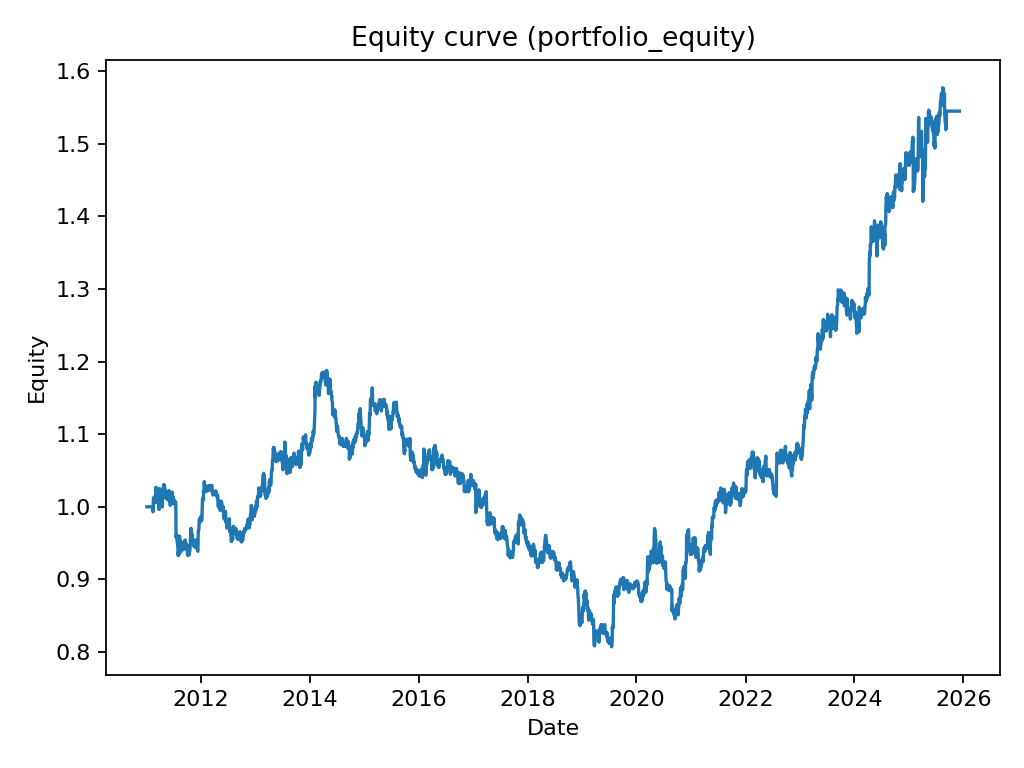

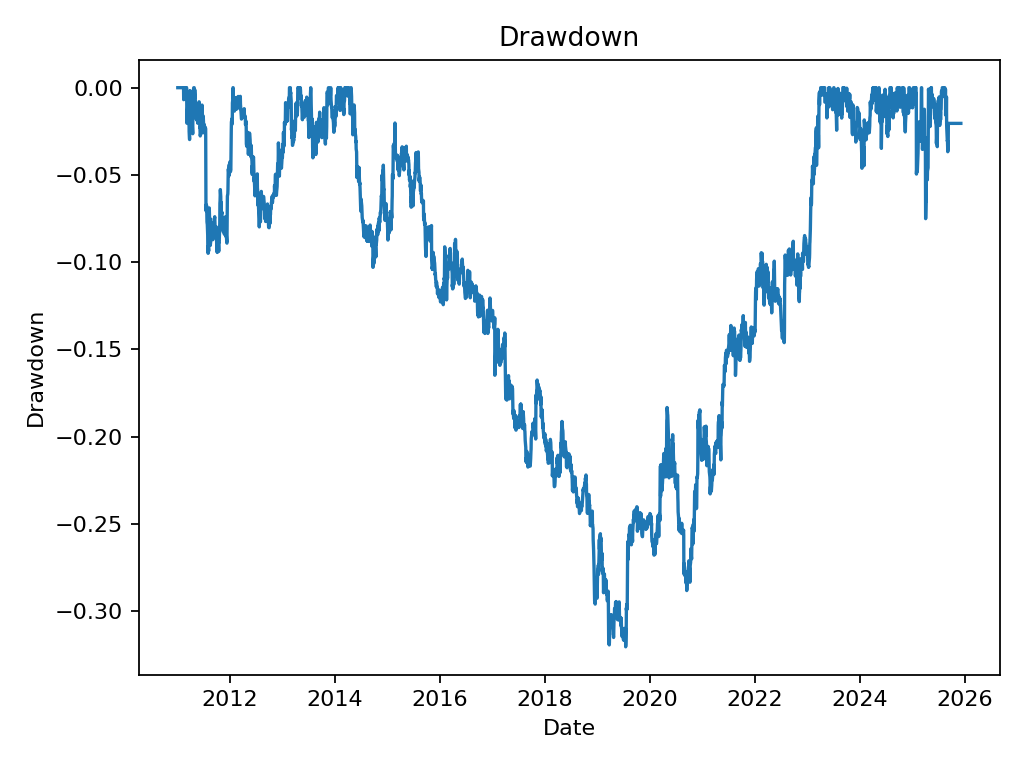

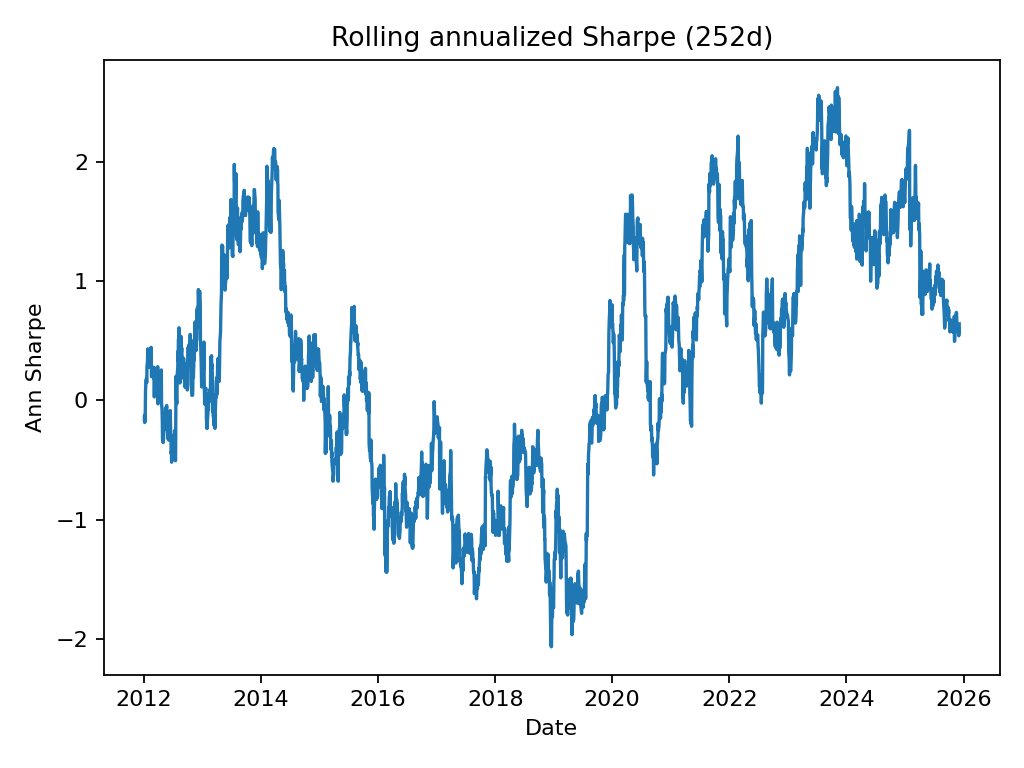

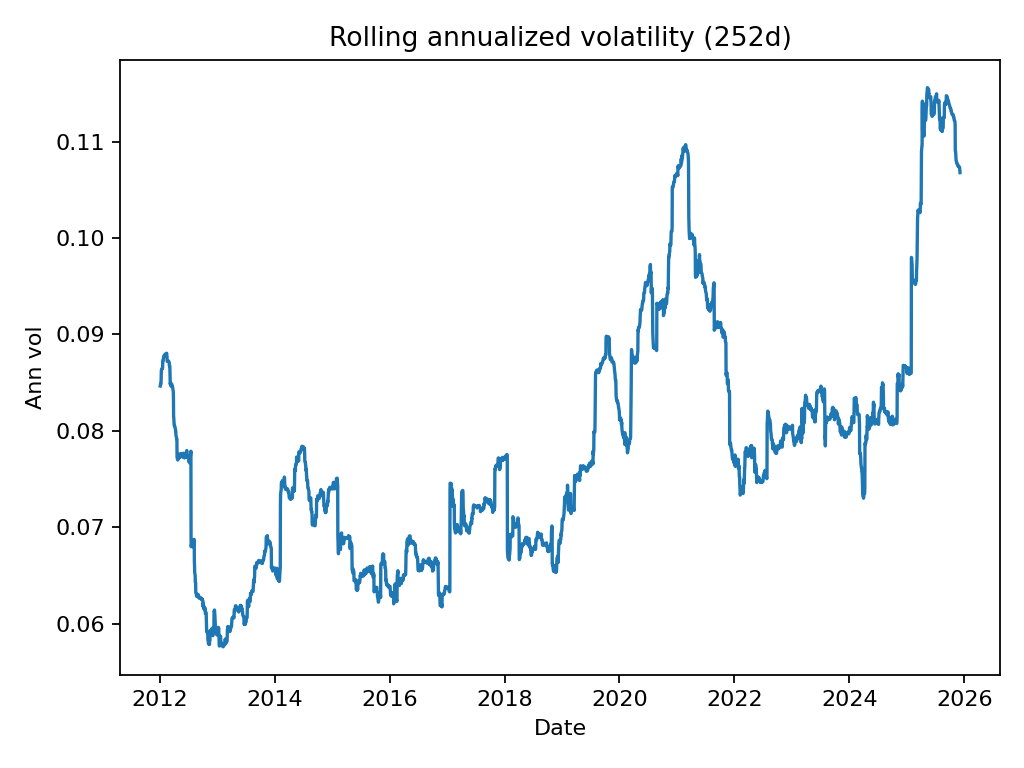

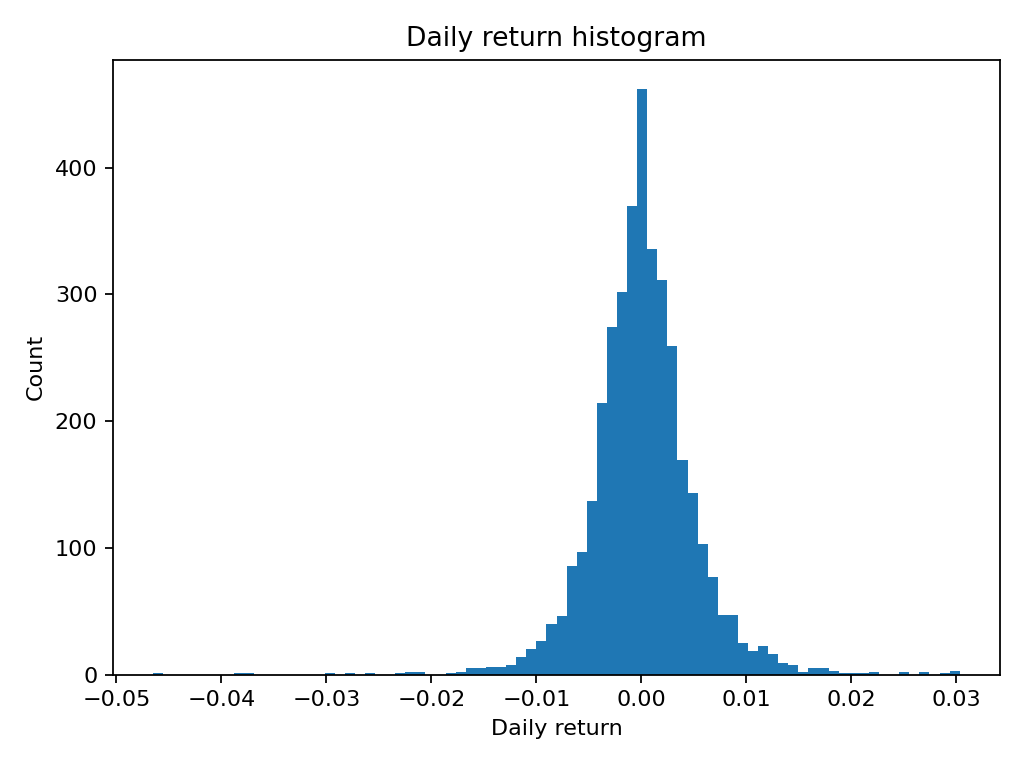

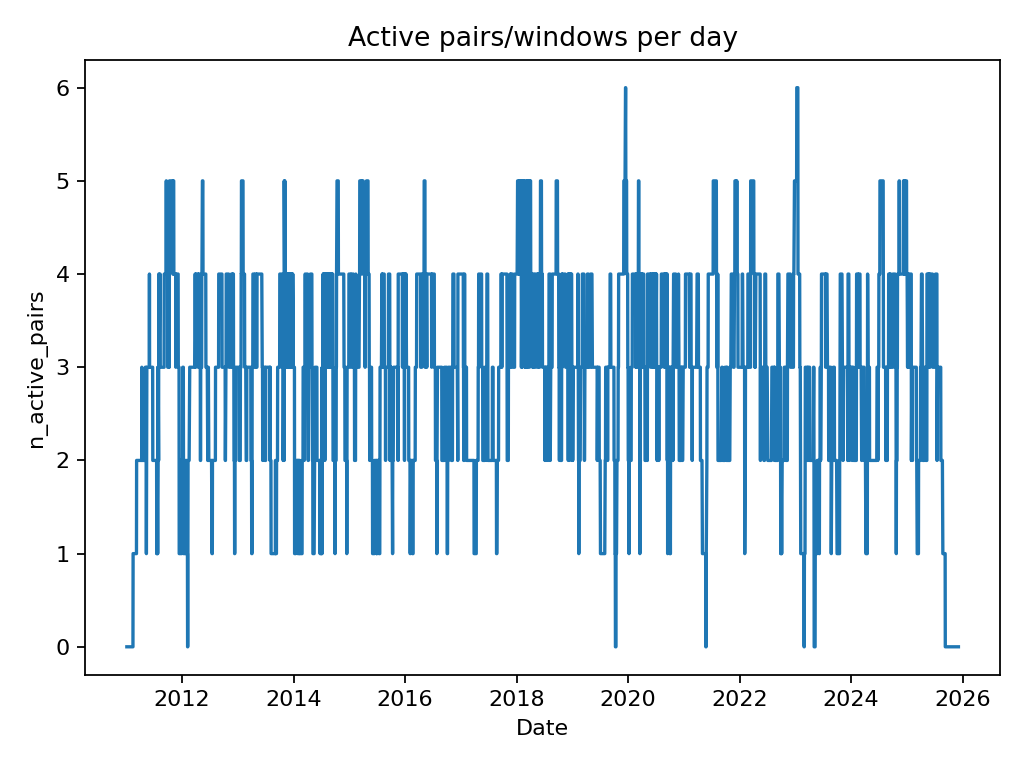

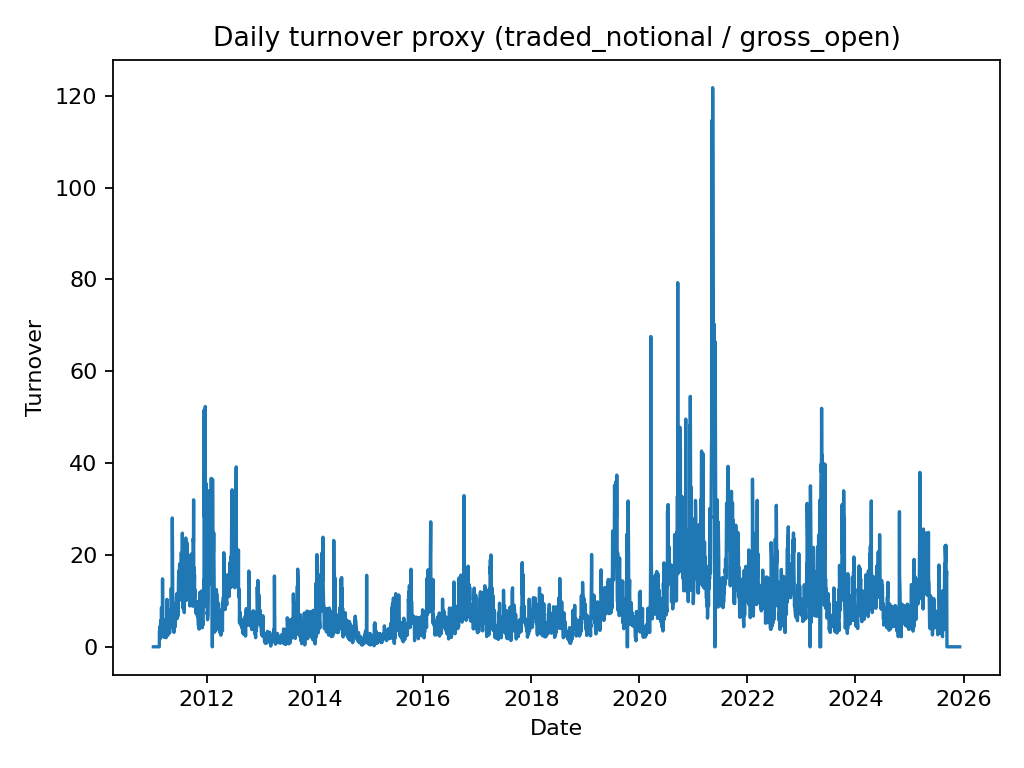

📌 Cell 10 summary_metrics.csv:


,0
date_start,2011-01-05
date_end,2025-12-05
n_days,3753
n_nan_returns_filled_as_zero,0
ann_return_geo,0.029638
ann_vol,0.079652
ann_sharpe,0.406536
ann_sortino,0.573292
max_drawdown,-0.320485
calmar,0.092478


— Year returns —


,year,year_return
0,2011,-0.016740
1,2012,0.010930
2,2013,0.081364
3,2014,0.021064
4,2015,-0.045045
5,2016,-0.011672
6,2017,-0.084000
7,2018,-0.114416
8,2019,0.064403
9,2020,0.051713


— Top 12 months —


,month,month_return
159,2024-04,0.058275
102,2019-07,0.056443
37,2014-02,0.053465
27,2013-04,0.049677
111,2020-04,0.045158
12,2012-01,0.043167
152,2023-09,0.038649
118,2020-11,0.038607
49,2015-02,0.036827
145,2023-02,0.034172


— Bottom 12 months —


,month,month_return
6,2011-07,-0.059825
95,2018-12,-0.056241
114,2020-07,-0.040241
98,2019-03,-0.036349
112,2020-05,-0.036094
121,2021-02,-0.033612
41,2014-06,-0.033398
83,2017-12,-0.033148
56,2015-09,-0.030632
115,2020-08,-0.029704


— Subperiod metrics (for your 'it worked in X era' claim) —


,period,n_days,ann_return_geo,ann_vol,ann_sharpe
0,2011–2019,2262,-0.012357,0.071578,-0.137894
1,2020–end,1491,0.096782,0.090414,1.067116


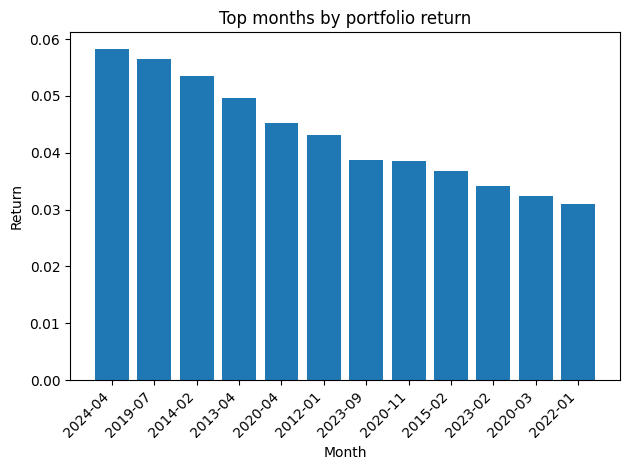

📌 Equity trough date: 2019-07-18 | trough equity: 0.807 | end equity: 1.545 | multiple from trough: 1.91x
— Top 25 pairs by total PnL (across windows) —


,y,x,windows,pnl_total,cost_total,trades,days,sharpe_ann_mean,sharpe_ann_median
142,JKHY,RSX,1,0.405895,0.002887,144,130,6.594260,6.594260
73,DHR,ISRG,1,0.267472,0.002765,124,127,3.762891,3.762891
21,AVY,DHI,1,0.264638,0.001916,184,125,3.178705,3.178705
134,INTU,VNQ,1,0.260848,0.002708,197,126,2.740575,2.740575
16,APH,EXR,1,0.258605,0.001826,132,129,3.435893,3.435893
108,EZA,VPU,1,0.244300,0.001844,98,123,4.622604,4.622604
51,CMI,IEX,1,0.229549,0.002626,96,128,4.090860,4.090860
24,BEN,PNR,1,0.223131,0.002000,183,128,2.488951,2.488951
89,EG,PEG,1,0.196201,0.001921,173,127,2.227528,2.227528
148,MCHP,NEE,1,0.190639,0.002020,173,125,1.990608,1.990608


— Bottom 25 pairs by total PnL (across windows) —


,y,x,windows,pnl_total,cost_total,trades,days,sharpe_ann_mean,sharpe_ann_median
67,CSX,IWM,1,-0.318890,0.001904,144,125,-2.451391,-2.451391
146,LRCX,NUE,1,-0.277904,0.017752,168,130,-5.745244,-5.745244
38,CDW,NVDA,1,-0.257315,0.004513,168,126,-1.971757,-1.971757
22,AVY,IYK,1,-0.233709,0.004974,111,128,-3.365229,-3.365229
25,BF-B,IDU,1,-0.224512,0.001776,131,128,-4.046853,-4.046853
48,CME,FITB,1,-0.210842,0.001904,179,130,-2.514961,-2.514961
11,AME,HBAN,1,-0.199409,0.002697,144,123,-2.872644,-2.872644
29,CAH,MA,1,-0.197331,0.001913,130,125,-2.706806,-2.706806
139,JBHT,JKHY,1,-0.194881,0.004203,108,129,-5.038496,-5.038496
13,AMT,INVH,1,-0.182796,0.001851,148,127,-2.329298,-2.329298


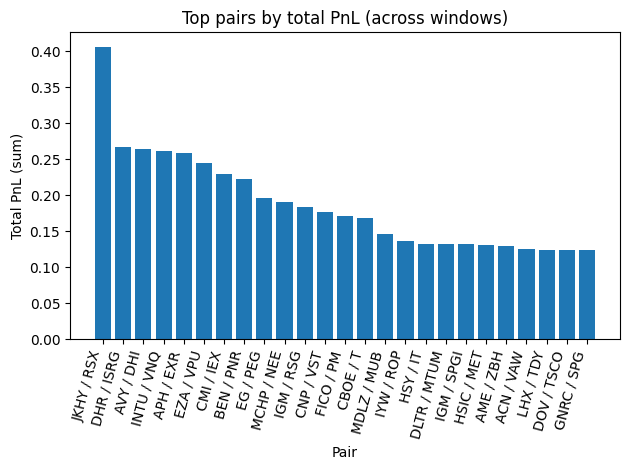

— Feature contrast (top vs bottom decile pairs) —


,feature,top10%_mean,bot10%_mean,top_minus_bottom
3,zc_rate,32.665166,33.696863,-1.031697
1,half_life,5.602923,6.580951,-0.978027
2,sigma,0.031873,0.030454,0.001419
0,coint_pval,0.009619,0.009733,-0.000114
4,adf_pvalue,0.002029,0.002050,-0.000021


📌 Interpretation note (for your talk): the table above is descriptive, not causal.
   It helps you say: 'successful pairs tended to have X characteristics during formation' without over-claiming.
— Formation rank bucket vs trading performance —


,rank_bucket,n,mean_pnl,median_pnl,mean_sharpe
0,0,1566,0.012715,0.042319,0.493238
1,1,1383,0.012437,0.043052,0.490366
2,2,1334,0.009555,0.039727,0.454098
3,3,1425,0.010196,0.039727,0.484559
4,4,1453,0.012592,0.039727,0.552753
5,5,1445,0.019217,0.048876,0.726759
6,6,1425,0.028690,0.050569,0.878888
7,7,1417,0.029913,0.051367,0.900951
8,8,1383,0.048748,0.051367,1.029145
9,9,1425,0.037723,0.050569,0.735198


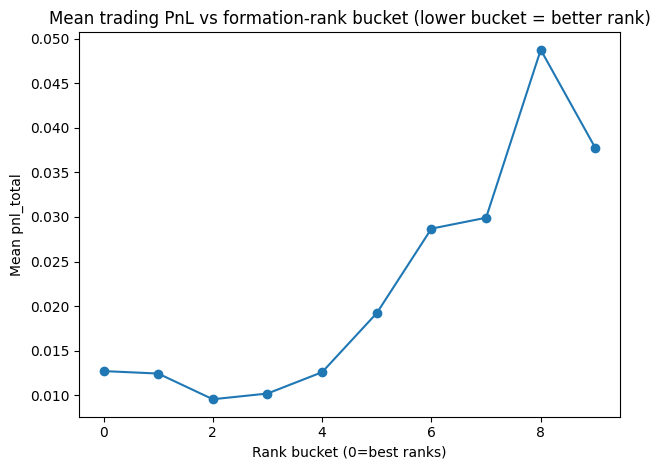

✅ Cell 11 investigation done.
📂 Saved tables/plots to: /content/drive/MyDrive/pairs_runs/RUN_20260103_045254/investigate
Key outputs:
- year_returns.csv, month_returns.csv, top_months.csv, bottom_months.csv, subperiod_metrics.csv
- top_pairs_by_pnl.csv, bottom_pairs_by_pnl.csv + top_pairs_pnl_bar.png
- feature_contrast_top_vs_bottom.csv (if available)
- rank_bucket_vs_performance.csv + rank_bucket_mean_pnl.png (if VALIDATED_DF join works)
- dq_summary.json


In [85]:
# ==============================
# Cell 11 — Investigation (pairs, periods, ranking vs performance)
# Goal: Produce interpretable tables/plots for the talk + report (no core logic changes).
# Reads consolidated parquet outputs under RUN_DIR.
# ==============================

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display, Image

# ------------------------------
# Paths
# ------------------------------
assert "RUN_DIR" in globals(), "RUN_DIR not found. Run Cell 9A first."
RUN_DIR = str(RUN_DIR)
DIAG_DIR = os.path.join(RUN_DIR, "diag")
INV_DIR  = os.path.join(RUN_DIR, "investigate")
os.makedirs(INV_DIR, exist_ok=True)

PORT_PATH = os.path.join(RUN_DIR, "portfolio_daily.parquet")
WS_PATH   = os.path.join(RUN_DIR, "window_summary.parquet")
PWR_PATH  = os.path.join(RUN_DIR, "pair_window_results.parquet")   # fallback
PD_PATH   = os.path.join(RUN_DIR, "pair_daily.parquet")            # optional (may be large)
EV_PATH   = os.path.join(RUN_DIR, "pair_trade_events.parquet")     # gating stats
EP_PATH   = os.path.join(RUN_DIR, "pair_trade_episodes.parquet")   # episode stats

# ------------------------------
# Helpers
# ------------------------------
def _pick(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _safe_num(s):
    return pd.to_numeric(s, errors="coerce")

def _subperiod_metrics(df_port, start=None, end=None, ann=252):
    d = df_port.copy()
    if start is not None:
        d = d[d["date"] >= pd.to_datetime(start)]
    if end is not None:
        d = d[d["date"] <= pd.to_datetime(end)]
    r = d["portfolio_return"].to_numpy(dtype=float)
    r = r[np.isfinite(r)]
    if len(r) < 2:
        return {"n_days": int(len(d)), "ann_return_geo": 0.0, "ann_vol": 0.0, "ann_sharpe": 0.0}
    g = float(np.prod(1.0 + r) ** (ann / len(r)) - 1.0)
    vol = float(np.std(r, ddof=1) * np.sqrt(ann))
    mu = float(np.mean(r)); sig = float(np.std(r, ddof=1))
    sh = float((mu / sig) * np.sqrt(ann)) if sig > 1e-12 else 0.0
    return {"n_days": int(len(d)), "ann_return_geo": g, "ann_vol": vol, "ann_sharpe": sh}

def _ensure_canonical_portfolio(port):
    port = port.copy()
    port["date"] = pd.to_datetime(port["date"], errors="coerce")
    port = port.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

    ret_col = _pick(port, ["portfolio_return", "ret_gross_weighted", "ret_gross"])
    eq_col  = _pick(port, ["portfolio_equity", "equity"])

    if ret_col is None:
        raise ValueError("No return column found in portfolio_daily (need portfolio_return or legacy alias).")
    port["portfolio_return"] = _safe_num(port[ret_col]).fillna(0.0)

    if eq_col is None:
        port["portfolio_equity"] = np.cumprod(1.0 + port["portfolio_return"].to_numpy(dtype=float))
    else:
        port["portfolio_equity"] = _safe_num(port[eq_col])
        # if equity has NaNs, rebuild as a fallback
        if port["portfolio_equity"].isna().any():
            port["portfolio_equity"] = np.cumprod(1.0 + port["portfolio_return"].to_numpy(dtype=float))

    return port

def _show_images_from_diag():
    if not os.path.isdir(DIAG_DIR):
        print("⚠️ DIAG_DIR not found; run Cell 10 first.")
        return
    # show a small curated set (easy-to-explain)
    imgs = [
        "equity_curve.png",
        "drawdown.png",
        "rolling_ann_sharpe.png",
        "rolling_ann_vol.png",
        "return_hist.png",
        "year_return_bar.png",
        "activity_n_active_pairs.png",
        "turnover.png",
    ]
    existing = [p for p in imgs if os.path.exists(os.path.join(DIAG_DIR, p))]
    if not existing:
        print("⚠️ No expected images found under DIAG_DIR. Did Cell 10 save them?")
        return
    print("📌 Cell 10 figures (loaded from Drive):")
    for p in existing:
        display(Image(filename=os.path.join(DIAG_DIR, p)))


# ==============================
# 0) Quick viewer for Cell 10 outputs (so you see results inline)
# ==============================
_show_images_from_diag()
if os.path.exists(os.path.join(DIAG_DIR, "summary_metrics.csv")):
    print("📌 Cell 10 summary_metrics.csv:")
    display(pd.read_csv(os.path.join(DIAG_DIR, "summary_metrics.csv")).T)


# ==============================
# 1) Portfolio: WHEN did we make money?
# ==============================
port_raw = pd.read_parquet(PORT_PATH)
port = _ensure_canonical_portfolio(port_raw)

# Year / month returns (easy story)
tmp = port[["date","portfolio_return"]].copy()
tmp["year"] = tmp["date"].dt.year
tmp["month"] = tmp["date"].dt.to_period("M").astype(str)

def _total_return(x):
    rr = x.to_numpy(dtype=float)
    rr = rr[np.isfinite(rr)]
    return float(np.prod(1.0 + rr) - 1.0) if len(rr) else 0.0

year_tbl = tmp.groupby("year")["portfolio_return"].apply(_total_return).reset_index(name="year_return")
month_tbl = tmp.groupby("month")["portfolio_return"].apply(_total_return).reset_index(name="month_return")

# Top/bottom months (good for presentation)
top_months = month_tbl.sort_values("month_return", ascending=False).head(12)
bot_months = month_tbl.sort_values("month_return", ascending=True).head(12)

year_tbl.to_csv(os.path.join(INV_DIR, "year_returns.csv"), index=False)
month_tbl.to_csv(os.path.join(INV_DIR, "month_returns.csv"), index=False)
top_months.to_csv(os.path.join(INV_DIR, "top_months.csv"), index=False)
bot_months.to_csv(os.path.join(INV_DIR, "bottom_months.csv"), index=False)

print("— Year returns —")
display(year_tbl)

print("— Top 12 months —")
display(top_months)

print("— Bottom 12 months —")
display(bot_months)

# Subperiod metrics: pre/post 2020 (matches your narrative)
pre = _subperiod_metrics(port, start="2011-01-01", end="2019-12-31")
post = _subperiod_metrics(port, start="2020-01-01", end=str(port["date"].max().date()))
subperiod_df = pd.DataFrame([
    {"period":"2011–2019", **pre},
    {"period":"2020–end", **post},
])
subperiod_df.to_csv(os.path.join(INV_DIR, "subperiod_metrics.csv"), index=False)

print("— Subperiod metrics (for your 'it worked in X era' claim) —")
display(subperiod_df)

# Plot: monthly returns bar (easy visual)
plt.figure()
plt.bar(top_months["month"], top_months["month_return"])
plt.xticks(rotation=45, ha="right")
plt.title("Top months by portfolio return")
plt.xlabel("Month"); plt.ylabel("Return")
plt.tight_layout()
plt.savefig(os.path.join(INV_DIR, "top_months_bar.png"), dpi=160)
plt.show()

# Identify trough-to-peak story (recovery narrative)
eq = port["portfolio_equity"].to_numpy(dtype=float)
dates = port["date"].to_numpy()
trough_idx = int(np.nanargmin(eq))
trough_date = pd.to_datetime(dates[trough_idx]).date()
trough_eq = float(eq[trough_idx])
end_eq = float(eq[-1])
recovery_mult = (end_eq / trough_eq) if trough_eq > 0 else np.nan

print(f"📌 Equity trough date: {trough_date} | trough equity: {trough_eq:.3f} | end equity: {end_eq:.3f} | multiple from trough: {recovery_mult:.2f}x")
with open(os.path.join(INV_DIR, "trough_recovery.json"), "w") as f:
    json.dump({"trough_date": str(trough_date), "trough_equity": trough_eq, "end_equity": end_eq, "multiple_from_trough": recovery_mult}, f, indent=2)


# ==============================
# 2) Pairs: WHICH pairs contributed most?
# ==============================
ws = None
if os.path.exists(WS_PATH):
    ws = pd.read_parquet(WS_PATH)
elif os.path.exists(PWR_PATH):
    ws = pd.read_parquet(PWR_PATH)

if ws is None:
    raise FileNotFoundError("Missing window_summary.parquet and pair_window_results.parquet. Need one to rank pairs.")

# Required fields
for col in ["y","x","pnl_total","sharpe_ann","n_days","n_trades"]:
    if col not in ws.columns:
        # allow missing sharpe_ann if older; then skip that part
        pass

ws["pnl_total"] = _safe_num(ws.get("pnl_total", np.nan))
ws["sharpe_ann"] = _safe_num(ws.get("sharpe_ann", np.nan))
ws["n_days"] = _safe_num(ws.get("n_days", np.nan))
ws["n_trades"] = _safe_num(ws.get("n_trades", np.nan))
ws["cost_total"] = _safe_num(ws.get("cost_total", np.nan))

# Fix run_window_id if missing
if "run_window_id" not in ws.columns:
    if "window_id" in ws.columns:
        ws["run_window_id"] = ws["window_id"]
    else:
        # fallback: assume one window per row if all else fails, or skip
        ws["run_window_id"] = np.arange(len(ws))

# Aggregate by pair across all windows
pair_agg = ws.groupby(["y","x"]).agg(
    windows=("run_window_id","nunique") if "run_window_id" in ws.columns else ("y","size"),
    pnl_total=("pnl_total","sum"),
    cost_total=("cost_total","sum"),
    trades=("n_trades","sum"),
    days=("n_days","sum"),
    sharpe_ann_mean=("sharpe_ann","mean"),
    sharpe_ann_median=("sharpe_ann","median"),
).reset_index()

pair_agg = pair_agg.sort_values("pnl_total", ascending=False)

top_pairs = pair_agg.head(25)
bottom_pairs = pair_agg.tail(25).sort_values("pnl_total", ascending=True)

top_pairs.to_csv(os.path.join(INV_DIR, "top_pairs_by_pnl.csv"), index=False)
bottom_pairs.to_csv(os.path.join(INV_DIR, "bottom_pairs_by_pnl.csv"), index=False)

print("— Top 25 pairs by total PnL (across windows) —")
display(top_pairs)

print("— Bottom 25 pairs by total PnL (across windows) —")
display(bottom_pairs)

# Plot top pairs (bar)
plt.figure()
labels = (top_pairs["y"] + " / " + top_pairs["x"]).to_list()
plt.bar(range(len(top_pairs)), top_pairs["pnl_total"].to_numpy(dtype=float))
plt.xticks(range(len(top_pairs)), labels, rotation=75, ha="right")
plt.title("Top pairs by total PnL (across windows)")
plt.xlabel("Pair"); plt.ylabel("Total PnL (sum)")
plt.tight_layout()
plt.savefig(os.path.join(INV_DIR, "top_pairs_pnl_bar.png"), dpi=160)
plt.show()


# ==============================
# 3) “Why might it work?” (lightweight, defensible, not causal claims)
# ==============================
# Simple feature contrasts: compare top vs bottom decile pairs on formation diagnostics (if present).
feature_cols = [c for c in ["coint_pval","half_life","sigma","zc_rate","dist","adf_pvalue"] if c in ws.columns]
why_tbl = None
if feature_cols:
    # build pair-level features by averaging ws-level features
    feat = ws.groupby(["y","x"])[feature_cols].mean().reset_index()
    merged = pd.merge(pair_agg[["y","x","pnl_total"]], feat, on=["y","x"], how="left")

    merged = merged.dropna(subset=["pnl_total"])
    n = len(merged)
    if n >= 20:
        q = int(max(5, n * 0.10))
        top_dec = merged.nlargest(q, "pnl_total")
        bot_dec = merged.nsmallest(q, "pnl_total")

        rows = []
        for c in feature_cols:
            rows.append({
                "feature": c,
                "top10%_mean": float(pd.to_numeric(top_dec[c], errors="coerce").mean()),
                "bot10%_mean": float(pd.to_numeric(bot_dec[c], errors="coerce").mean()),
                "top_minus_bottom": float(pd.to_numeric(top_dec[c], errors="coerce").mean() - pd.to_numeric(bot_dec[c], errors="coerce").mean()),
            })
        why_tbl = pd.DataFrame(rows).sort_values("top_minus_bottom", key=lambda s: s.abs(), ascending=False)
        why_tbl.to_csv(os.path.join(INV_DIR, "feature_contrast_top_vs_bottom.csv"), index=False)

        print("— Feature contrast (top vs bottom decile pairs) —")
        display(why_tbl)

print("📌 Interpretation note (for your talk): the table above is descriptive, not causal.")
print("   It helps you say: 'successful pairs tended to have X characteristics during formation' without over-claiming.")


# ==============================
# 4) Formation ranking vs trading performance (if VALIDATED_DF is available)
# ==============================
rank_report = {"status": "skipped", "reason": ""}

val = None
if "VALIDATED_DF" in globals():
    try:
        val = VALIDATED_DF.copy()
    except Exception:
        val = None

# Try common file names if not in memory (safe, no hard assumptions)
if val is None:
    candidates = [
        os.path.join(RUN_DIR, "validated_df.parquet"),
        os.path.join(RUN_DIR, "validated_pairs.parquet"),
        os.path.join(RUN_DIR, "validated.parquet"),
        # Fallback to local if not found in RUN_DIR (Cell 7 output)
        "validated_pairs_all_windows.csv"
    ]
    for p in candidates:
        if os.path.exists(p):
            if p.endswith(".csv"):
                val = pd.read_csv(p)
            else:
                val = pd.read_parquet(p)
            break

if val is None:
    rank_report["status"] = "skipped"
    rank_report["reason"] = "VALIDATED_DF not found in memory and no validated*.parquet found under RUN_DIR."
    print("⚠️ Ranking analysis skipped:", rank_report["reason"])
else:
    # --- FIX: Ensure run_window_id exists in VAL ---
    if "run_window_id" not in val.columns:
        if "window_id" in val.columns:
            val["run_window_id"] = val["window_id"]
        else:
            # Try index if it looks like int
            val["run_window_id"] = np.nan

    # --- FIX: Ensure run_window_id exists in WS ---
    if "run_window_id" not in ws.columns:
        if "window_id" in ws.columns:
            ws["run_window_id"] = ws["window_id"]

    # Need rank_in_window and run_window_id to join
    if "rank_in_window" not in val.columns:
        rank_report["status"] = "skipped"
        rank_report["reason"] = "VALIDATED_DF exists but rank_in_window column is missing."
        print("⚠️ Ranking analysis skipped:", rank_report["reason"])
    elif "run_window_id" not in val.columns or "run_window_id" not in ws.columns:
        rank_report["status"] = "skipped"
        rank_report["reason"] = "Missing run_window_id in VALIDATED_DF or window_summary, cannot join."
        print("⚠️ Ranking analysis skipped:", rank_report["reason"])
    else:
        # join validated (formation rank) with realized trading performance
        keep_val = ["run_window_id","rank_in_window"]
        for c in ["y","x","formation_end","trading_end","coint_pval","half_life","sigma","zc_rate","dist"]:
            if c in val.columns:
                keep_val.append(c)

        v = val[keep_val].copy()
        v["run_window_id"] = _safe_num(v["run_window_id"])
        v["rank_in_window"] = _safe_num(v["rank_in_window"])
        ws["run_window_id"] = _safe_num(ws["run_window_id"])

        j = pd.merge(ws, v, on="run_window_id", how="inner", suffixes=("","_val"))

        # Performance target
        j["pnl_total"] = _safe_num(j.get("pnl_total", np.nan))
        j["sharpe_ann"] = _safe_num(j.get("sharpe_ann", np.nan))

        # Bucket ranks into deciles (easy-to-explain)
        j = j.dropna(subset=["rank_in_window","pnl_total"])
        if len(j) < 50:
            rank_report["status"] = "skipped"
            rank_report["reason"] = f"Too few joined rows ({len(j)}) for a meaningful rank study."
            print("⚠️ Ranking analysis skipped:", rank_report["reason"])
        else:
            # lower rank_in_window is better (rank 1 best)
            j["rank_bucket"] = pd.qcut(j["rank_in_window"], 10, labels=False, duplicates="drop")  # 0..9
            bucket = j.groupby("rank_bucket").agg(
                n=("pnl_total","size"),
                mean_pnl=("pnl_total","mean"),
                median_pnl=("pnl_total","median"),
                mean_sharpe=("sharpe_ann","mean"),
            ).reset_index()

            bucket.to_csv(os.path.join(INV_DIR, "rank_bucket_vs_performance.csv"), index=False)

            print("— Formation rank bucket vs trading performance —")
            display(bucket)

            plt.figure()
            plt.plot(bucket["rank_bucket"], bucket["mean_pnl"], marker="o")
            plt.title("Mean trading PnL vs formation-rank bucket (lower bucket = better rank)")
            plt.xlabel("Rank bucket (0=best ranks)"); plt.ylabel("Mean pnl_total")
            plt.tight_layout()
            plt.savefig(os.path.join(INV_DIR, "rank_bucket_mean_pnl.png"), dpi=160)
            plt.show()

            rank_report["status"] = "ok"
            rank_report["n_joined_rows"] = int(len(j))
            rank_report["note"] = "Descriptive relationship only; does not prove causality."

with open(os.path.join(INV_DIR, "rank_report.json"), "w") as f:
    json.dump(rank_report, f, indent=2)


# ==============================
# 5) Gating / data-quality stats (events table)
# ==============================
ev = None
if os.path.exists(EV_PATH):
    ev = pd.read_parquet(EV_PATH)

dq_summary = {}
if ev is not None:
    if "event_type" in ev.columns:
        vc = ev["event_type"].value_counts(dropna=False)
        dq_summary["event_type_counts"] = {str(k): int(v) for k, v in vc.items()}
    for c in ["corp_event","dq_event","split_event","dq_gate_effective"]:
        if c in ev.columns:
            x = pd.Series(ev[c]).fillna(False).astype(bool)
            dq_summary[f"{c}_count"] = int(x.sum())
            dq_summary[f"{c}_rate"] = float(x.mean())

with open(os.path.join(INV_DIR, "dq_summary.json"), "w") as f:
    json.dump(dq_summary, f, indent=2)

print("✅ Cell 11 investigation done.")
print(f"📂 Saved tables/plots to: {INV_DIR}")
print("Key outputs:")
print("- year_returns.csv, month_returns.csv, top_months.csv, bottom_months.csv, subperiod_metrics.csv")
print("- top_pairs_by_pnl.csv, bottom_pairs_by_pnl.csv + top_pairs_pnl_bar.png")
print("- feature_contrast_top_vs_bottom.csv (if available)")
print("- rank_bucket_vs_performance.csv + rank_bucket_mean_pnl.png (if VALIDATED_DF join works)")
print("- dq_summary.json")

In [70]:
# ============================================================
# Cell 11B — Download Analysis Results (Cell 10 & 11 outputs)
# ============================================================
import os, shutil
from google.colab import files

assert "RUN_DIR" in globals(), "❌ RUN_DIR missing. Run previous cells first."

# 1. Define source directories
diag_dir = os.path.join(RUN_DIR, "diag")
inv_dir = os.path.join(RUN_DIR, "investigate")

# 2. Prepare temp folder for zipping
base_name = "analysis_results_export"
temp_root = os.path.join("/content", base_name)
if os.path.exists(temp_root):
    shutil.rmtree(temp_root)
os.makedirs(temp_root, exist_ok=True)

found_files = 0

# 3. Copy folders
if os.path.exists(diag_dir):
    dest = os.path.join(temp_root, "diag")
    shutil.copytree(diag_dir, dest)
    print(f"✅ Included: diag folder ({len(os.listdir(diag_dir))} files)")
    found_files += len(os.listdir(diag_dir))
else:
    print("⚠️ Warning: diag folder not found.")

if os.path.exists(inv_dir):
    dest = os.path.join(temp_root, "investigate")
    shutil.copytree(inv_dir, dest)
    print(f"✅ Included: investigate folder ({len(os.listdir(inv_dir))} files)")
    found_files += len(os.listdir(inv_dir))
else:
    print("⚠️ Warning: investigate folder not found.")

# 4. Zip and Download
if found_files > 0:
    zip_path = shutil.make_archive("/content/" + base_name, 'zip', temp_root)
    print(f"\n📦 Created ZIP: {zip_path}")
    files.download(zip_path)
    print("⬇️ Download triggered.")
else:
    print("❌ No analysis files found to download.")

✅ Included: diag folder (18 files)
✅ Included: investigate folder (15 files)

📦 Created ZIP: /content/analysis_results_export.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Download triggered.


## 🧪 Module 11 — Full-Engine Optimizer + CSCV/PBO (Drive-safe, reproducible)

**Purpose:** run a “full-engine” parameter search (entry/exit/stop/time-stop) across all validated pair-windows, then estimate **overfitting risk** using **CSCV** and **PBO**.  
This module is designed to be **resume-safe** (Colab/Drive), **run-isolated** (outputs live under `RUN_DIR`), and **reproducible** (fingerprint includes code hash).

---

### 0) What this module depends on (must already exist)
This module *calls the exact same core engine used by the main pipeline*:

- `make_signal_pack(...)` (Module 8) — builds the base window timeline and z-series.
- `z_to_pos_and_exitcode(...)` (Module 8) — generates position signals for a given parameter set.
- `make_exec_pack(...)` (Cell 9B) — aligns execution arrays + flags (`corp_event`, `split_event`, `dq_event`, missing data).
- `backtest_engine(...)` (Cell 9C) — simulates open-execution + costs/slippage + daily PnL.

Also required:
- `VALIDATED_DF`, `prices_df`
- `EXEC_CFG` (execution sizing/costs + event gate policy)
- `RUN_DIR` (from Cell 9A) for clean output isolation

:contentReference[oaicite:0]{index=0}

---

### 1) Output isolation (why this prevents run-mixing)
All optimizer artifacts are written under:

- `OPT_RUN_ROOT_FULL = RUN_DIR`
- `OPT_DIR_FULL = RUN_DIR/opt/OPT_TAG_FULL/`

So a new research run automatically produces a clean optimizer folder, without reusing outputs from older runs.

---

### 2) Reproducibility: ENGINE_VERSION + ENGINE_HASH in fingerprint
This module defines:

- `ENGINE_VERSION`: manual version string (bump this whenever engine semantics change).
- `ENGINE_HASH`: SHA1 over the *source text* of:
  - `make_exec_pack`
  - `backtest_engine`
  - `z_to_pos_and_exitcode`

These are injected into the fingerprint that builds `OPT_TAG_FULL`.  
**Meaning:** if the logic changes but the scenario config stays the same, the optimizer will **not** silently reuse old results.

---

### 3) Scenario space (what is being optimized)
A “scenario” is one parameter set:

- `entry_z` in [entry_z_min .. entry_z_max] step entry_z_step
- `exit_mode` in { "cross", "band" }
  - if "cross": exit_z = 0
  - if "band": exit_z in [exit_z_min .. exit_z_max]
- `stop_z` in [stop_z_min .. stop_z_max]
- `time_stop_bars` in [time_stop_min .. time_stop_max]
- repeated random draws per entry level (`n_per_entry`) using a seeded RNG

This defines `TOTAL_SCEN` scenarios.

---

### 4) Window cache (performance + consistency)
Before evaluating scenarios, this module builds `WINDOW_CACHE` once:

For each row in `VALIDATED_DF`:
1) Build `sp = make_signal_pack(row)`  
2) Apply **Z_SANITY gate** (hard/soft thresholds on the z-series)  
3) Build `ep = make_exec_pack(sp)`  
4) Store `(base, ep)` where `base` contains:
   - z-series (`z_series`, `z_arr`)
   - window timeline `idx`
   - hedge ratio `beta`
   - `lag`
   - precomputed `bars_to_end_exec` (for time-stop / end-of-window forced exits)

**Why cache:** scenarios change signal thresholds, but execution alignment + flags do not; caching prevents repeated expensive reindexing.

---

### 5) Timeline standardization for CSCV blocks
This module defines an optimizer timeline `OPT_IDX` spanning:
- from min formation_end → max trading_end (bounded by the available `prices_df` index)

Then it assigns every day in `OPT_IDX` to a block id:
- `S` total blocks (must be even), `block_id[t] in {0..S-1}`

These blocks are later used to compute train/test Sharpe for CSCV.

---

### 6) Return definition used inside the optimizer (IMPORTANT)
For each scenario, this module loops over all cached windows and accumulates, per day `t`:

- `pnl_sum[t]` = sum of window daily PnL on day t  
- `gross_sum[t]` = sum of window gross notional open on day t

Then it defines scenario daily return series:

- If `gross_sum[t] > eps`: `ret[t] = pnl_sum[t] / gross_sum[t]`
- Else: `ret[t] = 0`

This is a **gross-weighted portfolio return** (often used as a stable “return-on-gross” aggregation).

**Consistency note (with Option B):**
- Option B (equal allocation across active windows) uses:
  - `ret_B[t] = (1/N_t) * sum_{i active} (PnL_i[t] / Gross_i[t])`
- This optimizer currently uses **ret_A[t] = (sum_i PnL_i[t]) / (sum_i Gross_i[t])**.

Both are defensible, but they are **not the same** when gross differs across windows or when some windows are intermittently inactive.  
For a clean paper narrative: either (a) keep the paper/diagnostics aligned with this definition, or (b) switch the optimizer to Option B so “optimization metric == reported portfolio metric”.

---

### 7) Sharpe definition (standard, annualized, from daily returns)
Given daily return series `ret[t]` and annual trading days `ANN` (e.g., 252):

- `rf_daily = rf_annual / ANN`
- `x[t] = ret[t] - rf_daily`
- `mean = average(x)`
- `std = sample_std(x)` (ddof=1)
- `Sharpe_ann = sqrt(ANN) * mean / (std + eps)`

This is used for:
- `sharpe_ann_full` (full-period Sharpe for the scenario)
- CSCV train/test Sharpes computed from block aggregates

---

### 8) Block aggregates (enables CSCV without storing full daily series)
For each scenario:
- Compute `ret_sum[b]  = sum of ret[t] over days in block b`
- Compute `ret_sumsq[b] = sum of ret[t]^2 over days in block b`
- Compute `ret_n[b] = number of days in block b`

These are saved into the scenario row as:
- `ret_sum_00 ... ret_sum_15`
- `ret_sumsq_00 ... ret_sumsq_15`
- `ret_n_00 ... ret_n_15`

Later, Sharpe for any union of blocks is computed from aggregates:

- mean = (sum ret) / n
- var  = (sum ret^2 - n*mean^2) / (n-1)
- Sharpe_ann = sqrt(ANN) * (mean - rf_daily) / (sqrt(var) + eps)
- if n < 2: Sharpe_ann = 0

---

### 9) CSCV + PBO (what is measured)
**CSCV loop:**
- Randomly choose `test_size` blocks as test
- “Purge” neighboring blocks around test blocks by `purge` to reduce leakage
- Remaining blocks are train

For each split:
1) Compute `sh_is` (in-sample annualized Sharpe) for every scenario on train blocks
2) Select the best scenario by `argmax(sh_is)`
3) Evaluate its `sh_oos` (out-of-sample Sharpe) on test blocks
4) Record the selected scenario’s rank percentile in OOS:
   - `rank_pct = (# scenarios with higher sh_oos than selected) / N`

**PBO (Probability of Backtest Overfitting):**
- `PBO = mean( rank_pct > 0.5 )`
Interpretation:
- If the scenario picked by IS performance tends to land in the *bottom half* OOS, PBO rises.

This module prints `PBO (Full)` and saves a CSCV table.

---

### 10) Drive-safe checkpointing (why this survives Colab)
During scenario evaluation:
- results are buffered, then written as `opt_full_part_XXXXX.parquet`
- progress is written to `opt_progress.json` (atomic overwrite)
- on rerun, it resumes from `next_scenario_id` and dedupes by `scenario_id` during consolidation

So disconnects should not destroy the whole run.

---

### 11) Artifacts produced by this module
Under `OPT_DIR_FULL`:

- `parts/opt_full_part_XXXXX.parquet`  (checkpoint parts)
- `opt_scenarios.parquet`              (consolidated scenario table)
- `opt_cscv.parquet`                   (scenario table + selected counts + full sharpe vec)
- `opt_meta.json`                      (fingerprint, engine hash, sharpe definition, PBO, etc.)

And it sets:
- `OPT_DIR`, `OPT_TAG` as the “active optimizer context” for later reporting/plots.

---

### 12) Practical reading guide (what to report in the paper)
Minimum set usually reported:
- `PBO (Full)`
- Top-k scenarios by `sharpe_ann_full_vec`
- `selected_cnt` distribution (how often top scenario wins across CSCV splits)
- sanity stats: `active_day_frac`, turnover proxy, number of windows actually run

If the paper’s headline performance uses **Option B** portfolio returns, ensure:
- optimizer metric and paper metric are consistent, or
- explicitly justify why optimization uses “return-on-gross weighted” while the portfolio reporting uses “cap-consistent equal allocation”.



In [71]:
# ==============================
# Cell 12 — FULL ENGINE Optimizer + CSCV/PBO (S=16) + Checkpoint
# FIXED: (1) OPT root uses RUN_DIR (no RUN_MAIN mix)
#        (2) Fingerprint includes ENGINE_VERSION + ENGINE_HASH
#        (3) Uses STANDARD annualized Sharpe from DAILY returns (return-on-gross)
#        (4) CSCV uses annualized Sharpe computed on daily returns within train/test blocks
# ==============================

import os, time, math, json, glob, shutil, hashlib, inspect
import numpy as np
import pandas as pd
from IPython.display import display
from joblib import Parallel, delayed

# --- tqdm ---
try:
    from tqdm.notebook import tqdm
    print("✅ tqdm.notebook loaded.")
except ImportError:
    from tqdm import tqdm
    print("⚠️ tqdm.notebook missing, using standard tqdm.")

# -----------------------------
# 15.0) Asserts
# -----------------------------
assert "prices_df" in globals() and isinstance(prices_df, pd.DataFrame), "❌ prices_df missing."
assert "VALIDATED_DF" in globals() and isinstance(VALIDATED_DF, pd.DataFrame), "❌ VALIDATED_DF missing."
assert "make_signal_pack" in globals(), "❌ Need make_signal_pack (Cell 8)."
assert "z_to_pos_and_exitcode" in globals(), "❌ Need z_to_pos_and_exitcode (Cell 8)."
assert "make_exec_pack" in globals(), "❌ Need make_exec_pack (Cell 9B)."
assert "backtest_engine" in globals(), "❌ Need backtest_engine (Cell 9C)."
assert "EXEC_CFG" in globals() and isinstance(EXEC_CFG, dict), "❌ Need EXEC_CFG (Cell 9B)."
assert "RUN_DIR" in globals() and isinstance(RUN_DIR, str), "❌ Need RUN_DIR from Cell 9A (run isolation)."

# -----------------------------
# 15.1) Persistent output dir (ISOLATED per RUN_DIR)
# -----------------------------
# ✅ Minimal fix: optimizer output lives inside THIS run folder, not RUN_MAIN.
OPT_RUN_ROOT_FULL = RUN_DIR
os.makedirs(OPT_RUN_ROOT_FULL, exist_ok=True)
print(f"✅ OPT_RUN_ROOT_FULL = RUN_DIR: {OPT_RUN_ROOT_FULL}")

# -----------------------------
# 15.1.1) Engine version + code hash (for reproducibility / no accidental reuse)
# -----------------------------
ENGINE_VERSION = "2025-12-30_sharpe_ann_cscv_v1"  # change when engine changes

def _hash_fn(fn):
    try:
        src = inspect.getsource(fn)
    except Exception:
        src = repr(fn)
    return hashlib.sha1(src.encode("utf-8")).hexdigest()[:12]

ENGINE_HASH = {
    "make_exec_pack": _hash_fn(make_exec_pack),
    "backtest_engine": _hash_fn(backtest_engine),
    "z_to_pos_and_exitcode": _hash_fn(z_to_pos_and_exitcode),
}
print("✅ ENGINE_VERSION:", ENGINE_VERSION)
print("✅ ENGINE_HASH:", ENGINE_HASH)

# -----------------------------
# 15.2) OPT knobs (FULL ENGINE)
# -----------------------------
OPT_CFG_FULL = {
    "seed": 7,
    "S": 16,
    "test_size": 8,
    "purge": 1,
    "n_splits": 12870,

    # Exploration
    "entry_z_min": 1.00,
    "entry_z_max": 2.50,
    "entry_z_step": 0.05,
    "exit_modes": ["cross", "band"],
    "exit_z_min": 0.00,
    "exit_z_max": 1.00,
    "exit_z_step": 0.05,
    "stop_z_min": 3.00,
    "stop_z_max": 8.00,
    "stop_z_step": 0.10,
    "time_stop_min": 10,
    "time_stop_max": 80,
    "time_stop_step": 1,

    # Runtime
    "n_per_entry": 20,
    "max_scenarios": None,
    "max_windows": None,
    "checkpoint_every": 5,

    # Gates
    "z_gate_enable": True,
    "z_hard_max_abs": 20.0,
    "z_soft_max_abs": 15.0,
    "z_soft_frac_gt10": 0.20,
    "z_soft_min_obs": 40,

    # Sharpe convention
    "trading_days_per_year": 252,
    "risk_free_annual": 0.0,  # keep 0.0 unless you explicitly model rf
}

# -----------------------------
# 15.2.1) Fingerprint tag (avoid mixing runs)
# -----------------------------
def _stable_hash(obj) -> str:
    s = json.dumps(obj, sort_keys=True, default=str).encode("utf-8")
    return hashlib.sha1(s).hexdigest()[:10]

BT_SNAPSHOT = dict(BT) if ("BT" in globals() and isinstance(BT, dict)) else None

_FPRINT_OBJ = {
    "OPT_CFG_FULL": OPT_CFG_FULL,
    "EXEC_CFG": EXEC_CFG,
    "BT": BT_SNAPSHOT,
    "VALIDATED_shape": tuple(VALIDATED_DF.shape),
    "ENGINE_VERSION": ENGINE_VERSION,
    "ENGINE_HASH": ENGINE_HASH,
    "RUN_ID": (RUN_ID if "RUN_ID" in globals() else None),
}
_FPRINT = _stable_hash(_FPRINT_OBJ)

# --- FIX: Force Resume logic ---
# Tự động phát hiện thư mục cũ nếu người dùng muốn resume
# Ở đây ta hardcode tag cũ để resume 40%
FORCE_RESUME_TAG = "FULL_ENGINE_OPT_c6049f710a"  # <--- ID CŨ CỦA BẠN

if FORCE_RESUME_TAG:
    print(f"⚠️ FORCING RESUME from specific tag: {FORCE_RESUME_TAG}")
    OPT_TAG_FULL = FORCE_RESUME_TAG
else:
    OPT_TAG_FULL = f"FULL_ENGINE_OPT_{_FPRINT}"

OPT_DIR_FULL = os.path.join(OPT_RUN_ROOT_FULL, "opt", OPT_TAG_FULL)
PARTS_DIR_FULL = os.path.join(OPT_DIR_FULL, "parts")
os.makedirs(PARTS_DIR_FULL, exist_ok=True)

SCEN_RESULTS_PATH_FULL = os.path.join(OPT_DIR_FULL, "opt_scenarios.parquet")
CSCV_RESULTS_PATH_FULL = os.path.join(OPT_DIR_FULL, "opt_cscv.parquet")
META_PATH_FULL = os.path.join(OPT_DIR_FULL, "opt_meta.json")
PROGRESS_PATH_FULL = os.path.join(OPT_DIR_FULL, "opt_progress.json")

print(f"✅ OPT_TAG_FULL={OPT_TAG_FULL}")
print(f"✅ OPT_DIR_FULL={OPT_DIR_FULL}")

# -----------------------------
# 15.3) Helpers
# -----------------------------
def _atomic_write_json(path, obj):
    tmp = path + ".tmp"
    with open(tmp, "w") as f:
        json.dump(obj, f, indent=2, default=str)
    os.replace(tmp, path)

def _atomic_to_parquet(df, path):
    tmp = path + ".tmp"
    df.to_parquet(tmp, index=False)
    os.replace(tmp, path)

def frange(a, b, step):
    n = int(np.floor((b - a) / step + 1e-12)) + 1
    return a + step * np.arange(n)

def cvar_left(x: np.ndarray, alpha=0.05) -> float:
    x = np.asarray(x, dtype=float)
    if x.size == 0:
        return np.nan
    q = np.quantile(x, alpha)
    tail = x[x <= q]
    return float(np.mean(tail)) if tail.size else float(q)

def purge_train_blocks(test_blocks: np.ndarray, S: int, purge: int) -> np.ndarray:
    test_set = set(int(x) for x in test_blocks)
    purge_set = set()
    for b in test_set:
        for k in range(1, int(purge) + 1):
            if b - k >= 0: purge_set.add(b - k)
            if b + k < S:  purge_set.add(b + k)
    train = [i for i in range(S) if (i not in test_set) and (i not in purge_set)]
    return np.array(train, dtype=int)

def z_stats(z_arr: np.ndarray):
    arr = np.asarray(z_arr, dtype=float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return 0, np.nan, np.nan
    absz = np.abs(arr)
    return int(arr.size), float(absz.max()), float(np.mean(absz > 10.0))

def next_trading_day(idx: pd.DatetimeIndex, d) -> pd.Timestamp | None:
    pos = idx.searchsorted(pd.Timestamp(d), side="right")
    if pos >= len(idx):
        return None
    return idx[pos]

# ---- Standard Sharpe (annualized) on DAILY returns ----
def sharpe_ann_from_returns(r: np.ndarray, ann=252, rf_annual=0.0, eps=1e-12) -> float:
    r = np.asarray(r, dtype=float)
    # daily risk-free approximation (usually negligible)
    rf_daily = float(rf_annual) / float(ann)
    x = r - rf_daily
    m = float(np.mean(x))
    s = float(np.std(x, ddof=1)) if x.size > 1 else 0.0
    return float(np.sqrt(ann) * m / (s + eps))

# Sharpe from aggregated sums (sum r, sum r^2, n)
def sharpe_ann_from_agg(sum1: np.ndarray, sum2: np.ndarray, n: np.ndarray, ann=252, rf_annual=0.0, eps=1e-12) -> np.ndarray:
    sum1 = np.asarray(sum1, dtype=float)
    sum2 = np.asarray(sum2, dtype=float)
    n = np.asarray(n, dtype=float)

    n_safe = np.maximum(n, 1.0)
    mean = sum1 / n_safe

    rf_daily = float(rf_annual) / float(ann)
    mean_ex = mean - rf_daily

    # sample variance from aggregates
    # var = (sum2 - n*mean^2) / (n-1)
    denom = np.maximum(n_safe - 1.0, 1.0)
    var = (sum2 - n_safe * mean * mean) / denom
    var = np.maximum(var, 0.0)
    std = np.sqrt(var)

    sh = np.sqrt(float(ann)) * mean_ex / (std + eps)
    # if n < 2 -> set sharpe to 0 (not enough data)
    sh = np.where(n < 2.0, 0.0, sh)
    return sh

# -----------------------------
# 15.4) Build scenario stream
# -----------------------------
S = int(OPT_CFG_FULL["S"])
assert S % 2 == 0, "❌ S must be even for CSCV."

ENTRY_GRID = frange(OPT_CFG_FULL["entry_z_min"], OPT_CFG_FULL["entry_z_max"], OPT_CFG_FULL["entry_z_step"]).astype(float)
EXITZ_GRID = frange(OPT_CFG_FULL["exit_z_min"], OPT_CFG_FULL["exit_z_max"], OPT_CFG_FULL["exit_z_step"]).astype(float)
STOP_GRID  = frange(OPT_CFG_FULL["stop_z_min"], OPT_CFG_FULL["stop_z_max"], OPT_CFG_FULL["stop_z_step"]).astype(float)
TIME_GRID  = np.arange(int(OPT_CFG_FULL["time_stop_min"]), int(OPT_CFG_FULL["time_stop_max"]) + 1, int(OPT_CFG_FULL["time_stop_step"]), dtype=int)

rng = np.random.default_rng(int(OPT_CFG_FULL["seed"]))

def scenario_stream():
    sid = 0
    for ez in ENTRY_GRID:
        for _ in range(int(OPT_CFG_FULL["n_per_entry"])):
            exit_mode = str(rng.choice(OPT_CFG_FULL["exit_modes"]))
            exit_z = 0.0 if exit_mode == "cross" else float(rng.choice(EXITZ_GRID))
            stop_z = float(rng.choice(STOP_GRID))
            tstop  = int(rng.choice(TIME_GRID))
            yield {"scenario_id": sid, "entry_z": float(ez), "exit_mode": exit_mode,
                   "exit_z": float(exit_z), "stop_z": float(stop_z), "time_stop_bars": int(tstop)}
            sid += 1
            if OPT_CFG_FULL["max_scenarios"] is not None and sid >= int(OPT_CFG_FULL["max_scenarios"]):
                return

TOTAL_SCEN = int(len(ENTRY_GRID) * int(OPT_CFG_FULL["n_per_entry"])) if OPT_CFG_FULL["max_scenarios"] is None else int(OPT_CFG_FULL["max_scenarios"])
print("✅ TOTAL_SCEN (planned):", TOTAL_SCEN)

# -----------------------------
# 15.5) Build window cache ONCE
# -----------------------------
opt_df = VALIDATED_DF.copy()
if OPT_CFG_FULL["max_windows"] is not None:
    opt_df = opt_df.head(int(OPT_CFG_FULL["max_windows"])).copy()

fe_min = pd.Timestamp(opt_df["formation_end"].min())
te_max = pd.Timestamp(opt_df["trading_end"].max())

ts_min = next_trading_day(prices_df.index, fe_min)
if ts_min is None:
    ts_min = prices_df.index.min()

OPT_IDX = prices_df.loc[ts_min:te_max].index
T = len(OPT_IDX)
assert T > 0, "❌ OPT_IDX empty."

block_id = np.floor(np.arange(T) * S / T).astype(int)
block_id[block_id == S] = S - 1

print(f"✅ OPT_IDX built: {OPT_IDX.min().date()} → {OPT_IDX.max().date()} | T={T} | blocks={S}")

WINDOW_CACHE = []
skipped = 0

it = opt_df.iterrows()
it = tqdm(it, total=len(opt_df), desc="Build cache (FULL)", leave=True) if tqdm else it

for i, row in it:
    sp = make_signal_pack(row)
    if sp is None:
        skipped += 1
        continue

    idx = pd.DatetimeIndex(sp["idx"])
    z_series = sp.get("z", None)
    if not isinstance(z_series, pd.Series):
        skipped += 1
        continue

    z_arr = z_series.to_numpy(dtype=float)

    if OPT_CFG_FULL["z_gate_enable"]:
        nobs, maxabs, fracgt10 = z_stats(z_arr)
        hard = (np.isfinite(maxabs) and maxabs >= float(OPT_CFG_FULL["z_hard_max_abs"]))
        soft = (np.isfinite(maxabs) and maxabs >= float(OPT_CFG_FULL["z_soft_max_abs"])
                and (fracgt10 >= float(OPT_CFG_FULL["z_soft_frac_gt10"]))
                and (nobs >= int(OPT_CFG_FULL["z_soft_min_obs"])))
        if hard or soft:
            continue

    ep = make_exec_pack(sp)

    lag = int(sp.get("lag", 1))
    n = len(idx)
    exec_i = np.minimum(np.arange(n) + lag, n - 1)
    bte = (n - 1 - exec_i).astype(int)

    base = {
        "y": str(sp.get("y", row["y"])),
        "x": str(sp.get("x", row["x"])),
        "idx": idx,
        "z_series": z_series,
        "z_arr": z_arr,
        "beta": float(sp.get("beta", row.get("beta_ols", 1.0))),
        "lag": lag,
        "run_window_id": sp.get("run_window_id", row.get("run_window_id", None)),
        "ts": sp.get("ts", None),
        "te": sp.get("te", None),
        "bars_to_end_exec": bte,
    }
    WINDOW_CACHE.append((base, ep))

print(f"✅ WINDOW_CACHE ready: {len(WINDOW_CACHE)} windows | skipped={skipped}")

# -----------------------------
# 15.6) Run Scenarios
# -----------------------------
progress = {"next_scenario_id": 0, "part_idx": 0, "rows_saved": 0}
if os.path.exists(PROGRESS_PATH_FULL):
    with open(PROGRESS_PATH_FULL, "r") as f:
        progress.update(json.load(f))
print("✅ resume progress (FULL):", progress)

ANN = int(OPT_CFG_FULL["trading_days_per_year"])
RF  = float(OPT_CFG_FULL["risk_free_annual"])

def eval_one_scenario_full(sc: dict) -> dict:
    pnl_sum = np.zeros(T, dtype=np.float64)
    gross_sum = np.zeros(T, dtype=np.float64)
    turnover_total = 0.0
    n_windows_run = 0

    entry_z   = float(sc["entry_z"])
    exit_mode = str(sc["exit_mode"])
    exit_z    = float(sc["exit_z"])
    stop_z    = float(sc["stop_z"])
    time_stop = int(sc["time_stop_bars"])

    embargo = int(BT.get("entry_embargo_bars", 0)) if ("BT" in globals() and isinstance(BT, dict)) else 0

    for (base, ep) in WINDOW_CACHE:
        z_arr = base["z_arr"]
        pos_sig, exit_code_sig = z_to_pos_and_exitcode(
            z=z_arr, entry_z=entry_z, exit_mode=exit_mode, exit_z=exit_z,
            stop_z=stop_z, time_stop_bars=time_stop,
            bars_to_end_exec=base["bars_to_end_exec"], embargo_bars=embargo,
            force_exit_on_missing=True,
        )

        signal_pack = {
            "y": base["y"], "x": base["x"],
            "idx": base["idx"],
            "z": base["z_series"],
            "pos_sig": pos_sig,
            "exit_code_sig": exit_code_sig,
            "beta": float(base["beta"]),
            "lag": int(base["lag"]),
            "entry_z": entry_z, "exit_mode": exit_mode,
            "exit_z": exit_z, "stop_z": stop_z, "time_stop_bars": time_stop,
        }
        if base["run_window_id"] is not None: signal_pack["run_window_id"] = base["run_window_id"]
        if base["ts"] is not None: signal_pack["ts"] = base["ts"]
        if base["te"] is not None: signal_pack["te"] = base["te"]

        out = backtest_engine(signal_pack, ep, EXEC_CFG)
        if out is None:
            continue

        _, _, daily_df, _ = out
        if daily_df is None or len(daily_df) == 0:
            continue

        # align by actual daily_df dates (skip_day safe)
        day_idx = pd.DatetimeIndex(daily_df["date"]) if "date" in daily_df.columns else pd.DatetimeIndex(daily_df.index)
        gpos = OPT_IDX.get_indexer(day_idx)
        ok = gpos >= 0
        if not np.any(ok):
            continue

        pnl_arr = pd.to_numeric(daily_df["pnl"], errors="coerce").to_numpy(dtype=float)
        if "gross_notional_open" in daily_df.columns:
            gross_arr = pd.to_numeric(daily_df["gross_notional_open"], errors="coerce").to_numpy(dtype=float)
        else:
            gross_arr = np.zeros(len(daily_df), dtype=float)

        pnl_arr = np.where(np.isfinite(pnl_arr), pnl_arr, 0.0)
        gross_arr = np.where(np.isfinite(gross_arr), gross_arr, 0.0)

        pnl_sum[gpos[ok]]   += pnl_arr[ok]
        gross_sum[gpos[ok]] += gross_arr[ok]

        if "turnover_notional" in daily_df.columns:
            tov = pd.to_numeric(daily_df["turnover_notional"], errors="coerce").to_numpy(dtype=float)
            turnover_total += float(np.nansum(tov))

        n_windows_run += 1

    eps = 1e-12
    ret = np.zeros(T, dtype=np.float64)
    mask = gross_sum > eps
    ret[mask] = pnl_sum[mask] / (gross_sum[mask] + eps)

    # block aggregates (enables “proper Sharpe” within train/test blocks)
    ret_sum  = np.bincount(block_id, weights=ret, minlength=S).astype(np.float64)
    ret_sum2 = np.bincount(block_id, weights=ret * ret, minlength=S).astype(np.float64)
    ret_n    = np.bincount(block_id, weights=np.ones_like(ret), minlength=S).astype(np.float64)

    # full-period annualized sharpe (standard)
    sh_full = float(sharpe_ann_from_returns(ret, ann=ANN, rf_annual=RF))

    row = {
        "scenario_id": int(sc["scenario_id"]),
        "entry_z": entry_z,
        "exit_mode": exit_mode,
        "exit_z": exit_z,
        "stop_z": stop_z,
        "time_stop_bars": time_stop,
        "sharpe_ann_full": sh_full,
        "mean_daily_ret": float(np.mean(ret)),
        "active_day_frac": float(np.mean(mask)),
        "turnover_proxy": float(turnover_total),
        "n_windows_run": int(n_windows_run),
    }

    # store per-block aggregates for CSCV
    for j in range(S):
        row[f"ret_sum_{j:02d}"]   = float(ret_sum[j])
        row[f"ret_sumsq_{j:02d}"] = float(ret_sum2[j])
        row[f"ret_n_{j:02d}"]     = float(ret_n[j])

    return row

# Run loop
buf = []
sc_stream = scenario_stream()
todo = max(0, TOTAL_SCEN - int(progress["next_scenario_id"]))
print(f"▶️ Scenarios TODO: {todo} / {TOTAL_SCEN}")

pbar = tqdm(total=todo, desc="Scenarios (FULL)", dynamic_ncols=True, leave=True) if tqdm else None
if pbar:
    pbar.set_postfix({"start": progress["next_scenario_id"]})

t0 = time.perf_counter()
n_new = 0
last_pt = time.perf_counter()

def _save_part(buffer):
    if not buffer:
        return
    df = pd.DataFrame(buffer)
    pid = int(progress["part_idx"])
    path = os.path.join(PARTS_DIR_FULL, f"opt_full_part_{pid:05d}.parquet")
    _atomic_to_parquet(df, path)

    progress["part_idx"] += 1
    progress["rows_saved"] += len(df)
    _atomic_write_json(PROGRESS_PATH_FULL, progress)

for sc in sc_stream:
    sid = int(sc["scenario_id"])
    if sid < int(progress["next_scenario_id"]):
        continue

    row = eval_one_scenario_full(sc)
    buf.append(row)
    n_new += 1
    progress["next_scenario_id"] = sid + 1

    if pbar:
        pbar.update(1)
        now = time.perf_counter()
        if (now - last_pt) >= 0.5:
            elapsed = now - t0
            eta_hr = ((todo - n_new) / (n_new / elapsed)) / 3600.0 if n_new > 0 else 0
            pbar.set_postfix({"new": n_new, "saved": progress["rows_saved"], "sh_ann": f"{row['sharpe_ann_full']:.2f}", "ETA": f"{eta_hr:.1f}h"})
            last_pt = now

    if len(buf) >= int(OPT_CFG_FULL["checkpoint_every"]):
        _save_part(buf)
        buf = []

if buf:
    _save_part(buf)
if pbar:
    pbar.close()

t1 = time.perf_counter()
print(f"✅ scenarios done. rows_saved={progress['rows_saved']} | time={t1 - t0:.1f}s")

# --- CONSOLIDATE ---
def _read_one_parquet(fp):
    try:
        return pd.read_parquet(fp)
    except:
        return None

files = sorted(glob.glob(os.path.join(PARTS_DIR_FULL, "*.parquet")))
if files:
    print(f"📂 Consolidating {len(files)} parts (Parallel)...")
    dfs = Parallel(n_jobs=8)(delayed(_read_one_parquet)(f) for f in tqdm(files, desc="Reading Parts"))
    dfs = [d for d in dfs if d is not None and not d.empty]
    done_df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
else:
    done_df = pd.DataFrame()

# resume-safe dedupe
if not done_df.empty and "scenario_id" in done_df.columns:
    done_df = done_df.sort_values(["scenario_id"]).drop_duplicates("scenario_id", keep="last").reset_index(drop=True)

if not done_df.empty:
    done_df.to_parquet(SCEN_RESULTS_PATH_FULL, index=False)
    print("✅ Saved:", SCEN_RESULTS_PATH_FULL)

# -----------------------------
# 15.7) CSCV / PBO using annualized Sharpe on daily returns (via block aggregates)
# -----------------------------
if not done_df.empty:
    N = len(done_df)
    n_splits = int(OPT_CFG_FULL["n_splits"])
    test_size = int(OPT_CFG_FULL["test_size"])
    purge = int(OPT_CFG_FULL["purge"])

    sum_cols  = [f"ret_sum_{j:02d}" for j in range(S)]
    sum2_cols = [f"ret_sumsq_{j:02d}" for j in range(S)]
    n_cols    = [f"ret_n_{j:02d}" for j in range(S)]

    SUM1 = done_df[sum_cols].to_numpy(dtype=np.float64)
    SUM2 = done_df[sum2_cols].to_numpy(dtype=np.float64)
    CNT  = done_df[n_cols].to_numpy(dtype=np.float64)

    rng2 = np.random.default_rng(int(OPT_CFG_FULL["seed"]) + 777)
    rank_pct_list = []
    sel_cnt = np.zeros(N, dtype=np.int32)

    loop = tqdm(range(n_splits), desc="CSCV Full (Sharpe_ann)", leave=False) if tqdm else range(n_splits)
    for _ in loop:
        tb = np.sort(rng2.choice(S, size=test_size, replace=False))
        train_b = purge_train_blocks(tb, S, purge)
        if len(train_b) < 2:
            continue

        # aggregate sums over selected blocks
        sum1_tr = SUM1[:, train_b].sum(axis=1)
        sum2_tr = SUM2[:, train_b].sum(axis=1)
        n_tr    = CNT[:, train_b].sum(axis=1)

        sum1_te = SUM1[:, tb].sum(axis=1)
        sum2_te = SUM2[:, tb].sum(axis=1)
        n_te    = CNT[:, tb].sum(axis=1)

        sh_is  = sharpe_ann_from_agg(sum1_tr, sum2_tr, n_tr, ann=ANN, rf_annual=RF)
        sh_oos = sharpe_ann_from_agg(sum1_te, sum2_te, n_te, ann=ANN, rf_annual=RF)

        best = int(np.argmax(sh_is))
        sel_cnt[best] += 1

        v = float(sh_oos[best])
        better = np.sum(sh_oos > v)
        rank_pct_list.append(better / max(1, N))

    pbo = float(np.mean(np.array(rank_pct_list) > 0.5)) if rank_pct_list else np.nan

    # For reporting convenience: compute “full sharpe_ann” from block aggregates too
    sh_full_vec = sharpe_ann_from_agg(SUM1.sum(axis=1), SUM2.sum(axis=1), CNT.sum(axis=1), ann=ANN, rf_annual=RF)

    cscv_df = done_df.copy()
    cscv_df["selected_cnt"] = sel_cnt
    cscv_df["sharpe_ann_full_vec"] = sh_full_vec

    cscv_df.to_parquet(CSCV_RESULTS_PATH_FULL, index=False)

    meta = {
        "pbo_est": pbo if np.isfinite(pbo) else None,
        "n_scenarios": int(N),
        "run_type": "FULL",
        "opt_tag_full": OPT_TAG_FULL,
        "fingerprint": _FPRINT,
        "fingerprint_obj": _FPRINT_OBJ,
        "engine_version": ENGINE_VERSION,
        "engine_hash": ENGINE_HASH,
        "sharpe_definition": "annualized Sharpe on daily return-on-gross; rf_annual / 252 subtracted daily",
        "ann": ANN,
        "risk_free_annual": RF,
    }
    with open(META_PATH_FULL, "w") as f:
        json.dump(meta, f, indent=2)

    print(f"✅ PBO (Full): {pbo:.4f}")
    display(
        cscv_df.sort_values("sharpe_ann_full_vec", ascending=False)
              .head(10)[["scenario_id","entry_z","exit_mode","exit_z","stop_z","time_stop_bars","sharpe_ann_full_vec","selected_cnt","active_day_frac"]]
    )

# --- ACTIVE CONTEXT ---
OPT_DIR = OPT_DIR_FULL
OPT_TAG = OPT_TAG_FULL
print(f"👉 Active Context: OPT_TAG={OPT_TAG}")

✅ tqdm.notebook loaded.
✅ OPT_RUN_ROOT_FULL = RUN_DIR: /content/drive/MyDrive/pairs_runs/RUN_20260103_044257
✅ ENGINE_VERSION: 2025-12-30_sharpe_ann_cscv_v1
✅ ENGINE_HASH: {'make_exec_pack': '0fd3e5d18c48', 'backtest_engine': '56eed85fde22', 'z_to_pos_and_exitcode': 'b433a372feee'}
⚠️ FORCING RESUME from specific tag: FULL_ENGINE_OPT_c6049f710a
✅ OPT_TAG_FULL=FULL_ENGINE_OPT_c6049f710a
✅ OPT_DIR_FULL=/content/drive/MyDrive/pairs_runs/RUN_20260103_044257/opt/FULL_ENGINE_OPT_c6049f710a
✅ TOTAL_SCEN (planned): 620
✅ OPT_IDX built: 2011-01-05 → 2025-12-05 | T=3753 | blocks=16


Build cache (FULL):   0%|          | 0/7912 [00:00<?, ?it/s]

✅ WINDOW_CACHE ready: 7692 windows | skipped=0
✅ resume progress (FULL): {'next_scenario_id': 0, 'part_idx': 0, 'rows_saved': 0}
▶️ Scenarios TODO: 620 / 620


Scenarios (FULL):   0%|          | 0/620 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import os, json
import pandas as pd

# FIX: Load CSCV results instead of raw scenarios to get 'selected_cnt'
opt_path = os.path.join(OPT_DIR_FULL, "opt_cscv.parquet")
if not os.path.exists(opt_path):
    # Fallback if CSCV not ready
    opt_path = os.path.join(OPT_DIR_FULL, "opt_scenarios.parquet")
    print("⚠️ Warning: Loading raw scenarios (CSCV columns like 'selected_cnt' will be missing).")
else:
    print(f"✅ Loaded CSCV results: {opt_path}")

df = pd.read_parquet(opt_path)

# Candidate set: robust-first
cand_ids = [361, 102, 397, 159, 190, 255]

# Ensure columns exist before filtering
req_cols = ["selected_cnt", "sharpe_ann_full_vec"]
missing = [c for c in req_cols if c not in df.columns]

if missing:
    print(f"❌ Missing columns: {missing}. Cannot sort by selection count.")
    # Fallback sort
    cand = df[df["scenario_id"].isin(cand_ids)].copy()
    metric = "sharpe_ann_full" if "sharpe_ann_full" in df.columns else df.columns[-1]
    cand = cand.sort_values(metric, ascending=False)
else:
    cand = df[df["scenario_id"].isin(cand_ids)].copy()
    cand = cand.sort_values(["selected_cnt", "sharpe_ann_full_vec"], ascending=[False, False])

# Display columns that actually exist
disp_cols = ["scenario_id","entry_z","exit_mode","exit_z","stop_z","time_stop_bars",
             "sharpe_ann_full_vec","selected_cnt","active_day_frac"]
disp_cols = [c for c in disp_cols if c in cand.columns]

display(cand[disp_cols])

# Export a clean manifest for paper/repro
manifest = {
    "RUN_DIR": RUN_DIR,
    "OPT_TAG": OPT_TAG_FULL,
    "ENGINE_VERSION": ENGINE_VERSION,
    "ENGINE_HASH": ENGINE_HASH,
    "PBO_full": 0.2821,  # from your printout
    "candidates": cand[disp_cols].to_dict(orient="records"),
    "selection_rule": "Primary = max(selected_cnt); Secondary = high sharpe among high selected_cnt."
}

out_path = os.path.join(RUN_DIR, "final_candidates_from_opt.json")
with open(out_path, "w") as f:
    json.dump(manifest, f, indent=2)

print("Saved manifest:", out_path)